# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import src.numpy_utility as pnu
import src.fwrf as fwrf
from src.fwrf import fpX
from src.plots import display_candidate_loss
from src.file_utility import save_stuff

Using cuDNN version 5103 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:05:00.0)

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [3]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 60, 'frameon': False}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'deepnet-fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % subject
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Time Stamp: %s" % timestamp

Time Stamp: Aug-14-2019_1748


# Load the stimuli images

In [4]:
nsd_root = "/repo.local2/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [5]:
exp_design = loadmat(exp_design_file)

In [6]:
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print ordering.shape
print np.min(ordering), np.max(ordering)

(30000,)
0 9999


In [7]:
image_data_set = h5py.File(stim_root + "S%d_stimuli.h5py"%subject)
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print image_data.shape
print image_data.dtype
print np.min(image_data[0]), np.max(image_data[0])

(10000, 3, 227, 227)
uint8
0 255


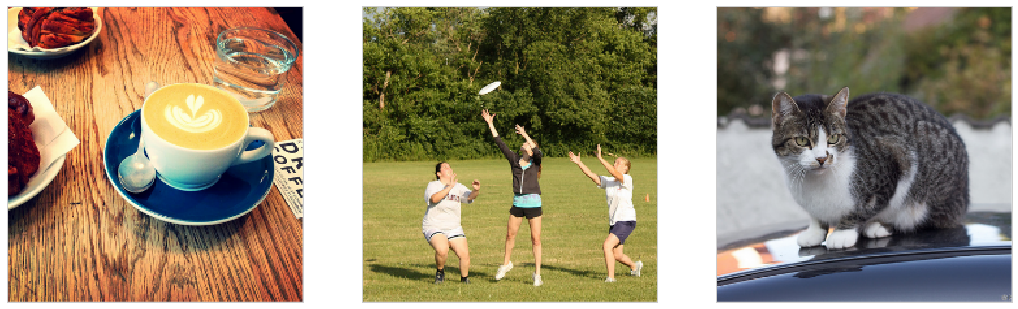

In [8]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [9]:
from src.file_utility import load_mask_from_nii, view_data

In [10]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF',\
           0: 'other'}

In [11]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(nsd_root + "mask/subj%02d/subj%02d_mean_mask.nii.gz"%(subject,subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_mask_full = brain_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(brain_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

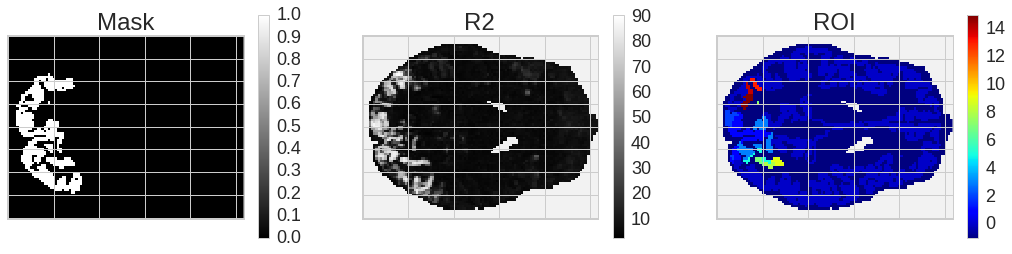

In [12]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [13]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

def load_betas(folder_name, zscore=False, voxel_mask=None):
    from src.file_utility import list_files
    matfiles = []
    betas = []
    for filename in list_files(folder_name):
        if ".mat" in filename:
            matfiles += [filename,]
            print filename
            ##
            beta_data_set = h5py.File(filename)
            values = np.copy(beta_data_set['betas'])
            print values.shape
           
            if voxel_mask is None:
                betas += [values.reshape((len(values), -1), order='F').astype(np.float32) / 300.,]
            else:
                betas += [values.reshape((len(values), -1), order='F')[:,voxel_mask.flatten()].astype(np.float32) / 300.,]
            beta_data_set.close()
            if zscore: 
                mb = np.mean(betas[-1], axis=0, keepdims=True)
                sb = np.std(betas[-1], axis=0, keepdims=True)
                
                betas[-1] = np.nan_to_num((betas[-1] - mb) / (sb + 1e-6))
                print "<beta> = %.3f, <sigma> = %.3f" % (np.mean(mb), np.mean(sb))
                
    return np.concatenate(betas, axis=0), matfiles

voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=general_mask_full)
print voxel_data.shape

/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
(750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.915
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
(750, 83, 104, 81)
<beta> = 0.927, <sigma> = 0.826
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
(750, 83, 104, 81)
<beta> = 1.163, <sigma> = 0.944
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
(750, 83, 104, 81)
<beta> = 0.886, <sigma> = 0.797
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
(750, 83, 104, 81)
<beta> = 1.007, <sigma> = 0.892
/repo.local2/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.mat
(750, 83, 104, 81)
<beta> = 1.111, <sigma> = 0.958
/repo.local2/datasets/

In [14]:
voxel_idx = voxel_idx_general
voxel_roi = voxel_roi_general
voxel_r2  = voxel_r2_general

## Voxel grouping and voxel ROI iterator

In [15]:
def iterate_roi(group, voxelroi, roimap):
    for g in group:
        g_name = ''
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(1,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

1982 	: V1v-V1d
1565 	: V2v-V2d
1385 	: V3v-V3d
462 	: hV4
519 	: VO1-VO2
374 	: PHC1-PHC2
54 	: MST
281 	: hMT
517 	: LO2-LO1
875 	: V3b-V3a
931 	: IPS0-IPS1-IPS2-IPS3-IPS4-IPS5
8945 	: V1v-V1d-V2v-V2d-V3v-V3d-hV4-VO1-VO2-PHC1-PHC2-MST-hMT-LO2-LO1-V3b-V3a-IPS0-IPS1-IPS2-IPS3-IPS4-IPS5


In [16]:
coarse_group = [[1,2],[3,4],[5,6], [7,8,9,10,11,12,13], [14,15,16,17], [18,19,20,21,22,23]]
for roi_mask, roi_name in iterate_roi(coarse_group, voxel_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

1982 	: V1v-V1d
1565 	: V2v-V2d
1385 	: V3v-V3d
1690 	: hV4-VO1-VO2-PHC1-PHC2-MST-hMT
1392 	: LO2-LO1-V3b-V3a
931 	: IPS0-IPS1-IPS2-IPS3-IPS4-IPS5


---

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [17]:
data_size, nv = voxel_data.shape 
print "Total number of voxels = %d" % nv

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print "Validation size =", val_size, ", Training size =", trn_size

Total number of voxels = 15660
Validation size = 1829 , Training size = 16921


- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [18]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data] # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

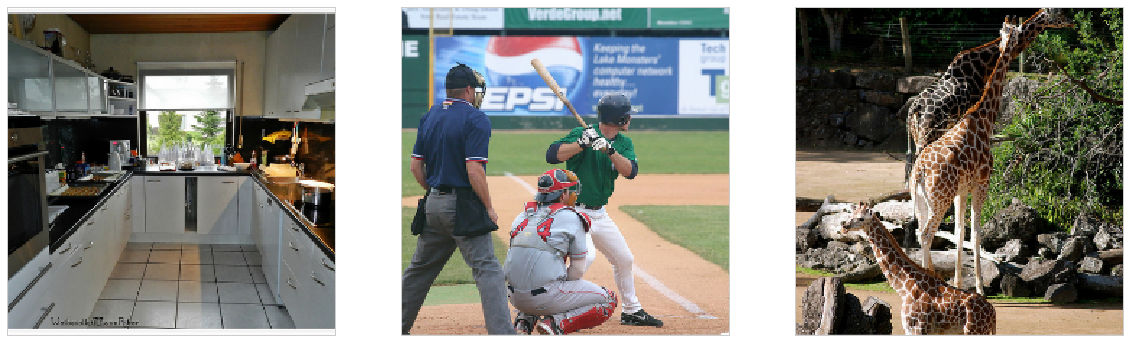

In [19]:
plt.figure(figsize=(20,20))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(val_stim_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

---

---

# Shuffle voxels
- Since we loop over voxels. We don't want to hit organized clusters of similar voxels

In [20]:
nvv = val_voxel_data.shape[1]
voxel_order = np.arange(nvv)
np.random.shuffle(voxel_order)

vpc_idx = voxel_idx[voxel_order]
vpc_roi = voxel_roi[voxel_order]
vpc_r2  = voxel_r2[voxel_order]
trn_vpc_data = trn_voxel_data[:,voxel_order]
val_vpc_data = val_voxel_data[:,voxel_order]

# Shuffle training samples
- In order to prevent batch overfitting to potential session recording bias (unlikely anyway since we've already z-scored per session)

In [21]:
# shuffle trn data
sample_order = np.arange(len(trn_stim_data))
np.random.shuffle(sample_order)
trn_stim_data = trn_stim_data[sample_order]
trn_vpc_data = trn_vpc_data[sample_order]

# Reference model

In [87]:
from src.data_preparation import dnn_feature_extractor

_X = (T.TensorType('uint8', (False,)*4))()
_Y = T.ivector()

_fmaps, _Ybar, _params = dnn_feature_extractor(_X, param_file_name=net_dir + "imagenet_trained_model_weights.pkl")

Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7faba769edd0>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 96, 111, 111)
Params
        |-- W         : (96, 3, 7, 7)
        |-- b         : (96,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7faba76277d0>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 256, 27, 27)
Params
        |-- W         : (256, 96, 5, 5)
        |-- b         : (256,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7faba7732290>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 384, 13, 13)
Params
        |-- W         : (384, 256, 3, 3)


Layer	: <lasagne.layers.normalization.BatchNormLayer object at 0x7faba7627fd0>
Name	: None
Type	: <class 'lasagne.layers.normalization.BatchNormLayer'>
Shape	: (None, 384, 13, 13)
Params
        |-- mean      : (384,)
        |-- inv_std   : (384,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7faba762e890>
Name	:

In [88]:
print 'COMPILING'
t = time.time()
fmaps_fn = theano.function([_X], _fmaps)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
2.45 seconds to compile theano functions


In [89]:
print image_data.shape #[ordering_data]
print stim_data.shape
print len(shared_mask)
#[fm[~shared_mask] for fm in fmaps]

(10000, 3, 227, 227)
(18750, 3, 227, 227)
18750


In [90]:
from src.data_preparation import create_dnn_feature_maps
trn_fmaps, layer_rlist, fmaps_sizes, fmaps_count, lmask, fmask = \
    create_dnn_feature_maps(trn_stim_data, fmaps_fn, batch_size=200, fmap_max=512, trn_size=trn_size) 
## convert range list (rlist) into binary masks over the joint features
tuning_masks = []
for rl in layer_rlist:
    tm = np.zeros(shape=(fmaps_count,), dtype=bool)
    tm[rl] = True
    tuning_masks += [tm,]
assert np.sum(sum(tuning_masks))==fmaps_count, "%d != %d" % (np.sum(sum(tuning_masks)), fmaps_count)

layer: 0, shape=(16921, 96, 55, 55)
layer: 1, shape=(16921, 256, 27, 27)
layer: 2, shape=(16921, 384, 13, 13)
layer: 3, shape=(16921, 384, 13, 13)
layer: 4, shape=(16921, 256, 13, 13)
layer: 5, shape=(16921, 512, 1, 1)
layer: 6, shape=(16921, 512, 1, 1)
layer: 7, shape=(16921, 512, 1, 1)

fmaps: 0, shape=(16921, 96, 55, 55)
fmaps: 1, shape=(16921, 256, 27, 27)
fmaps: 2, shape=(16921, 1024, 13, 13)
fmaps: 3, shape=(16921, 1536, 1, 1)


In [91]:
del trn_fmaps # we just needed the feature map subselection here to pick those we keep, the feature maps are going to be re-calculated on the fly
_sfmaps = [T.concatenate([_fmaps[l] for l in lm], axis=1).take(fm,axis=1) for lm,fm in zip(lmask,fmask)]

In [92]:
lx = ly = 1. # 1 stimuli per stimuli
nx = ny = 8
smin, smax = 0.05, 0.40
ns = 6

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
model_specs = [[(0., lx*1.1), (0., ly*1.1), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
# initial values of the fwrf model parameters
voxel_params_init = [fwrf.zeros_init,]

models = fwrf.model_space(model_specs)
print models.shape

(384, 3)


## Training

In [96]:
log_act_func = lambda x: np.log(1+np.abs(x))*np.tanh(np.abs(x)) #np.log(1+np.sqrt(np.abs(x)))
_log_act_func = lambda _x: T.log(fpX(1)+T.abs_(_x))*T.tanh(T.abs_(_x)) #T.log(fpX(1)+T.sqrt(T.abs_(_x)))
    
sample_batch_size = 200
voxel_batch_size = 500
model_batch_size = 32
model_minibatch_size = 8
holdout_size = 1000
lambdas = np.logspace(3.5,6.5,6)

best_scores, best_lambdas, best_w_params, best_rf_params, best_avg, best_std = \
    fwrf.batched_learn_params_ridge_regression(\
        _sfmaps, fmaps_sizes, [_X,],
        [trn_stim_data,], trn_vpc_data, models, lambdas, sample_batch_size, voxel_batch_size, model_batch_size, model_minibatch_size,
        holdout_size, add_bias=True, mst_nonlinearity=log_act_func)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.67 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:37<00:00, 39.60s/it]

32 mst candidate responses took 157.782s @ 0.203 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:46, 11.62s/it]

COMPILING
0.37 seconds to compile theano functions


100%|██████████| 32/32 [10:33<00:00, 19.67s/it]


-------------------------
total time = 633.715321s
total throughput = 0.040467s/voxel
voxel throughput = 0.028273s/voxel
setup throughput = 5.967381s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.74 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:39<00:00, 40.14s/it]

32 mst candidate responses took 159.657s @ 0.200 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.99s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.08s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:38<00:00, 19.56s/it]


-------------------------
total time = 638.331816s
total throughput = 0.040762s/voxel
voxel throughput = 0.028192s/voxel
setup throughput = 6.151620s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.57 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:38<00:00, 39.69s/it]

32 mst candidate responses took 158.257s @ 0.202 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.82s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.22s/it]

COMPILING
1.89 seconds to compile theano functions


100%|██████████| 32/32 [10:26<00:00, 19.28s/it]


-------------------------
total time = 626.492369s
total throughput = 0.040006s/voxel
voxel throughput = 0.028061s/voxel
setup throughput = 5.845713s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.57 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:37<00:00, 39.62s/it]

32 mst candidate responses took 157.987s @ 0.203 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.95s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:45, 11.42s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:25<00:00, 19.42s/it]


-------------------------
total time = 625.825409s
total throughput = 0.039963s/voxel
voxel throughput = 0.028264s/voxel
setup throughput = 5.725401s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.54 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:37<00:00, 39.36s/it]

32 mst candidate responses took 157.164s @ 0.204 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.90s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:45, 11.48s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:22<00:00, 19.48s/it]


-------------------------
total time = 622.027901s
total throughput = 0.039721s/voxel
voxel throughput = 0.028004s/voxel
setup throughput = 5.733820s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.54 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:37<00:00, 39.36s/it]

32 mst candidate responses took 157.102s @ 0.204 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.19s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:21<00:00, 19.27s/it]


-------------------------
total time = 621.648857s
total throughput = 0.039697s/voxel
voxel throughput = 0.027909s/voxel
setup throughput = 5.768604s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
3.67 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:37<00:00, 39.58s/it]

32 mst candidate responses took 157.983s @ 0.203 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.90s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.18s/it]

COMPILING
0.36 seconds to compile theano functions


100%|██████████| 32/32 [10:24<00:00, 19.26s/it]


-------------------------
total time = 624.959614s
total throughput = 0.039908s/voxel
voxel throughput = 0.028302s/voxel
setup throughput = 5.679876s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.56 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:36<00:00, 39.23s/it]

32 mst candidate responses took 156.453s @ 0.205 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 13.02s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.21s/it]

COMPILING
0.37 seconds to compile theano functions


100%|██████████| 32/32 [10:21<00:00, 19.30s/it]


-------------------------
total time = 621.932150s
total throughput = 0.039715s/voxel
voxel throughput = 0.027973s/voxel
setup throughput = 5.746168s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.56 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:36<00:00, 39.09s/it]

32 mst candidate responses took 156.038s @ 0.205 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.80s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:44, 11.19s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:21<00:00, 19.14s/it]


-------------------------
total time = 621.649889s
total throughput = 0.039697s/voxel
voxel throughput = 0.027928s/voxel
setup throughput = 5.759255s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.54 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:36<00:00, 39.28s/it]

32 mst candidate responses took 156.817s @ 0.204 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.85s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:45, 11.42s/it]

COMPILING
2.68 seconds to compile theano functions


100%|██████████| 32/32 [10:25<00:00, 19.32s/it]


-------------------------
total time = 625.053139s
total throughput = 0.039914s/voxel
voxel throughput = 0.028185s/voxel
setup throughput = 5.739759s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.65 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:36<00:00, 39.23s/it]

32 mst candidate responses took 156.600s @ 0.204 models/s
Applying nonlinearity to modelspace tensor...



4it [00:51, 12.99s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:46, 11.50s/it]

COMPILING
0.36 seconds to compile theano functions


100%|██████████| 32/32 [10:21<00:00, 19.24s/it]


-------------------------
total time = 621.690140s
total throughput = 0.039699s/voxel
voxel throughput = 0.027980s/voxel
setup throughput = 5.735176s/candidate
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 5.874Gb of RAM!
>> Will be divided in chunks of 1.468Gb of VRAM!

COMPILING...
1.66 seconds to compile theano functions

Precomputing mst candidate responses...



100%|██████████| 4/4 [02:36<00:00, 39.14s/it]

32 mst candidate responses took 156.201s @ 0.205 models/s
Applying nonlinearity to modelspace tensor...



4it [00:50, 12.64s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:45, 11.38s/it]

COMPILING
0.35 seconds to compile theano functions


100%|██████████| 32/32 [10:23<00:00, 19.22s/it]


-------------------------
total time = 623.299556s
total throughput = 0.039802s/voxel
voxel throughput = 0.027944s/voxel
setup throughput = 5.803056s/candidate


[    3162.27766017    12589.25411794    50118.72336273   199526.23149689
   794328.23472428  3162277.66016838]


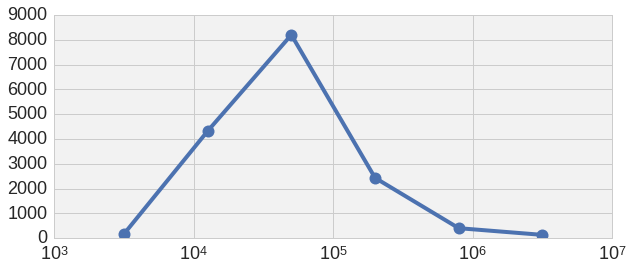

In [97]:
plt.figure(figsize=(10,4))
print lambdas
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

## Validation

In [98]:
from src.data_preparation import create_dnn_feature_maps
val_fmaps, layer_rlist, fmaps_sizes, fmaps_count, lmask, fmask = \
    create_dnn_feature_maps(val_stim_data, fmaps_fn, batch_size=200, fmap_max=512, trn_size=trn_size) 

layer: 0, shape=(1829, 96, 55, 55)
layer: 1, shape=(1829, 256, 27, 27)
layer: 2, shape=(1829, 384, 13, 13)
layer: 3, shape=(1829, 384, 13, 13)
layer: 4, shape=(1829, 256, 13, 13)
layer: 5, shape=(1829, 512, 1, 1)
layer: 6, shape=(1829, 512, 1, 1)
layer: 7, shape=(1829, 512, 1, 1)

fmaps: 0, shape=(1829, 96, 55, 55)
fmaps: 1, shape=(1829, 256, 27, 27)
fmaps: 2, shape=(1829, 1024, 13, 13)
fmaps: 3, shape=(1829, 1536, 1, 1)


In [99]:
sample_batch_size = 250
sample_voxel_size = 100
val_pred = fwrf.get_prediction(val_fmaps, best_rf_params, best_w_params, best_avg, best_std,\
                              _log_act_func, lx, sample_batch_size, voxel_batch_size)
#val_pred = fwrf.get_prediction_from_mst(val_mst_data, best_candidates[:nvv], [w[:nvv] for w in best_w_params], batches=(sample_batch_size, voxel_batch_size))
ref_val_cc = np.zeros(shape=(nvv,), dtype=fpX)    
for v in tqdm(range(nvv)):    
    ref_val_cc[v] = np.corrcoef(val_pred[:,v], val_vpc_data[:,v])[0,1]

100%|██████████| 15660/15660 [00:01<00:00, 9975.91it/s]

CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


max cc = 0.739193
sum(cc>0.10) = 9939 of 15660


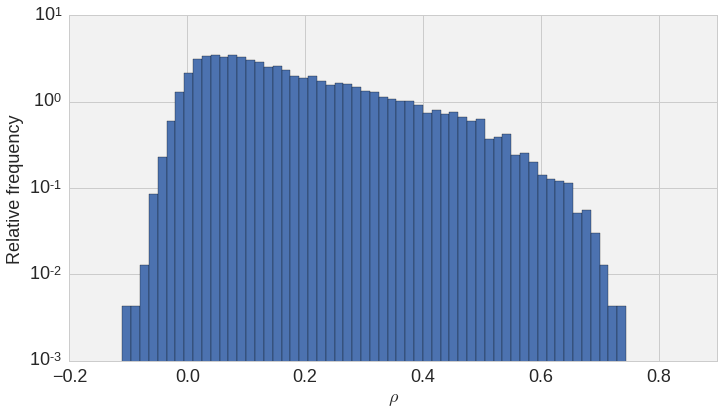

In [100]:
cc_th = 0.1
print "max cc = %f" % np.max(ref_val_cc)
print "sum(cc>%.2f) = %d of %d" % (cc_th, np.sum(map(lambda x: x > cc_th, ref_val_cc)), nvv)
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
_=plt.hist(ref_val_cc, bins=100, normed=True, range=(-.5, 1.))
plt.yscale('log')
#plt.ylim([10**-1, 10**1])
plt.xlim([-.2, 0.9])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')

## Save results

In [104]:
ex_file_name = "temp_fwrf_%s_data" % (timestamp)
print ex_file_name
ex_values = {'voxel_order': voxel_order,
             'voxel_index': vpc_idx,
             'voxel_roi': vpc_roi,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_cc': ref_val_cc}

save_stuff(output_dir + ex_file_name, ex_values)

temp_fwrf_Aug-01-2019_1357_data
saved rf_params in h5py file
saved normavg in h5py file
saved voxel_order in h5py file
failed to save w_params as h5py. will try pickle
saved voxel_roi in h5py file
saved val_cc in h5py file
saved normstd in h5py file
saved voxel_index in h5py file
saved w_params as pkl


---

# Reload reference model prediction accuracy
- Alexnet-fwRF model with parametrized gaussian pooling field, trained elsewhere.

In [20]:
data_set = h5py.File(output_dir + 'temp_fwrf_Aug-01-2019_1357_data.h5py')
voxel_order = np.copy(data_set['voxel_order'])
ref_val_cc = np.copy(data_set['val_cc'])
ref_rf_params = np.copy(data_set['rf_params'])
data_set.close()

In [21]:
nvv = val_voxel_data.shape[1]

In [22]:
vpc_idx = voxel_idx[voxel_order]
vpc_roi = voxel_roi[voxel_order]
vpc_r2  = voxel_r2[voxel_order]
trn_vpc_data = trn_voxel_data[:,voxel_order]
val_vpc_data = val_voxel_data[:,voxel_order]

In [23]:
# shuffle trn data
sample_order = np.arange(len(trn_stim_data))
np.random.shuffle(sample_order)
trn_stim_data = trn_stim_data[sample_order]
trn_vpc_data = trn_vpc_data[sample_order]

---

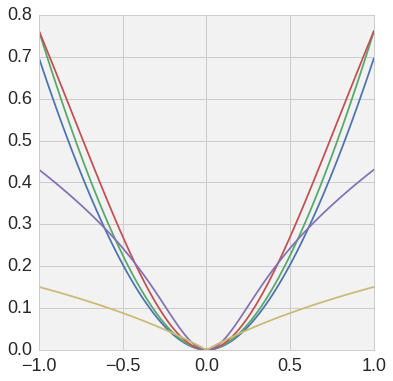

In [83]:
func = lambda x,a: np.log(fpX(1)+np.abs(x)) * np.tanh(np.abs(a * x)) / np.log(fpX(1)+np.abs(a))
x = np.linspace(-1, 1, 100)
plt.figure(figsize=(6,6))
plt.plot(x, func(x,0.01))
plt.plot(x, func(x,.25))
plt.plot(x, func(x,1))
plt.plot(x, func(x,4))
plt.plot(x, func(x,100))

In [24]:
def align_targets(predictions, targets):
    if (getattr(predictions, 'broadcastable', None) == (False, True) and
            getattr(targets, 'ndim', None) == 1):
        targets = as_theano_expression(targets).dimshuffle(0, 'x')
    return predictions, targets
def squared_error(a, b):
    a, b = align_targets(a, b)
    return theano.tensor.square(a - b)
def huber_loss(predictions, targets, delta=1):
    predictions, targets = align_targets(predictions, targets)
    abs_diff = abs(targets - predictions)
    ift = 0.5 * squared_error(targets, predictions)
    iff = delta * (abs_diff - delta / 2.)
    return theano.tensor.switch(abs_diff <= delta, ift, iff)
def pooling_fn(x):
    return np.exp(x) / np.sum(np.exp(x), axis=(1,2), keepdims=True)
def pullaway(_a, _b, func=lambda _x: _x):
    return T.sum(func(_a.flatten(ndim=2)), func(_b.flatten(ndim=2)), axis=1)

In [25]:
import lasagne
import lasagne.layers as L
import lasagne.nonlinearities as NL
import lasagne.init as I

from src.lasagne_utility import deconv, conv, batch_norm, batch_norm_n, fc_concat, conv_concat, avg, flatten, sigmoid, tanh
from src.lasagne_utility import print_lasagne_network

def bypass_block(l_in, n_exposed, n_hiddens=0, filter_size=5, stride=2, pad=1, level=0):
    out = conv(l_in, num_filters=n_exposed+n_hiddens, \
        filter_size=filter_size, stride=stride, pad=pad, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify, name='l%d'%level)
    exp = L.SliceLayer(out, indices=slice(0, n_exposed), axis=1)
    return out, exp

In [26]:
_X = (T.TensorType('uint8', (False,)*4))()
_V = T.fmatrix()
  
_Xbar = theano.shared(np.array( [122.67891434, 116.66876762, 104.00698793] ).astype(np.float32))
_Xbar = T.patternbroadcast(_Xbar.dimshuffle(('x', 0, 'x', 'x')), (True, False, True, True))

l_in = L.InputLayer(shape=(None, 3, 227, 227), input_var=(_X.astype(theano.config.floatX) - _Xbar) / 255)
# block 1
conv1 = conv(l_in, num_filters=96, filter_size=7, stride=2, pad=0, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify) #111
pool1 = L.MaxPool2DLayer(conv1, pool_size=3, stride=2)  # 55  
lrn1  = L.LocalResponseNormalization2DLayer(pool1, alpha=0.0001/5, k=2, beta=0.75, n=5)
# block 2
conv2 = conv(lrn1, num_filters=256, filter_size=5, stride=2, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify) #27
pool2 = L.MaxPool2DLayer(conv2, pool_size=3, stride=2)  
lrn2  = L.LocalResponseNormalization2DLayer(pool2, alpha=0.0001/5, k=2, beta=0.75, n=5, name='lrn')

pre = lrn2
#conv2 = conv(lrn1, num_filters=128, filter_size=5, stride=2, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify) #27
#conv3 = conv(conv2, num_filters=128, filter_size=5, stride=2, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify)
###
###
mix1, fm1 = bypass_block(pre, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=0, level=1)
mix2, fm2 = bypass_block(mix1, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=0, level=2)
mix3, fm3 = bypass_block(mix2, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=0, level=3)
mix4, fm4 = bypass_block(mix3, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=0, level=4)
mix5, fm5 = bypass_block(mix4, n_exposed=128, n_hiddens=256, filter_size=3, stride=1, pad=0, level=5)
#L.DenseLayer()
# block 3
#mix1, fm1 = bypass_block(lrn2, n_exposed=128, n_hiddens=0, filter_size=3, stride=1, pad=1, level=1)
#mix2, fm2 = bypass_block(mix1, n_exposed=128, n_hiddens=0, filter_size=3, stride=1, pad=1, level=2)
#mix3, fm3 = bypass_block(mix2, n_exposed=128, n_hiddens=0, filter_size=3, stride=1, pad=1, level=3)
#mix4, fm4 = bypass_block(mix3, n_exposed=128, n_hiddens=0, filter_size=3, stride=1, pad=1, level=4)
#mix5, fm5 = bypass_block(mix4, n_exposed=128, n_hiddens=0, filter_size=3, stride=1, pad=1, level=5)
out = conv(mix5, num_filters=512, filter_size=3, stride=1, pad=1, W=I.Normal(.02), b=I.Constant(0), nonlinearity=NL.rectify, name='l6') 
##
fmaps = [pre, fm2, fm4, out]
fmaps_shapes = [L.get_output_shape(fm) for fm in fmaps]
## load the parameters from file
n_params = len(L.get_all_params(pre))
_map_params = L.get_all_params(out, trainable=True)[n_params:]
print _map_params
#print_lasagne_network(out, skipnoparam=True)

[l1.W, l1.b, l2.W, l2.b, l3.W, l3.b, l4.W, l4.b, l5.W, l5.b, l6.W, l6.b]


In [27]:
## set the filter layer to refnet values
param_file_name=net_dir + "imagenet_trained_model_weights.pkl"
param_file = open(param_file_name, 'rb')
param_value = pickle.load(param_file)   
L.set_all_param_values(pre, param_value[:n_params])

In [28]:
def _fwrf(_fmaps, fmaps_shapes, rf_rez=(1,1), nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _phi = []
    _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+rf_rez).astype(dtype), name='xyRF')
    for _f,s in zip(_fmaps, fmaps_shapes):
        _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(rf_rez)))), (nv,)+rf_rez)
        if rf_rez != s[2:4]:
            print 'rescale'
            u  = pnu.create_sampling_array(rf_rez, s[2:4])
            _u = theano.shared(u.reshape(s[2:4]+rf_rez).astype(dtype))
            _v = T.tensordot(_v, _u, [[1,2], [2,3]])
        #fmaps : [batch, features, y, x]   # v : [nv, y, x]
        _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
        #_phi : [nv, batch, features]
    ###
    _Phi = T.concatenate(_phi, axis=2)
    if nonlinearity is not None:
        _Phi = nonlinearity(_Phi)
    _w = theano.shared(np.full(fill_value=0, shape=(nv, ft_count), dtype=dtype), name='fRF')
    #_alpha = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='scale')
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    #theano.shared(np.random.normal(0, .02, size=(nv, ft_count)).astype(dtype), name='fRF')
    _vr = T.batched_dot(_Phi, _w).T + _beta.dimshuffle('x',0)
    #_vr = _alpha.dimshuffle('x',0) * T.batched_dot(_Phi, T.nnet.nnet.softmax(_w)).T + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, [_rf, _w, _beta]

def _layerwise_fwrf(_fmaps, fmaps_shapes, nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _phi, _rfs = [],[]
    for l,(_f,s) in enumerate(zip(_fmaps, fmaps_shapes)):
        if len(s)==4 and s[2:]!=(1,1):
            _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+s[2:]).astype(dtype), name='xyRF_%d'%l)
            _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(s[2:])))), (nv,)+s[2:])
            #fmaps : [batch, features, y, x]   # v : [nv, y, x]
            _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
            _rfs += [_rf,]
        else:
            _phi += [T.extra_ops.repeat(_f.flatten(ndim=2).dimshuffle('x',0,1), repeats=nv, axis=0)]          
        #_phi : [nv, batch, features]
    ###
    _Phi = T.concatenate(_phi, axis=2)
    if nonlinearity is not None:
        _Phi = nonlinearity(_Phi)
    _w = theano.shared(np.full(fill_value=0, shape=(nv, ft_count), dtype=dtype), name='fRF')
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    #theano.shared(np.random.normal(0, .02, size=(nv, ft_count)).astype(dtype), name='fRF')
    _vr = T.batched_dot(_Phi, _w).T + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, _rfs+[_w,_beta]

In [29]:
print nvv
print fmaps_shapes

15660
[(None, 256, 13, 13), (None, 128, 9, 9), (None, 128, 5, 5), (None, 512, 3, 3)]


In [30]:
n_pix = 13
nv_block = 2000

_trn_fmaps = [L.get_output(fm, deterministic=False) for fm in fmaps]
_val_fmaps = [L.get_output(fm, deterministic=True) for fm in fmaps]
### define factorization of global linear model over feature maps 
#rf_rez=(n_pix, n_pix),
_r, _fwrf_params = _layerwise_fwrf(_trn_fmaps, fmaps_shapes, nv=nv_block)
#_r, _fwrf_params = _layerwise_fwrf(_trn_fmaps, fmaps_shapes, nv=nv_block, \
#                                   nonlinearity=lambda _x: T.log(fpX(1)+T.abs_(_x))*T.tanh(T.abs_(_x))) 
# nonlinearity=lambda _x: T.log(1+T.sqrt(T.abs_(_x)))
# nonlinearity=lambda _x: T.log(fpX(1)+T.abs_(_x))*T.tanh(T.abs_(_x))

# full params
fwrf_inits = [fwrf.ones_init,]*4 + [fwrf.zeros_init,]*2
fwrf_params = [init(shape=(nvv,)+_p.get_value().shape[1:]) for _p,init in zip(_fwrf_params, fwrf_inits)]
map_params = [_p.get_value() for _p in _map_params]

_params = _map_params + _fwrf_params
print _params

1024 13 13
[l1.W, l1.b, l2.W, l2.b, l3.W, l3.b, l4.W, l4.b, l5.W, l5.b, l6.W, l6.b, xyRF_0, xyRF_1, xyRF_2, xyRF_3, fRF, bias]


In [31]:
for _p,p in zip(_fwrf_params, fwrf_params):
    print "%s : block size %s, full size : %s" % (_p.name, _p.get_value().shape, p.shape)

xyRF_0 : block size (2000, 13, 13), full size : (15660, 13, 13)
xyRF_1 : block size (2000, 9, 9), full size : (15660, 9, 9)
xyRF_2 : block size (2000, 5, 5), full size : (15660, 5, 5)
xyRF_3 : block size (2000, 3, 3), full size : (15660, 3, 3)
fRF : block size (2000, 1024), full size : (15660, 1024)
bias : block size (2000,), full size : (15660,)


In [32]:
feature_weight_idx = 4

In [33]:
param_count = 0
for _w in _map_params:
    param_count += np.prod(_w.get_value().shape)
print param_count, " shared params"

for w in fwrf_params:
    param_count += np.prod(w.shape)
print param_count // nvv, " approx params per voxels"

7965056  shared params
1817  approx params per voxels


In [34]:
# denoising autoencoder before stim2vox
from collections import OrderedDict

_lr1 = theano.shared(fpX(0))
_lr2 = theano.shared(fpX(0))
_lr3 = theano.shared(fpX(0))
_nu  = theano.shared(fpX(1e-1)) # leaky weighting: nu is the minimum weight
#_reg = _l2 * lasagne.regularization.regularize_layer_params(out, lasagne.regularization.l2)
###
_err = T.sum(lasagne.objectives.squared_error(_r, _V), axis=0)
#_err = huber_loss(_r, _V, delta=1.)

_wgt = theano.shared(np.zeros(nv_block, dtype=fpX), name='weight')
_corr2 = T.square((T.mean(_r * _V, axis=0) + _nu)) / ((T.mean(T.square(_r), axis=0)) * (T.mean(T.square(_V), axis=0)) + _nu)
_weighted_err = _wgt * _err # error per voxel

#_pullaway = T.sum(pullaway(_fwrf_param[0], _fwrf_param[1], func=lambda _x: T.nnet.nnet.softmax(_x)))
_l1 = T.sum(T.abs_(_fwrf_params[feature_weight_idx]))
_loss = T.sum(_weighted_err) + fpX(.1) * _l1 #+ _pullaway #+ _reg

_update_map = lasagne.updates.adam(_loss, _map_params, learning_rate=_lr1, beta1=0.9, epsilon=1e-8)
_update_f1   = lasagne.updates.adam(_loss, _fwrf_params[:feature_weight_idx], learning_rate=_lr2, beta1=0.9, epsilon=1e-8)
_update_f2   = lasagne.updates.adam(_loss, _fwrf_params[feature_weight_idx:], learning_rate=_lr3, beta1=0.9, epsilon=1e-8)
_update_r2   = OrderedDict([(_wgt, _corr2)]) 
#_update_map = lasagne.updates.sgd(_loss, _map_params, learning_rate=_lr1)
#_update_f1   = lasagne.updates.sgd(_loss, _fwrf_params[:1], learning_rate=_lr2)
#_update_f2   = lasagne.updates.sgd(_loss, _fwrf_params[1:], learning_rate=_lr3)

_updates = _update_map
_updates.update(_update_f1)
_updates.update(_update_f2)
_updates.update(_update_r2)

print 'COMPILING'
t = time.time()
trn_fn = theano.function([_X, _V], _err, updates=_updates)
val_fn = theano.function([_X, _V], _err, givens=[(_v,_value) for _v,_value in zip(_trn_fmaps, _val_fmaps)])
pred_fn = theano.function([_X], _r, givens=[(_v,_value) for _v,_value in zip(_trn_fmaps, _val_fmaps)])
grad_fn = theano.function([_X, _V], [T.mean(T.abs_(T.grad(_loss, _p))) for _p in _params])
mean_fn = theano.function([], [T.mean(T.abs_(_p)) for _p in _params])
corr_fn = theano.function([_X, _V], _corr2)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
24.18 seconds to compile theano functions


## Initialization of training parameters

In [35]:
best_global_map_params = [_p.get_value() for _p in _map_params]
best_global_fwrf_params = [np.copy(p) for p in fwrf_params]
        
best_loss = np.full(fill_value=np.inf, shape=(nvv), dtype=fpX)
best_global_loss  = np.inf

# The big loop over epochs, over voxels and over the samples.

In [37]:
##### train this shit
## monitor the increase in test loss for each voxel separately. Don't update weights of overfitted voxels.
##
_lr1.set_value(fpX(1e-5))
_lr2.set_value(fpX(1e-3))
_lr3.set_value(fpX(1e-3))

num_epochs = 200
num_epochs_per_block = 1
batch_size = 100
max_sample = len(trn_stim_data)
holdout_size = 1000

val_hist, cc_hist = [], []
sample = np.arange(nvv)
vidxes = sample[:nv_block]
best_epoch = 0
epoch_count = np.zeros(shape=(nvv), dtype=int)
trn_vpc_holdout = trn_vpc_data[:holdout_size,:nv_block]
for epoch in range(num_epochs):
    ##
    ## SELECT A BLOCK OF VOXELS AND RELOAD THE MATCHING PARAMETERS
    ## 
    print '======================================'
    if epoch%num_epochs_per_block==0:
        sample = np.roll(sample, -nv_block//2) #### need to insure all voxels are done at some point
        vidxes = sample[:nv_block]
        trn_vpc_block = trn_vpc_data[:,vidxes]
        val_vpc_block = val_vpc_data[:,vidxes]
        print '-----> new block (%d--%d) <-----' % (vidxes[0], vidxes[-1])
        trn_fn = theano.function([_X, _V], _err, updates=_updates)
    ###   
    epoch_count[vidxes] += 1
    # load the current voxel parameters.
    _wgt.set_value(vpc_r2[vidxes]/100) ## initialization
    for k in range(len(fwrf_params)):
        _fwrf_params[k].set_value(fwrf_params[k][vidxes]) 
    print '--------------------------------------'
    for _p,v,g in zip(_params, mean_fn(), grad_fn(trn_stim_data[:100], trn_vpc_block[:100])):
        print "%s \t: value=%f, grad=%f" % (_p.name,v,g)   
    print '--------------------------------------'
    sys.stdout.flush()
    ##
    ##  RUN OVER THE DATASET BLOCK
    ##
    # In each epoch, we do a full pass over the training data:
    trn_err = fpX(0)
    trn_count = 0
    start_time = time.time()
    for xb, vb in tqdm(fwrf.iterate_minibatches(trn_stim_data[:max_sample-holdout_size], trn_vpc_block[:max_sample-holdout_size], batch_size)):
        err = trn_fn(xb, vb).mean() # mean over voxels since I don't track trn loss for individual voxels
        trn_err += err
        trn_count += len(xb) 
    ## save current voxel-wise parameters
    cur_fwrf_params = [_p.get_value() for _p in _fwrf_params]
    ##
    ##  FULL VALIDATION PASS OVER ALL VOXELS
    ##
    val_err = np.zeros(shape=(nvv), dtype=fpX)
    for rv,lv in fwrf.iterate_range(0, nvv, nv_block):
        for k in range(len(fwrf_params)):
            param = np.zeros_like(fwrf_params[k][:nv_block])
            param[:lv] = fwrf_params[k][rv]
            _fwrf_params[k].set_value(param)
        ###
        trn_vpc_holdout[:,:lv] = trn_vpc_data[max_sample-holdout_size:max_sample,rv]
        for xb, vb in fwrf.iterate_minibatches(trn_stim_data[max_sample-holdout_size:max_sample], trn_vpc_holdout, batch_size):
            val_err[rv] +=  val_fn(xb, vb)[:lv]      
    cur_global_loss = np.mean(val_err) / holdout_size
    val_hist += [np.copy(val_err / holdout_size),]
    if cur_global_loss<=best_global_loss:
        best_epoch = epoch
        best_global_loss = cur_global_loss
        best_global_map_params = [_p.get_value() for _p in _map_params]
        best_global_fwrf_params = [np.copy(p) for p in fwrf_params]      
    else: # if the voxel-wise loss if improved at the previous value of the shared parameters? update them. 
        [_p.set_value(p) for _p, p in zip(_map_params, best_global_map_params)]
    
    ### Evaluate voxel-wise params at the new shared point or at the previous one.
    
    val_err = np.zeros(shape=(nv_block), dtype=fpX)
    [_p.set_value(p) for _p,p in zip(_fwrf_params, cur_fwrf_params)]
    for xb, vb in fwrf.iterate_minibatches(trn_stim_data[max_sample-holdout_size:max_sample], trn_vpc_block[max_sample-holdout_size:max_sample], batch_size):
        err = val_fn(xb, vb)
        val_err += err
    cur_batch_loss = val_err / holdout_size 
    improvement = cur_batch_loss<=best_loss[vidxes]
    n_imp = np.sum(improvement.astype(int))
    # save current block
    if n_imp>0:
        print '--> %d improvements <--' % n_imp
        for k in range(len(fwrf_params)):
            fwrf_params[k][vidxes[improvement]] = cur_fwrf_params[k][improvement]
        best_loss[vidxes[improvement]] = cur_batch_loss[improvement]        
        
    ##       
    ##  RESULTING VALIDATION ACCURACY HISTORY 
    ##  THIS IS NOT USED IN ANY TRAINING DECISION
    ##
    val_cc  = np.zeros(shape=(nvv), dtype=fpX)   
    for rv,lv in fwrf.iterate_range(0, nvv, nv_block):
        ### reload the params for these voxels
        for k in range(len(fwrf_params)):
            param = np.zeros_like(fwrf_params[k][:nv_block])
            param[:lv] = fwrf_params[k][rv]
            _fwrf_params[k].set_value(param)
        ###
        val_vpc_block = np.zeros(shape=(len(val_stim_data), nv_block), dtype=fpX)
        for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
            val_vpc_block[rb] = pred_fn(val_stim_data[rb])
        for v,vv in enumerate(rv):    
            val_cc[vv] = np.corrcoef(val_vpc_data[:,vv], val_vpc_block[:,v])[0,1]              
        
    cc_hist += [np.copy(val_cc),]
    ##
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_count))
    print("  validation loss (batch):    {:.6f}".format(cur_batch_loss.mean()))      
    print("  validation loss (full):     {:.6f}".format(cur_global_loss))  
    print("  median validation accuracy = %.3f" % np.median(np.nan_to_num(val_cc)))
    sys.stdout.flush()

-----> new block (1000--2999) <-----
--------------------------------------
l1.W 	: value=0.015952, grad=0.000000
l1.b 	: value=0.000000, grad=0.000000
l2.W 	: value=0.015952, grad=0.000000
l2.b 	: value=0.000000, grad=0.000000
l3.W 	: value=0.015952, grad=0.000000
l3.b 	: value=0.000000, grad=0.000000
l4.W 	: value=0.015962, grad=0.000000
l4.b 	: value=0.000000, grad=0.000000
l5.W 	: value=0.015954, grad=0.000000
l5.b 	: value=0.000000, grad=0.000000
l6.W 	: value=0.015965, grad=0.000000
l6.b 	: value=0.000000, grad=0.000000
xyRF_0 	: value=1.000000, grad=0.000000
xyRF_1 	: value=1.000000, grad=0.000000
xyRF_2 	: value=1.000000, grad=0.000000
xyRF_3 	: value=1.000000, grad=0.000000
fRF 	: value=0.000000, grad=2.357190
bias 	: value=0.000000, grad=5.579217
--------------------------------------


160it [00:40,  4.14it/s]

--> 2000 improvements <--

  Epoch 1 of 200 took 60.950s
  training loss:       0.988651
  validation loss (batch):    0.975284
  validation loss (full):     1.001814
  median validation accuracy = 0.000
-----> new block (2000--3999) <-----
--------------------------------------
l1.W 	: value=0.015953, grad=3.771114
l1.b 	: value=0.000217, grad=4.349611
l2.W 	: value=0.015953, grad=1.864927
l2.b 	: value=0.000223, grad=3.594179
l3.W 	: value=0.015953, grad=1.114342
l3.b 	: value=0.000203, grad=2.808340
l4.W 	: value=0.015962, grad=0.483517
l4.b 	: value=0.000222, grad=1.258572
l5.W 	: value=0.015953, grad=0.112426
l5.b 	: value=0.000294, grad=0.501048
l6.W 	: value=0.015969, grad=0.030601
l6.b 	: value=0.000418, grad=0.275908
xyRF_0 	: value=0.998721, grad=0.003402
xyRF_1 	: value=0.999322, grad=0.001358
xyRF_2 	: value=1.000236, grad=0.004700
xyRF_3 	: value=0.999475, grad=0.001074
fRF 	: value=0.000678, grad=2.016905
bias 	: value=0.002019, grad=6.740593
-----------------------------


160it [00:41,  4.01it/s]

--> 1762 improvements <--

  Epoch 2 of 200 took 61.890s
  training loss:       0.970626
  validation loss (batch):    0.965385
  validation loss (full):     0.998032
  median validation accuracy = 0.000
-----> new block (3000--4999) <-----
--------------------------------------
l1.W 	: value=0.015954, grad=10.331104
l1.b 	: value=0.000299, grad=11.669688
l2.W 	: value=0.015955, grad=5.751550
l2.b 	: value=0.000303, grad=9.658670
l3.W 	: value=0.015956, grad=3.962193
l3.b 	: value=0.000251, grad=8.137984
l4.W 	: value=0.015965, grad=2.296294
l4.b 	: value=0.000260, grad=4.237703
l5.W 	: value=0.015956, grad=0.762163
l5.b 	: value=0.000339, grad=1.897793
l6.W 	: value=0.015972, grad=0.253487
l6.b 	: value=0.000481, grad=1.002635
xyRF_0 	: value=0.998863, grad=0.002775
xyRF_1 	: value=0.998575, grad=0.001325
xyRF_2 	: value=0.998735, grad=0.009225
xyRF_3 	: value=0.999208, grad=0.014038
fRF 	: value=0.000788, grad=2.194582
bias 	: value=0.001519, grad=7.133180
---------------------------


160it [00:41,  4.19it/s]

--> 1732 improvements <--

  Epoch 3 of 200 took 61.650s
  training loss:       0.961074
  validation loss (batch):    0.956911
  validation loss (full):     0.994621
  median validation accuracy = 0.000
-----> new block (4000--5999) <-----
--------------------------------------
l1.W 	: value=0.015955, grad=7.861218
l1.b 	: value=0.000346, grad=7.462591
l2.W 	: value=0.015957, grad=4.637000
l2.b 	: value=0.000336, grad=6.192104
l3.W 	: value=0.015959, grad=3.292942
l3.b 	: value=0.000284, grad=5.173467
l4.W 	: value=0.015967, grad=2.586172
l4.b 	: value=0.000289, grad=3.636742
l5.W 	: value=0.015960, grad=1.481656
l5.b 	: value=0.000368, grad=2.941536
l6.W 	: value=0.015974, grad=0.399974
l6.b 	: value=0.000496, grad=1.105160
xyRF_0 	: value=0.999084, grad=0.002729
xyRF_1 	: value=0.998550, grad=0.001496
xyRF_2 	: value=0.998482, grad=0.010105
xyRF_3 	: value=0.999128, grad=0.020123
fRF 	: value=0.000872, grad=2.203790
bias 	: value=0.001310, grad=6.878922
-----------------------------


160it [00:41,  4.05it/s]

--> 1800 improvements <--

  Epoch 4 of 200 took 61.453s
  training loss:       0.955783
  validation loss (batch):    0.953556
  validation loss (full):     0.990906
  median validation accuracy = 0.000
-----> new block (5000--6999) <-----
--------------------------------------
l1.W 	: value=0.015956, grad=9.525138
l1.b 	: value=0.000384, grad=9.504215
l2.W 	: value=0.015959, grad=5.520028
l2.b 	: value=0.000357, grad=7.428907
l3.W 	: value=0.015962, grad=3.875093
l3.b 	: value=0.000315, grad=6.048835
l4.W 	: value=0.015969, grad=2.945544
l4.b 	: value=0.000308, grad=3.814707
l5.W 	: value=0.015963, grad=1.545069
l5.b 	: value=0.000381, grad=2.562620
l6.W 	: value=0.015976, grad=0.435503
l6.b 	: value=0.000503, grad=0.992126
xyRF_0 	: value=0.999213, grad=0.002480
xyRF_1 	: value=0.998633, grad=0.001512
xyRF_2 	: value=0.998580, grad=0.009964
xyRF_3 	: value=0.999255, grad=0.023042
fRF 	: value=0.000854, grad=2.260900
bias 	: value=0.001151, grad=6.904170
-----------------------------


160it [00:41,  4.06it/s]

--> 1798 improvements <--

  Epoch 5 of 200 took 61.712s
  training loss:       0.953707
  validation loss (batch):    0.950772
  validation loss (full):     0.987264
  median validation accuracy = 0.000
-----> new block (6000--7999) <-----
--------------------------------------
l1.W 	: value=0.015958, grad=8.446577
l1.b 	: value=0.000407, grad=8.058884
l2.W 	: value=0.015961, grad=5.279041
l2.b 	: value=0.000374, grad=6.549186
l3.W 	: value=0.015964, grad=3.886350
l3.b 	: value=0.000339, grad=5.544886
l4.W 	: value=0.015972, grad=3.175833
l4.b 	: value=0.000325, grad=3.726244
l5.W 	: value=0.015966, grad=1.804615
l5.b 	: value=0.000397, grad=2.706138
l6.W 	: value=0.015977, grad=0.517727
l6.b 	: value=0.000507, grad=1.057495
xyRF_0 	: value=0.999420, grad=0.002322
xyRF_1 	: value=0.998833, grad=0.001488
xyRF_2 	: value=0.998759, grad=0.010671
xyRF_3 	: value=0.999310, grad=0.025408
fRF 	: value=0.000858, grad=2.259152
bias 	: value=0.001061, grad=6.903021
-----------------------------


160it [00:41,  4.12it/s]

--> 1784 improvements <--

  Epoch 6 of 200 took 61.426s
  training loss:       0.952090
  validation loss (batch):    0.948444
  validation loss (full):     0.983597
  median validation accuracy = 0.000
-----> new block (7000--8999) <-----
--------------------------------------
l1.W 	: value=0.015959, grad=8.997942
l1.b 	: value=0.000427, grad=9.310819
l2.W 	: value=0.015964, grad=5.664414
l2.b 	: value=0.000389, grad=7.449535
l3.W 	: value=0.015968, grad=4.225704
l3.b 	: value=0.000362, grad=6.271037
l4.W 	: value=0.015974, grad=3.587043
l4.b 	: value=0.000340, grad=4.224941
l5.W 	: value=0.015970, grad=2.149561
l5.b 	: value=0.000409, grad=3.112484
l6.W 	: value=0.015978, grad=0.625243
l6.b 	: value=0.000511, grad=1.149384
xyRF_0 	: value=0.999322, grad=0.002067
xyRF_1 	: value=0.998718, grad=0.001310
xyRF_2 	: value=0.998788, grad=0.009819
xyRF_3 	: value=0.999296, grad=0.025991
fRF 	: value=0.000850, grad=2.250013
bias 	: value=0.000935, grad=6.837179
-----------------------------


160it [00:41,  4.12it/s]

--> 1729 improvements <--

  Epoch 7 of 200 took 61.732s
  training loss:       0.951164
  validation loss (batch):    0.950204
  validation loss (full):     0.980355
  median validation accuracy = 0.009
-----> new block (8000--9999) <-----
--------------------------------------
l1.W 	: value=0.015961, grad=18.030725
l1.b 	: value=0.000442, grad=19.226929
l2.W 	: value=0.015966, grad=11.599451
l2.b 	: value=0.000404, grad=15.277082
l3.W 	: value=0.015971, grad=8.478463
l3.b 	: value=0.000379, grad=13.026793
l4.W 	: value=0.015977, grad=6.529826
l4.b 	: value=0.000354, grad=7.677953
l5.W 	: value=0.015974, grad=3.668470
l5.b 	: value=0.000420, grad=5.389282
l6.W 	: value=0.015979, grad=0.934340
l6.b 	: value=0.000513, grad=1.713000
xyRF_0 	: value=0.999573, grad=0.001958
xyRF_1 	: value=0.999147, grad=0.001200
xyRF_2 	: value=0.999125, grad=0.009329
xyRF_3 	: value=0.999341, grad=0.028059
fRF 	: value=0.000852, grad=2.354804
bias 	: value=0.000851, grad=7.092874
------------------------


160it [00:41,  4.19it/s]

--> 1721 improvements <--

  Epoch 8 of 200 took 61.626s
  training loss:       0.947611
  validation loss (batch):    0.948838
  validation loss (full):     0.977110
  median validation accuracy = 0.067
-----> new block (9000--10999) <-----
--------------------------------------
l1.W 	: value=0.015962, grad=21.234669
l1.b 	: value=0.000454, grad=22.891346
l2.W 	: value=0.015968, grad=13.913324
l2.b 	: value=0.000416, grad=18.318075
l3.W 	: value=0.015975, grad=10.246191
l3.b 	: value=0.000393, grad=15.678825
l4.W 	: value=0.015980, grad=8.338849
l4.b 	: value=0.000362, grad=9.664667
l5.W 	: value=0.015978, grad=4.792009
l5.b 	: value=0.000430, grad=6.879692
l6.W 	: value=0.015981, grad=1.279426
l6.b 	: value=0.000517, grad=2.288315
xyRF_0 	: value=0.999503, grad=0.002058
xyRF_1 	: value=0.998987, grad=0.001309
xyRF_2 	: value=0.999093, grad=0.010328
xyRF_3 	: value=0.999260, grad=0.031420
fRF 	: value=0.000891, grad=2.466046
bias 	: value=0.000770, grad=7.484564
----------------------


160it [00:41,  4.10it/s]

--> 1754 improvements <--

  Epoch 9 of 200 took 61.683s
  training loss:       0.945313
  validation loss (batch):    0.947747
  validation loss (full):     0.973536
  median validation accuracy = 0.100
-----> new block (10000--11999) <-----
--------------------------------------
l1.W 	: value=0.015964, grad=21.833628
l1.b 	: value=0.000466, grad=23.449169
l2.W 	: value=0.015971, grad=14.587693
l2.b 	: value=0.000425, grad=18.965199
l3.W 	: value=0.015979, grad=10.856717
l3.b 	: value=0.000406, grad=16.386559
l4.W 	: value=0.015983, grad=8.678760
l4.b 	: value=0.000370, grad=9.768248
l5.W 	: value=0.015983, grad=4.911157
l5.b 	: value=0.000438, grad=6.728414
l6.W 	: value=0.015982, grad=1.252009
l6.b 	: value=0.000519, grad=2.084678
xyRF_0 	: value=0.999546, grad=0.001989
xyRF_1 	: value=0.999027, grad=0.001169
xyRF_2 	: value=0.999092, grad=0.010042
xyRF_3 	: value=0.999265, grad=0.032707
fRF 	: value=0.000885, grad=2.457305
bias 	: value=0.000749, grad=7.319818
---------------------


160it [00:41,  4.11it/s]

--> 1704 improvements <--

  Epoch 10 of 200 took 61.588s
  training loss:       0.945147
  validation loss (batch):    0.952119
  validation loss (full):     0.970366
  median validation accuracy = 0.124
-----> new block (11000--12999) <-----
--------------------------------------
l1.W 	: value=0.015965, grad=26.977747
l1.b 	: value=0.000475, grad=29.805492
l2.W 	: value=0.015973, grad=18.503557
l2.b 	: value=0.000433, grad=24.426479
l3.W 	: value=0.015983, grad=13.692185
l3.b 	: value=0.000417, grad=20.867950
l4.W 	: value=0.015986, grad=10.838511
l4.b 	: value=0.000377, grad=12.147905
l5.W 	: value=0.015987, grad=6.004199
l5.b 	: value=0.000446, grad=8.136904
l6.W 	: value=0.015983, grad=1.584270
l6.b 	: value=0.000522, grad=2.555802
xyRF_0 	: value=0.999551, grad=0.001878
xyRF_1 	: value=0.999088, grad=0.001151
xyRF_2 	: value=0.999248, grad=0.009968
xyRF_3 	: value=0.999179, grad=0.035799
fRF 	: value=0.000892, grad=2.519079
bias 	: value=0.000745, grad=7.491200
------------------


160it [00:42,  4.12it/s]

--> 1674 improvements <--

  Epoch 11 of 200 took 62.215s
  training loss:       0.943771
  validation loss (batch):    0.951905
  validation loss (full):     0.967436
  median validation accuracy = 0.146
-----> new block (12000--13999) <-----
--------------------------------------
l1.W 	: value=0.015967, grad=24.567932
l1.b 	: value=0.000484, grad=26.878017
l2.W 	: value=0.015976, grad=17.124781
l2.b 	: value=0.000439, grad=22.384609
l3.W 	: value=0.015987, grad=12.901752
l3.b 	: value=0.000426, grad=19.320784
l4.W 	: value=0.015989, grad=10.564181
l4.b 	: value=0.000382, grad=11.524200
l5.W 	: value=0.015992, grad=6.085884
l5.b 	: value=0.000452, grad=7.857400
l6.W 	: value=0.015985, grad=1.598874
l6.b 	: value=0.000523, grad=2.463197
xyRF_0 	: value=0.999599, grad=0.001981
xyRF_1 	: value=0.999235, grad=0.001120
xyRF_2 	: value=0.999465, grad=0.009771
xyRF_3 	: value=0.999198, grad=0.038963
fRF 	: value=0.000920, grad=2.623424
bias 	: value=0.000774, grad=7.719943
------------------


160it [00:41,  4.16it/s]

--> 1603 improvements <--

  Epoch 12 of 200 took 61.172s
  training loss:       0.939926
  validation loss (batch):    0.950001
  validation loss (full):     0.964551
  median validation accuracy = 0.164
-----> new block (13000--14999) <-----
--------------------------------------
l1.W 	: value=0.015969, grad=29.638233
l1.b 	: value=0.000491, grad=32.355553
l2.W 	: value=0.015978, grad=21.209309
l2.b 	: value=0.000442, grad=27.377277
l3.W 	: value=0.015991, grad=15.958915
l3.b 	: value=0.000435, grad=23.685863
l4.W 	: value=0.015992, grad=12.974157
l4.b 	: value=0.000387, grad=14.018887
l5.W 	: value=0.015997, grad=7.262130
l5.b 	: value=0.000457, grad=9.274610
l6.W 	: value=0.015986, grad=1.934512
l6.b 	: value=0.000525, grad=2.923395
xyRF_0 	: value=0.999485, grad=0.001968
xyRF_1 	: value=0.999042, grad=0.001192
xyRF_2 	: value=0.999282, grad=0.010060
xyRF_3 	: value=0.999105, grad=0.041711
fRF 	: value=0.000962, grad=2.634337
bias 	: value=0.000776, grad=7.696959
------------------


160it [00:41,  4.16it/s]

--> 1590 improvements <--

  Epoch 13 of 200 took 61.526s
  training loss:       0.937348
  validation loss (batch):    0.951401
  validation loss (full):     0.961547
  median validation accuracy = 0.181
-----> new block (14000--339) <-----
--------------------------------------
l1.W 	: value=0.015970, grad=28.351473
l1.b 	: value=0.000498, grad=31.408298
l2.W 	: value=0.015981, grad=20.239332
l2.b 	: value=0.000445, grad=26.111914
l3.W 	: value=0.015995, grad=15.495421
l3.b 	: value=0.000444, grad=22.673767
l4.W 	: value=0.015995, grad=13.128926
l4.b 	: value=0.000390, grad=14.119095
l5.W 	: value=0.016002, grad=7.797731
l5.b 	: value=0.000464, grad=9.776148
l6.W 	: value=0.015988, grad=2.311608
l6.b 	: value=0.000527, grad=3.491642
xyRF_0 	: value=0.999479, grad=0.002006
xyRF_1 	: value=0.999065, grad=0.001186
xyRF_2 	: value=0.999411, grad=0.010226
xyRF_3 	: value=0.999156, grad=0.043618
fRF 	: value=0.000963, grad=2.716946
bias 	: value=0.000814, grad=8.053876
--------------------


160it [00:41,  4.18it/s]

--> 1546 improvements <--

  Epoch 14 of 200 took 61.235s
  training loss:       0.938190
  validation loss (batch):    0.953887
  validation loss (full):     0.959396
  median validation accuracy = 0.196
-----> new block (15000--1339) <-----
--------------------------------------
l1.W 	: value=0.015972, grad=27.895914
l1.b 	: value=0.000504, grad=32.479012
l2.W 	: value=0.015983, grad=20.906326
l2.b 	: value=0.000450, grad=27.978712
l3.W 	: value=0.015999, grad=17.491995
l3.b 	: value=0.000449, grad=26.262012
l4.W 	: value=0.015998, grad=16.357616
l4.b 	: value=0.000394, grad=17.998001
l5.W 	: value=0.016007, grad=10.336122
l5.b 	: value=0.000469, grad=13.255236
l6.W 	: value=0.015989, grad=3.403397
l6.b 	: value=0.000527, grad=5.135812
xyRF_0 	: value=0.999331, grad=0.003139
xyRF_1 	: value=0.999260, grad=0.001650
xyRF_2 	: value=0.999764, grad=0.012659
xyRF_3 	: value=0.998949, grad=0.061709
fRF 	: value=0.001200, grad=2.891022
bias 	: value=0.001466, grad=8.624660
-----------------


160it [00:41,  4.11it/s]

--> 1513 improvements <--

  Epoch 15 of 200 took 61.463s
  training loss:       0.942540
  validation loss (batch):    0.954553
  validation loss (full):     0.956977
  median validation accuracy = 0.204
-----> new block (340--2339) <-----
--------------------------------------
l1.W 	: value=0.015973, grad=37.628078
l1.b 	: value=0.000508, grad=46.332573
l2.W 	: value=0.015985, grad=27.985741
l2.b 	: value=0.000453, grad=38.732300
l3.W 	: value=0.016003, grad=24.058828
l3.b 	: value=0.000453, grad=36.941040
l4.W 	: value=0.016000, grad=23.629122
l4.b 	: value=0.000396, grad=26.677130
l5.W 	: value=0.016011, grad=14.485990
l5.b 	: value=0.000474, grad=18.247105
l6.W 	: value=0.015990, grad=5.024137
l6.b 	: value=0.000530, grad=7.248549
xyRF_0 	: value=0.997322, grad=0.006371
xyRF_1 	: value=0.998018, grad=0.003057
xyRF_2 	: value=0.999640, grad=0.022134
xyRF_3 	: value=0.998319, grad=0.097489
fRF 	: value=0.001714, grad=3.242737
bias 	: value=0.003376, grad=9.626513
-------------------


160it [00:41,  4.19it/s]

--> 1252 improvements <--

  Epoch 16 of 200 took 61.294s
  training loss:       0.945620
  validation loss (batch):    0.954512
  validation loss (full):     0.954872
  median validation accuracy = 0.204
-----> new block (1340--3339) <-----
--------------------------------------
l1.W 	: value=0.015975, grad=24.697798
l1.b 	: value=0.000512, grad=29.486813
l2.W 	: value=0.015987, grad=18.903433
l2.b 	: value=0.000456, grad=25.502401
l3.W 	: value=0.016006, grad=16.860905
l3.b 	: value=0.000456, grad=25.609390
l4.W 	: value=0.016003, grad=16.356972
l4.b 	: value=0.000400, grad=18.282295
l5.W 	: value=0.016015, grad=10.320904
l5.b 	: value=0.000478, grad=13.110664
l6.W 	: value=0.015992, grad=3.306776
l6.b 	: value=0.000531, grad=4.748633
xyRF_0 	: value=0.994291, grad=0.006924
xyRF_1 	: value=0.995874, grad=0.003147
xyRF_2 	: value=0.997672, grad=0.023809
xyRF_3 	: value=0.997430, grad=0.079624
fRF 	: value=0.001860, grad=2.956031
bias 	: value=0.004470, grad=8.766512
------------------


160it [00:41,  4.17it/s]

--> 1083 improvements <--

  Epoch 17 of 200 took 61.482s
  training loss:       0.935565
  validation loss (batch):    0.954866
  validation loss (full):     0.954028
  median validation accuracy = 0.204
-----> new block (2340--4339) <-----
--------------------------------------
l1.W 	: value=0.015976, grad=23.848520
l1.b 	: value=0.000515, grad=23.041000
l2.W 	: value=0.015989, grad=18.091278
l2.b 	: value=0.000458, grad=20.346081
l3.W 	: value=0.016010, grad=15.643082
l3.b 	: value=0.000460, grad=20.647915
l4.W 	: value=0.016005, grad=14.259410
l4.b 	: value=0.000402, grad=14.145071
l5.W 	: value=0.016019, grad=8.497252
l5.b 	: value=0.000480, grad=9.814219
l6.W 	: value=0.015993, grad=2.424354
l6.b 	: value=0.000535, grad=3.379451
xyRF_0 	: value=0.993081, grad=0.006114
xyRF_1 	: value=0.993191, grad=0.002985
xyRF_2 	: value=0.993643, grad=0.021853
xyRF_3 	: value=0.996679, grad=0.067071
fRF 	: value=0.001926, grad=2.726756
bias 	: value=0.004242, grad=8.025789
--------------------


160it [00:41,  4.17it/s]

--> 1013 improvements <--

  Epoch 18 of 200 took 61.309s
  training loss:       0.927037
  validation loss (batch):    0.953483
  validation loss (full):     0.952344
  median validation accuracy = 0.204
-----> new block (3340--5339) <-----
--------------------------------------
l1.W 	: value=0.015978, grad=34.924702
l1.b 	: value=0.000517, grad=34.875561
l2.W 	: value=0.015991, grad=26.026386
l2.b 	: value=0.000460, grad=30.791058
l3.W 	: value=0.016013, grad=20.536596
l3.b 	: value=0.000461, grad=28.536886
l4.W 	: value=0.016007, grad=17.895565
l4.b 	: value=0.000404, grad=18.564695
l5.W 	: value=0.016024, grad=9.916689
l5.b 	: value=0.000482, grad=11.807676
l6.W 	: value=0.015994, grad=2.772861
l6.b 	: value=0.000540, grad=4.061284
xyRF_0 	: value=0.993910, grad=0.005711
xyRF_1 	: value=0.991900, grad=0.003216
xyRF_2 	: value=0.991929, grad=0.022451
xyRF_3 	: value=0.996486, grad=0.076928
fRF 	: value=0.001972, grad=2.808679
bias 	: value=0.003788, grad=8.332225
-------------------


160it [00:41,  4.14it/s]

--> 1087 improvements <--

  Epoch 19 of 200 took 61.594s
  training loss:       0.920062
  validation loss (batch):    0.946201
  validation loss (full):     0.948803
  median validation accuracy = 0.205
-----> new block (4340--6339) <-----
--------------------------------------
l1.W 	: value=0.015979, grad=28.420588
l1.b 	: value=0.000520, grad=27.142515
l2.W 	: value=0.015994, grad=21.617220
l2.b 	: value=0.000461, grad=24.372885
l3.W 	: value=0.016017, grad=17.202372
l3.b 	: value=0.000462, grad=22.474600
l4.W 	: value=0.016010, grad=14.898512
l4.b 	: value=0.000406, grad=14.546614
l5.W 	: value=0.016028, grad=8.026927
l5.b 	: value=0.000484, grad=8.844387
l6.W 	: value=0.015995, grad=2.120175
l6.b 	: value=0.000544, grad=3.013788
xyRF_0 	: value=0.995138, grad=0.005214
xyRF_1 	: value=0.992983, grad=0.003111
xyRF_2 	: value=0.993234, grad=0.020869
xyRF_3 	: value=0.996701, grad=0.080594
fRF 	: value=0.001970, grad=2.716136
bias 	: value=0.003427, grad=8.076432
--------------------


160it [00:41,  4.15it/s]

--> 975 improvements <--

  Epoch 20 of 200 took 61.359s
  training loss:       0.918957
  validation loss (batch):    0.947104
  validation loss (full):     0.947443
  median validation accuracy = 0.205
-----> new block (5340--7339) <-----
--------------------------------------
l1.W 	: value=0.015981, grad=21.060171
l1.b 	: value=0.000523, grad=18.345657
l2.W 	: value=0.015996, grad=16.616835
l2.b 	: value=0.000463, grad=17.783756
l3.W 	: value=0.016021, grad=13.832041
l3.b 	: value=0.000465, grad=16.727386
l4.W 	: value=0.016012, grad=12.349005
l4.b 	: value=0.000408, grad=11.356250
l5.W 	: value=0.016033, grad=6.603852
l5.b 	: value=0.000486, grad=6.573272
l6.W 	: value=0.015996, grad=1.730735
l6.b 	: value=0.000548, grad=2.175673
xyRF_0 	: value=0.995833, grad=0.005039
xyRF_1 	: value=0.993045, grad=0.003135
xyRF_2 	: value=0.993536, grad=0.020578
xyRF_3 	: value=0.996773, grad=0.081128
fRF 	: value=0.001954, grad=2.711625
bias 	: value=0.003101, grad=8.144354
---------------------


160it [00:41,  4.11it/s]

--> 893 improvements <--

  Epoch 21 of 200 took 61.458s
  training loss:       0.917397
  validation loss (batch):    0.946679
  validation loss (full):     0.947392
  median validation accuracy = 0.205
-----> new block (6340--8339) <-----
--------------------------------------
l1.W 	: value=0.015983, grad=24.563477
l1.b 	: value=0.000526, grad=21.833599
l2.W 	: value=0.015998, grad=20.230549
l2.b 	: value=0.000465, grad=21.449568
l3.W 	: value=0.016024, grad=18.419157
l3.b 	: value=0.000467, grad=23.403141
l4.W 	: value=0.016015, grad=16.626699
l4.b 	: value=0.000410, grad=16.693447
l5.W 	: value=0.016037, grad=9.605692
l5.b 	: value=0.000488, grad=11.660604
l6.W 	: value=0.015998, grad=2.394747
l6.b 	: value=0.000551, grad=3.462376
xyRF_0 	: value=0.995690, grad=0.004821
xyRF_1 	: value=0.992842, grad=0.002938
xyRF_2 	: value=0.994072, grad=0.020216
xyRF_3 	: value=0.996794, grad=0.082601
fRF 	: value=0.001967, grad=2.808079
bias 	: value=0.002822, grad=8.462892
--------------------


160it [00:41,  4.14it/s]

--> 818 improvements <--

  Epoch 22 of 200 took 61.268s
  training loss:       0.915969
  validation loss (batch):    0.947201
  validation loss (full):     0.947115
  median validation accuracy = 0.205
-----> new block (7340--9339) <-----
--------------------------------------
l1.W 	: value=0.015984, grad=24.187302
l1.b 	: value=0.000529, grad=21.744238
l2.W 	: value=0.016000, grad=19.227125
l2.b 	: value=0.000467, grad=20.739225
l3.W 	: value=0.016028, grad=17.683413
l3.b 	: value=0.000469, grad=22.610556
l4.W 	: value=0.016017, grad=16.350977
l4.b 	: value=0.000412, grad=16.584600
l5.W 	: value=0.016042, grad=9.435629
l5.b 	: value=0.000492, grad=11.563449
l6.W 	: value=0.015999, grad=2.410316
l6.b 	: value=0.000554, grad=3.543197
xyRF_0 	: value=0.996080, grad=0.004503
xyRF_1 	: value=0.994043, grad=0.002652
xyRF_2 	: value=0.995284, grad=0.018526
xyRF_3 	: value=0.997087, grad=0.083837
fRF 	: value=0.001927, grad=2.703278
bias 	: value=0.002552, grad=8.146598
--------------------


160it [00:41,  4.16it/s]

--> 761 improvements <--

  Epoch 23 of 200 took 61.439s
  training loss:       0.916060
  validation loss (batch):    0.950427
  validation loss (full):     0.946880
  median validation accuracy = 0.205
-----> new block (8340--10339) <-----
--------------------------------------
l1.W 	: value=0.015986, grad=26.756664
l1.b 	: value=0.000533, grad=24.808651
l2.W 	: value=0.016002, grad=21.444254
l2.b 	: value=0.000469, grad=23.536037
l3.W 	: value=0.016031, grad=20.408718
l3.b 	: value=0.000471, grad=27.244869
l4.W 	: value=0.016019, grad=19.102013
l4.b 	: value=0.000414, grad=20.034887
l5.W 	: value=0.016046, grad=11.107893
l5.b 	: value=0.000497, grad=14.181381
l6.W 	: value=0.016000, grad=2.807741
l6.b 	: value=0.000554, grad=4.207284
xyRF_0 	: value=0.996525, grad=0.004434
xyRF_1 	: value=0.994280, grad=0.002612
xyRF_2 	: value=0.995632, grad=0.018184
xyRF_3 	: value=0.997105, grad=0.084511
fRF 	: value=0.001946, grad=2.802509
bias 	: value=0.002332, grad=8.493026
------------------


160it [00:41,  4.17it/s]

--> 725 improvements <--

  Epoch 24 of 200 took 61.281s
  training loss:       0.912701
  validation loss (batch):    0.950302
  validation loss (full):     0.947413
  median validation accuracy = 0.205
-----> new block (9340--11339) <-----
--------------------------------------
l1.W 	: value=0.015986, grad=30.971283
l1.b 	: value=0.000533, grad=28.972557
l2.W 	: value=0.016002, grad=25.616423
l2.b 	: value=0.000469, grad=28.518194
l3.W 	: value=0.016031, grad=24.123228
l3.b 	: value=0.000471, grad=32.486675
l4.W 	: value=0.016019, grad=22.165033
l4.b 	: value=0.000414, grad=23.412838
l5.W 	: value=0.016046, grad=12.834569
l5.b 	: value=0.000497, grad=16.466751
l6.W 	: value=0.016000, grad=3.070623
l6.b 	: value=0.000554, grad=4.520819
xyRF_0 	: value=0.996973, grad=0.004396
xyRF_1 	: value=0.994991, grad=0.002450
xyRF_2 	: value=0.995957, grad=0.018568
xyRF_3 	: value=0.997191, grad=0.088223
fRF 	: value=0.001957, grad=2.848710
bias 	: value=0.002330, grad=8.637121
------------------


160it [00:41,  4.09it/s]

--> 682 improvements <--

  Epoch 25 of 200 took 61.620s
  training loss:       0.912659
  validation loss (batch):    0.952456
  validation loss (full):     0.945934
  median validation accuracy = 0.205
-----> new block (10340--12339) <-----
--------------------------------------
l1.W 	: value=0.015987, grad=34.004757
l1.b 	: value=0.000536, grad=32.373161
l2.W 	: value=0.016003, grad=28.556990
l2.b 	: value=0.000471, grad=32.508163
l3.W 	: value=0.016034, grad=25.276506
l3.b 	: value=0.000473, grad=34.423702
l4.W 	: value=0.016021, grad=22.411417
l4.b 	: value=0.000417, grad=23.990749
l5.W 	: value=0.016050, grad=12.220318
l5.b 	: value=0.000501, grad=15.722132
l6.W 	: value=0.016002, grad=2.935443
l6.b 	: value=0.000559, grad=4.460313
xyRF_0 	: value=0.997511, grad=0.004232
xyRF_1 	: value=0.995685, grad=0.002345
xyRF_2 	: value=0.996547, grad=0.017893
xyRF_3 	: value=0.997155, grad=0.095562
fRF 	: value=0.001956, grad=2.937884
bias 	: value=0.002304, grad=8.913705
-----------------


160it [00:41,  4.13it/s]

--> 622 improvements <--

  Epoch 26 of 200 took 61.363s
  training loss:       0.911399
  validation loss (batch):    0.956279
  validation loss (full):     0.945879
  median validation accuracy = 0.205
-----> new block (11340--13339) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=39.890350
l1.b 	: value=0.000538, grad=39.699596
l2.W 	: value=0.016005, grad=34.274708
l2.b 	: value=0.000472, grad=40.868111
l3.W 	: value=0.016037, grad=29.201727
l3.b 	: value=0.000475, grad=41.759720
l4.W 	: value=0.016023, grad=25.561335
l4.b 	: value=0.000418, grad=28.630665
l5.W 	: value=0.016054, grad=13.455084
l5.b 	: value=0.000505, grad=18.186735
l6.W 	: value=0.016003, grad=3.187304
l6.b 	: value=0.000563, grad=4.950613
xyRF_0 	: value=0.997097, grad=0.004299
xyRF_1 	: value=0.994882, grad=0.002433
xyRF_2 	: value=0.996453, grad=0.017280
xyRF_3 	: value=0.997075, grad=0.097951
fRF 	: value=0.002015, grad=2.944856
bias 	: value=0.002307, grad=8.964236
-----------------


160it [00:41,  4.14it/s]

--> 594 improvements <--

  Epoch 27 of 200 took 61.518s
  training loss:       0.907749
  validation loss (batch):    0.954343
  validation loss (full):     0.949504
  median validation accuracy = 0.205
-----> new block (12340--14339) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=43.860008
l1.b 	: value=0.000538, grad=43.941360
l2.W 	: value=0.016005, grad=37.614864
l2.b 	: value=0.000472, grad=45.680779
l3.W 	: value=0.016037, grad=30.262840
l3.b 	: value=0.000475, grad=43.571606
l4.W 	: value=0.016023, grad=25.842196
l4.b 	: value=0.000418, grad=28.966911
l5.W 	: value=0.016054, grad=13.189255
l5.b 	: value=0.000505, grad=17.528255
l6.W 	: value=0.016003, grad=3.010493
l6.b 	: value=0.000563, grad=4.573822
xyRF_0 	: value=0.996980, grad=0.004290
xyRF_1 	: value=0.995249, grad=0.002479
xyRF_2 	: value=0.996645, grad=0.017344
xyRF_3 	: value=0.997119, grad=0.099176
fRF 	: value=0.002054, grad=2.860080
bias 	: value=0.002299, grad=8.698510
-----------------


160it [00:41,  4.13it/s]

--> 578 improvements <--

  Epoch 28 of 200 took 61.255s
  training loss:       0.906564
  validation loss (batch):    0.952990
  validation loss (full):     0.951107
  median validation accuracy = 0.205
-----> new block (13340--15339) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.843609
l1.b 	: value=0.000538, grad=52.057648
l2.W 	: value=0.016005, grad=43.955677
l2.b 	: value=0.000472, grad=54.286583
l3.W 	: value=0.016037, grad=35.872669
l3.b 	: value=0.000475, grad=53.053474
l4.W 	: value=0.016023, grad=30.599464
l4.b 	: value=0.000418, grad=35.068226
l5.W 	: value=0.016054, grad=15.636417
l5.b 	: value=0.000505, grad=21.452770
l6.W 	: value=0.016003, grad=3.629262
l6.b 	: value=0.000563, grad=5.715961
xyRF_0 	: value=0.996793, grad=0.004438
xyRF_1 	: value=0.995097, grad=0.002555
xyRF_2 	: value=0.996851, grad=0.017847
xyRF_3 	: value=0.997159, grad=0.104358
fRF 	: value=0.002099, grad=2.991358
bias 	: value=0.002380, grad=9.155149
-----------------


160it [00:41,  4.11it/s]

--> 613 improvements <--

  Epoch 29 of 200 took 61.509s
  training loss:       0.906576
  validation loss (batch):    0.951768
  validation loss (full):     0.953788
  median validation accuracy = 0.205
-----> new block (14340--679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=57.369118
l1.b 	: value=0.000538, grad=62.503517
l2.W 	: value=0.016005, grad=49.342823
l2.b 	: value=0.000472, grad=64.236664
l3.W 	: value=0.016037, grad=41.549225
l3.b 	: value=0.000475, grad=65.260422
l4.W 	: value=0.016023, grad=37.248268
l4.b 	: value=0.000418, grad=45.117119
l5.W 	: value=0.016054, grad=19.053959
l5.b 	: value=0.000505, grad=27.110151
l6.W 	: value=0.016003, grad=4.433616
l6.b 	: value=0.000563, grad=7.015787
xyRF_0 	: value=0.996707, grad=0.004726
xyRF_1 	: value=0.995256, grad=0.002673
xyRF_2 	: value=0.997470, grad=0.018956
xyRF_3 	: value=0.997247, grad=0.133683
fRF 	: value=0.002113, grad=3.011253
bias 	: value=0.002430, grad=9.061131
-------------------


160it [00:41,  4.20it/s]

--> 611 improvements <--

  Epoch 30 of 200 took 61.266s
  training loss:       0.912547
  validation loss (batch):    0.952353
  validation loss (full):     0.955095
  median validation accuracy = 0.205
-----> new block (15340--1679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=75.865578
l1.b 	: value=0.000538, grad=84.828911
l2.W 	: value=0.016005, grad=61.815815
l2.b 	: value=0.000472, grad=83.241684
l3.W 	: value=0.016037, grad=52.351055
l3.b 	: value=0.000475, grad=83.813522
l4.W 	: value=0.016023, grad=48.517017
l4.b 	: value=0.000418, grad=59.250042
l5.W 	: value=0.016054, grad=25.351551
l5.b 	: value=0.000505, grad=35.212288
l6.W 	: value=0.016003, grad=6.840713
l6.b 	: value=0.000563, grad=10.459989
xyRF_0 	: value=0.995548, grad=0.005910
xyRF_1 	: value=0.995616, grad=0.003126
xyRF_2 	: value=0.998238, grad=0.022374
xyRF_3 	: value=0.997181, grad=0.163163
fRF 	: value=0.002110, grad=2.926145
bias 	: value=0.002899, grad=8.505447
-----------------


160it [00:41,  4.13it/s]

--> 608 improvements <--

  Epoch 31 of 200 took 61.532s
  training loss:       0.922955
  validation loss (batch):    0.951782
  validation loss (full):     0.958688
  median validation accuracy = 0.205
-----> new block (680--2679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=55.046974
l1.b 	: value=0.000538, grad=61.865337
l2.W 	: value=0.016005, grad=43.475418
l2.b 	: value=0.000472, grad=58.934624
l3.W 	: value=0.016037, grad=35.778927
l3.b 	: value=0.000475, grad=57.302837
l4.W 	: value=0.016023, grad=32.778950
l4.b 	: value=0.000418, grad=40.273247
l5.W 	: value=0.016054, grad=17.009800
l5.b 	: value=0.000505, grad=23.493948
l6.W 	: value=0.016003, grad=4.774488
l6.b 	: value=0.000563, grad=7.202541
xyRF_0 	: value=0.990797, grad=0.007088
xyRF_1 	: value=0.993418, grad=0.003402
xyRF_2 	: value=0.996900, grad=0.024351
xyRF_3 	: value=0.996350, grad=0.142334
fRF 	: value=0.002195, grad=2.754662
bias 	: value=0.004025, grad=7.904600
--------------------


160it [00:41,  4.11it/s]

--> 543 improvements <--

  Epoch 32 of 200 took 61.290s
  training loss:       0.918420
  validation loss (batch):    0.950550
  validation loss (full):     0.960347
  median validation accuracy = 0.205
-----> new block (1680--3679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.395971
l1.b 	: value=0.000538, grad=23.258429
l2.W 	: value=0.016005, grad=18.351593
l2.b 	: value=0.000472, grad=22.033613
l3.W 	: value=0.016037, grad=14.359016
l3.b 	: value=0.000475, grad=19.028648
l4.W 	: value=0.016023, grad=12.689295
l4.b 	: value=0.000418, grad=12.772923
l5.W 	: value=0.016054, grad=6.360336
l5.b 	: value=0.000505, grad=6.436437
l6.W 	: value=0.016003, grad=1.602020
l6.b 	: value=0.000563, grad=1.978208
xyRF_0 	: value=0.987870, grad=0.006520
xyRF_1 	: value=0.990815, grad=0.003054
xyRF_2 	: value=0.993921, grad=0.021350
xyRF_3 	: value=0.995684, grad=0.095633
fRF 	: value=0.002189, grad=2.489046
bias 	: value=0.004542, grad=7.188013
---------------------


160it [00:41,  4.09it/s]

--> 459 improvements <--

  Epoch 33 of 200 took 61.335s
  training loss:       0.913270
  validation loss (batch):    0.954405
  validation loss (full):     0.961039
  median validation accuracy = 0.205
-----> new block (2680--4679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.931307
l1.b 	: value=0.000538, grad=19.954897
l2.W 	: value=0.016005, grad=18.554840
l2.b 	: value=0.000472, grad=19.593815
l3.W 	: value=0.016037, grad=15.957203
l3.b 	: value=0.000475, grad=19.495148
l4.W 	: value=0.016023, grad=15.030364
l4.b 	: value=0.000418, grad=14.036140
l5.W 	: value=0.016054, grad=7.822849
l5.b 	: value=0.000505, grad=8.011046
l6.W 	: value=0.016003, grad=1.845166
l6.b 	: value=0.000563, grad=2.147805
xyRF_0 	: value=0.988819, grad=0.005872
xyRF_1 	: value=0.988309, grad=0.003009
xyRF_2 	: value=0.990736, grad=0.020451
xyRF_3 	: value=0.995270, grad=0.089378
fRF 	: value=0.002224, grad=2.463766
bias 	: value=0.004429, grad=7.139138
---------------------


160it [00:41,  4.16it/s]

--> 453 improvements <--

  Epoch 34 of 200 took 61.500s
  training loss:       0.907803
  validation loss (batch):    0.951709
  validation loss (full):     0.958477
  median validation accuracy = 0.205
-----> new block (3680--5679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=26.686230
l1.b 	: value=0.000538, grad=24.111166
l2.W 	: value=0.016005, grad=22.131699
l2.b 	: value=0.000472, grad=24.068701
l3.W 	: value=0.016037, grad=19.177801
l3.b 	: value=0.000475, grad=24.653173
l4.W 	: value=0.016023, grad=17.923178
l4.b 	: value=0.000418, grad=17.199137
l5.W 	: value=0.016054, grad=9.245884
l5.b 	: value=0.000505, grad=9.698466
l6.W 	: value=0.016003, grad=2.171432
l6.b 	: value=0.000563, grad=2.596035
xyRF_0 	: value=0.989463, grad=0.005641
xyRF_1 	: value=0.986917, grad=0.003197
xyRF_2 	: value=0.989929, grad=0.020731
xyRF_3 	: value=0.995184, grad=0.100457
fRF 	: value=0.002258, grad=2.503422
bias 	: value=0.004060, grad=7.268688
---------------------


160it [00:41,  4.12it/s]

--> 455 improvements <--

  Epoch 35 of 200 took 61.431s
  training loss:       0.903597
  validation loss (batch):    0.949211
  validation loss (full):     0.959035
  median validation accuracy = 0.205
-----> new block (4680--6679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.501162
l1.b 	: value=0.000538, grad=21.281227
l2.W 	: value=0.016005, grad=20.007538
l2.b 	: value=0.000472, grad=21.225853
l3.W 	: value=0.016037, grad=16.939810
l3.b 	: value=0.000475, grad=20.701233
l4.W 	: value=0.016023, grad=15.621953
l4.b 	: value=0.000418, grad=14.219275
l5.W 	: value=0.016054, grad=7.941455
l5.b 	: value=0.000505, grad=7.489639
l6.W 	: value=0.016003, grad=1.873191
l6.b 	: value=0.000563, grad=1.995151
xyRF_0 	: value=0.991480, grad=0.005265
xyRF_1 	: value=0.988931, grad=0.003067
xyRF_2 	: value=0.991592, grad=0.019626
xyRF_3 	: value=0.995740, grad=0.096664
fRF 	: value=0.002173, grad=2.476127
bias 	: value=0.003742, grad=7.233389
---------------------


160it [00:41,  4.13it/s]

--> 434 improvements <--

  Epoch 36 of 200 took 61.478s
  training loss:       0.906068
  validation loss (batch):    0.950079
  validation loss (full):     0.961137
  median validation accuracy = 0.205
-----> new block (5680--7679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.023464
l1.b 	: value=0.000538, grad=19.630423
l2.W 	: value=0.016005, grad=18.321363
l2.b 	: value=0.000472, grad=19.001671
l3.W 	: value=0.016037, grad=14.873133
l3.b 	: value=0.000475, grad=17.032516
l4.W 	: value=0.016023, grad=13.399818
l4.b 	: value=0.000418, grad=11.509680
l5.W 	: value=0.016054, grad=6.749880
l5.b 	: value=0.000505, grad=5.703329
l6.W 	: value=0.016003, grad=1.613979
l6.b 	: value=0.000563, grad=1.573541
xyRF_0 	: value=0.991735, grad=0.005247
xyRF_1 	: value=0.988060, grad=0.003151
xyRF_2 	: value=0.991290, grad=0.019980
xyRF_3 	: value=0.995747, grad=0.093152
fRF 	: value=0.002182, grad=2.480655
bias 	: value=0.003522, grad=7.274318
---------------------


160it [00:41,  4.14it/s]

--> 408 improvements <--

  Epoch 37 of 200 took 61.283s
  training loss:       0.905179
  validation loss (batch):    0.946814
  validation loss (full):     0.959829
  median validation accuracy = 0.205
-----> new block (6680--8679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.684145
l1.b 	: value=0.000538, grad=18.784784
l2.W 	: value=0.016005, grad=17.729080
l2.b 	: value=0.000472, grad=17.728573
l3.W 	: value=0.016037, grad=14.226450
l3.b 	: value=0.000475, grad=15.557058
l4.W 	: value=0.016023, grad=12.352883
l4.b 	: value=0.000418, grad=10.572577
l5.W 	: value=0.016054, grad=6.365435
l5.b 	: value=0.000505, grad=5.577985
l6.W 	: value=0.016003, grad=1.584650
l6.b 	: value=0.000563, grad=1.730574
xyRF_0 	: value=0.991791, grad=0.005002
xyRF_1 	: value=0.989001, grad=0.002863
xyRF_2 	: value=0.992570, grad=0.019191
xyRF_3 	: value=0.996091, grad=0.091840
fRF 	: value=0.002133, grad=2.512664
bias 	: value=0.003180, grad=7.411795
---------------------


160it [00:41,  4.15it/s]

--> 415 improvements <--

  Epoch 38 of 200 took 61.488s
  training loss:       0.907072
  validation loss (batch):    0.949844
  validation loss (full):     0.959570
  median validation accuracy = 0.205
-----> new block (7680--9679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=28.155394
l1.b 	: value=0.000538, grad=25.860252
l2.W 	: value=0.016005, grad=22.947947
l2.b 	: value=0.000472, grad=25.844376
l3.W 	: value=0.016037, grad=18.935236
l3.b 	: value=0.000475, grad=25.005749
l4.W 	: value=0.016023, grad=16.129768
l4.b 	: value=0.000418, grad=16.523560
l5.W 	: value=0.016054, grad=8.377228
l5.b 	: value=0.000505, grad=9.942809
l6.W 	: value=0.016003, grad=1.978927
l6.b 	: value=0.000563, grad=2.677346
xyRF_0 	: value=0.993789, grad=0.004740
xyRF_1 	: value=0.991608, grad=0.002705
xyRF_2 	: value=0.994762, grad=0.018050
xyRF_3 	: value=0.996365, grad=0.092224
fRF 	: value=0.002085, grad=2.604178
bias 	: value=0.002908, grad=7.781673
---------------------


160it [00:41,  4.12it/s]

--> 448 improvements <--

  Epoch 39 of 200 took 61.211s
  training loss:       0.908141
  validation loss (batch):    0.950116
  validation loss (full):     0.961797
  median validation accuracy = 0.205
-----> new block (8680--10679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=32.770489
l1.b 	: value=0.000538, grad=31.994076
l2.W 	: value=0.016005, grad=27.526506
l2.b 	: value=0.000472, grad=32.660805
l3.W 	: value=0.016037, grad=22.264929
l3.b 	: value=0.000475, grad=31.074329
l4.W 	: value=0.016023, grad=18.747929
l4.b 	: value=0.000418, grad=20.211014
l5.W 	: value=0.016054, grad=9.652913
l5.b 	: value=0.000505, grad=11.980010
l6.W 	: value=0.016003, grad=2.213257
l6.b 	: value=0.000563, grad=3.122858
xyRF_0 	: value=0.993194, grad=0.004628
xyRF_1 	: value=0.990476, grad=0.002705
xyRF_2 	: value=0.994301, grad=0.018339
xyRF_3 	: value=0.996327, grad=0.090385
fRF 	: value=0.002098, grad=2.572167
bias 	: value=0.002799, grad=7.695024
-------------------


160it [00:41,  4.17it/s]

--> 408 improvements <--

  Epoch 40 of 200 took 61.500s
  training loss:       0.907190
  validation loss (batch):    0.948665
  validation loss (full):     0.962143
  median validation accuracy = 0.205
-----> new block (9680--11679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=38.396797
l1.b 	: value=0.000538, grad=38.175560
l2.W 	: value=0.016005, grad=32.699039
l2.b 	: value=0.000472, grad=39.468163
l3.W 	: value=0.016037, grad=26.067492
l3.b 	: value=0.000475, grad=37.078659
l4.W 	: value=0.016023, grad=21.838886
l4.b 	: value=0.000418, grad=24.006435
l5.W 	: value=0.016054, grad=11.001678
l5.b 	: value=0.000505, grad=14.053050
l6.W 	: value=0.016003, grad=2.509883
l6.b 	: value=0.000563, grad=3.627604
xyRF_0 	: value=0.994602, grad=0.004472
xyRF_1 	: value=0.991977, grad=0.002467
xyRF_2 	: value=0.994841, grad=0.018009
xyRF_3 	: value=0.996634, grad=0.091677
fRF 	: value=0.002060, grad=2.643791
bias 	: value=0.002752, grad=7.900565
------------------


160it [00:41,  4.06it/s]

--> 359 improvements <--

  Epoch 41 of 200 took 61.347s
  training loss:       0.908467
  validation loss (batch):    0.953498
  validation loss (full):     0.960693
  median validation accuracy = 0.205
-----> new block (10680--12679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.925587
l1.b 	: value=0.000538, grad=45.930214
l2.W 	: value=0.016005, grad=38.999119
l2.b 	: value=0.000472, grad=47.130676
l3.W 	: value=0.016037, grad=30.511429
l3.b 	: value=0.000475, grad=43.314049
l4.W 	: value=0.016023, grad=25.250460
l4.b 	: value=0.000418, grad=27.607540
l5.W 	: value=0.016054, grad=12.416680
l5.b 	: value=0.000505, grad=15.692801
l6.W 	: value=0.016003, grad=2.729144
l6.b 	: value=0.000563, grad=3.839995
xyRF_0 	: value=0.995259, grad=0.004466
xyRF_1 	: value=0.992673, grad=0.002432
xyRF_2 	: value=0.995554, grad=0.017488
xyRF_3 	: value=0.996631, grad=0.101654
fRF 	: value=0.002082, grad=2.780481
bias 	: value=0.002744, grad=8.358006
-----------------


160it [00:41,  4.18it/s]

--> 355 improvements <--

  Epoch 42 of 200 took 61.415s
  training loss:       0.906714
  validation loss (batch):    0.954078
  validation loss (full):     0.959919
  median validation accuracy = 0.205
-----> new block (11680--13679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=51.213646
l1.b 	: value=0.000538, grad=52.203766
l2.W 	: value=0.016005, grad=43.286846
l2.b 	: value=0.000472, grad=53.269196
l3.W 	: value=0.016037, grad=33.081718
l3.b 	: value=0.000475, grad=47.553520
l4.W 	: value=0.016023, grad=27.437210
l4.b 	: value=0.000418, grad=30.342297
l5.W 	: value=0.016054, grad=13.601599
l5.b 	: value=0.000505, grad=17.185059
l6.W 	: value=0.016003, grad=3.023059
l6.b 	: value=0.000563, grad=4.139013
xyRF_0 	: value=0.994316, grad=0.004579
xyRF_1 	: value=0.991460, grad=0.002559
xyRF_2 	: value=0.995219, grad=0.017361
xyRF_3 	: value=0.996492, grad=0.104266
fRF 	: value=0.002155, grad=2.736351
bias 	: value=0.002720, grad=8.251587
-----------------


160it [00:41,  4.12it/s]

--> 355 improvements <--

  Epoch 43 of 200 took 61.215s
  training loss:       0.903893
  validation loss (batch):    0.950541
  validation loss (full):     0.960580
  median validation accuracy = 0.205
-----> new block (12680--14679) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.622902
l1.b 	: value=0.000538, grad=51.419811
l2.W 	: value=0.016005, grad=42.437962
l2.b 	: value=0.000472, grad=52.181725
l3.W 	: value=0.016037, grad=32.310497
l3.b 	: value=0.000475, grad=46.265984
l4.W 	: value=0.016023, grad=26.739550
l4.b 	: value=0.000418, grad=29.463974
l5.W 	: value=0.016054, grad=13.419229
l5.b 	: value=0.000505, grad=16.863003
l6.W 	: value=0.016003, grad=3.066046
l6.b 	: value=0.000563, grad=4.229795
xyRF_0 	: value=0.992526, grad=0.004694
xyRF_1 	: value=0.990052, grad=0.002790
xyRF_2 	: value=0.994794, grad=0.017798
xyRF_3 	: value=0.996586, grad=0.103614
fRF 	: value=0.002207, grad=2.663763
bias 	: value=0.002775, grad=8.016957
-----------------


160it [00:41,  4.14it/s]

--> 399 improvements <--

  Epoch 44 of 200 took 61.269s
  training loss:       0.903069
  validation loss (batch):    0.949096
  validation loss (full):     0.958947
  median validation accuracy = 0.205
-----> new block (13680--19) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=51.286518
l1.b 	: value=0.000538, grad=52.075752
l2.W 	: value=0.016005, grad=43.023159
l2.b 	: value=0.000472, grad=52.998131
l3.W 	: value=0.016037, grad=33.045441
l3.b 	: value=0.000475, grad=47.672554
l4.W 	: value=0.016023, grad=27.391897
l4.b 	: value=0.000418, grad=30.459835
l5.W 	: value=0.016054, grad=13.548319
l5.b 	: value=0.000505, grad=17.273350
l6.W 	: value=0.016003, grad=3.114043
l6.b 	: value=0.000563, grad=4.474158
xyRF_0 	: value=0.993378, grad=0.004683
xyRF_1 	: value=0.991438, grad=0.002628
xyRF_2 	: value=0.995694, grad=0.017846
xyRF_3 	: value=0.996743, grad=0.108203
fRF 	: value=0.002204, grad=2.702295
bias 	: value=0.002843, grad=8.122635
--------------------


160it [00:41,  4.11it/s]

--> 365 improvements <--

  Epoch 45 of 200 took 61.516s
  training loss:       0.904933
  validation loss (batch):    0.950801
  validation loss (full):     0.957791
  median validation accuracy = 0.205
-----> new block (14680--1019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=66.659798
l1.b 	: value=0.000538, grad=72.626396
l2.W 	: value=0.016005, grad=54.774197
l2.b 	: value=0.000472, grad=71.694519
l3.W 	: value=0.016037, grad=44.221573
l3.b 	: value=0.000475, grad=69.716393
l4.W 	: value=0.016023, grad=38.949146
l4.b 	: value=0.000418, grad=47.198299
l5.W 	: value=0.016054, grad=19.315165
l5.b 	: value=0.000505, grad=26.791000
l6.W 	: value=0.016003, grad=4.652237
l6.b 	: value=0.000563, grad=7.056040
xyRF_0 	: value=0.993976, grad=0.005364
xyRF_1 	: value=0.992896, grad=0.003018
xyRF_2 	: value=0.996566, grad=0.020766
xyRF_3 	: value=0.996758, grad=0.152244
fRF 	: value=0.002198, grad=2.854376
bias 	: value=0.002838, grad=8.349117
------------------


160it [00:41,  4.05it/s]

--> 345 improvements <--

  Epoch 46 of 200 took 61.416s
  training loss:       0.913317
  validation loss (batch):    0.951638
  validation loss (full):     0.959039
  median validation accuracy = 0.205
-----> new block (20--2019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=83.633995
l1.b 	: value=0.000538, grad=92.443756
l2.W 	: value=0.016005, grad=65.804161
l2.b 	: value=0.000472, grad=88.095322
l3.W 	: value=0.016037, grad=53.695751
l3.b 	: value=0.000475, grad=84.694664
l4.W 	: value=0.016023, grad=48.950130
l4.b 	: value=0.000418, grad=59.246147
l5.W 	: value=0.016054, grad=25.147623
l5.b 	: value=0.000505, grad=33.910255
l6.W 	: value=0.016003, grad=7.240159
l6.b 	: value=0.000563, grad=10.771084
xyRF_0 	: value=0.991420, grad=0.007249
xyRF_1 	: value=0.992301, grad=0.003926
xyRF_2 	: value=0.997249, grad=0.025488
xyRF_3 	: value=0.996582, grad=0.183367
fRF 	: value=0.002224, grad=2.864337
bias 	: value=0.003429, grad=8.080550
--------------------


160it [00:41,  4.12it/s]

--> 353 improvements <--

  Epoch 47 of 200 took 61.450s
  training loss:       0.921866
  validation loss (batch):    0.950584
  validation loss (full):     0.960993
  median validation accuracy = 0.205
-----> new block (1020--3019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=39.790844
l1.b 	: value=0.000538, grad=43.259972
l2.W 	: value=0.016005, grad=30.528425
l2.b 	: value=0.000472, grad=40.026417
l3.W 	: value=0.016037, grad=24.019854
l3.b 	: value=0.000475, grad=36.761993
l4.W 	: value=0.016023, grad=21.290014
l4.b 	: value=0.000418, grad=25.046051
l5.W 	: value=0.016054, grad=10.712711
l5.b 	: value=0.000505, grad=13.750305
l6.W 	: value=0.016003, grad=3.066468
l6.b 	: value=0.000563, grad=4.393160
xyRF_0 	: value=0.985512, grad=0.007313
xyRF_1 	: value=0.989954, grad=0.003440
xyRF_2 	: value=0.995593, grad=0.023206
xyRF_3 	: value=0.995579, grad=0.130941
fRF 	: value=0.002293, grad=2.573086
bias 	: value=0.004568, grad=7.323721
-------------------


160it [00:41,  4.10it/s]

--> 288 improvements <--

  Epoch 48 of 200 took 61.311s
  training loss:       0.914171
  validation loss (batch):    0.950584
  validation loss (full):     0.961838
  median validation accuracy = 0.205
-----> new block (2020--4019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.326429
l1.b 	: value=0.000538, grad=20.628851
l2.W 	: value=0.016005, grad=18.494078
l2.b 	: value=0.000472, grad=19.720600
l3.W 	: value=0.016037, grad=15.211984
l3.b 	: value=0.000475, grad=17.770508
l4.W 	: value=0.016023, grad=14.277341
l4.b 	: value=0.000418, grad=13.100800
l5.W 	: value=0.016054, grad=7.699760
l5.b 	: value=0.000505, grad=7.562725
l6.W 	: value=0.016003, grad=1.836893
l6.b 	: value=0.000563, grad=2.059369
xyRF_0 	: value=0.983260, grad=0.006011
xyRF_1 	: value=0.986749, grad=0.002867
xyRF_2 	: value=0.991103, grad=0.019965
xyRF_3 	: value=0.995008, grad=0.086181
fRF 	: value=0.002277, grad=2.357341
bias 	: value=0.004780, grad=6.816149
---------------------


160it [00:41,  4.17it/s]

--> 246 improvements <--

  Epoch 49 of 200 took 61.316s
  training loss:       0.908550
  validation loss (batch):    0.952430
  validation loss (full):     0.962111
  median validation accuracy = 0.205
-----> new block (3020--5019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=26.719374
l1.b 	: value=0.000538, grad=24.590878
l2.W 	: value=0.016005, grad=21.732946
l2.b 	: value=0.000472, grad=24.034744
l3.W 	: value=0.016037, grad=18.637835
l3.b 	: value=0.000475, grad=23.840412
l4.W 	: value=0.016023, grad=17.870636
l4.b 	: value=0.000418, grad=17.486366
l5.W 	: value=0.016054, grad=9.884438
l5.b 	: value=0.000505, grad=10.928696
l6.W 	: value=0.016003, grad=2.337694
l6.b 	: value=0.000563, grad=2.953833
xyRF_0 	: value=0.985269, grad=0.005735
xyRF_1 	: value=0.984836, grad=0.003063
xyRF_2 	: value=0.988738, grad=0.020577
xyRF_3 	: value=0.994723, grad=0.095140
fRF 	: value=0.002287, grad=2.406057
bias 	: value=0.004387, grad=6.937438
--------------------


160it [00:41,  4.18it/s]

--> 253 improvements <--

  Epoch 50 of 200 took 61.491s
  training loss:       0.904849
  validation loss (batch):    0.949701
  validation loss (full):     0.960011
  median validation accuracy = 0.205
-----> new block (4020--6019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.553253
l1.b 	: value=0.000538, grad=24.873489
l2.W 	: value=0.016005, grad=22.614378
l2.b 	: value=0.000472, grad=24.721859
l3.W 	: value=0.016037, grad=19.631779
l3.b 	: value=0.000475, grad=24.997007
l4.W 	: value=0.016023, grad=18.664978
l4.b 	: value=0.000418, grad=18.043516
l5.W 	: value=0.016054, grad=9.977771
l5.b 	: value=0.000505, grad=10.601558
l6.W 	: value=0.016003, grad=2.326949
l6.b 	: value=0.000563, grad=2.797317
xyRF_0 	: value=0.986556, grad=0.005486
xyRF_1 	: value=0.984318, grad=0.003149
xyRF_2 	: value=0.989343, grad=0.019920
xyRF_3 	: value=0.994938, grad=0.101418
fRF 	: value=0.002289, grad=2.429583
bias 	: value=0.004149, grad=7.012615
--------------------


160it [00:41,  4.10it/s]

--> 284 improvements <--

  Epoch 51 of 200 took 61.302s
  training loss:       0.902367
  validation loss (batch):    0.949260
  validation loss (full):     0.958684
  median validation accuracy = 0.205
-----> new block (5020--7019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.212074
l1.b 	: value=0.000538, grad=22.157749
l2.W 	: value=0.016005, grad=20.237965
l2.b 	: value=0.000472, grad=21.496687
l3.W 	: value=0.016037, grad=16.861040
l3.b 	: value=0.000475, grad=20.156155
l4.W 	: value=0.016023, grad=15.516975
l4.b 	: value=0.000418, grad=14.102356
l5.W 	: value=0.016054, grad=8.101326
l5.b 	: value=0.000505, grad=7.699510
l6.W 	: value=0.016003, grad=1.913585
l6.b 	: value=0.000563, grad=2.024796
xyRF_0 	: value=0.988125, grad=0.005386
xyRF_1 	: value=0.985760, grad=0.003146
xyRF_2 	: value=0.990481, grad=0.019737
xyRF_3 	: value=0.995591, grad=0.097494
fRF 	: value=0.002230, grad=2.466301
bias 	: value=0.003871, grad=7.190918
---------------------


160it [00:41,  4.17it/s]

--> 284 improvements <--

  Epoch 52 of 200 took 61.468s
  training loss:       0.903793
  validation loss (batch):    0.947589
  validation loss (full):     0.961149
  median validation accuracy = 0.205
-----> new block (6020--8019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.797766
l1.b 	: value=0.000538, grad=19.482565
l2.W 	: value=0.016005, grad=18.013935
l2.b 	: value=0.000472, grad=18.635431
l3.W 	: value=0.016037, grad=14.581909
l3.b 	: value=0.000475, grad=16.509844
l4.W 	: value=0.016023, grad=13.212907
l4.b 	: value=0.000418, grad=11.449630
l5.W 	: value=0.016054, grad=6.784382
l5.b 	: value=0.000505, grad=5.882462
l6.W 	: value=0.016003, grad=1.657339
l6.b 	: value=0.000563, grad=1.643701
xyRF_0 	: value=0.988478, grad=0.005165
xyRF_1 	: value=0.986427, grad=0.002955
xyRF_2 	: value=0.991350, grad=0.019262
xyRF_3 	: value=0.995722, grad=0.094238
fRF 	: value=0.002194, grad=2.454010
bias 	: value=0.003636, grad=7.209712
---------------------


160it [00:41,  4.17it/s]

--> 255 improvements <--

  Epoch 53 of 200 took 61.204s
  training loss:       0.905540
  validation loss (batch):    0.947050
  validation loss (full):     0.961484
  median validation accuracy = 0.205
-----> new block (7020--9019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.144188
l1.b 	: value=0.000538, grad=19.872337
l2.W 	: value=0.016005, grad=18.057295
l2.b 	: value=0.000472, grad=18.659073
l3.W 	: value=0.016037, grad=14.391705
l3.b 	: value=0.000475, grad=16.347673
l4.W 	: value=0.016023, grad=12.388259
l4.b 	: value=0.000418, grad=10.954542
l5.W 	: value=0.016054, grad=6.319556
l5.b 	: value=0.000505, grad=5.666696
l6.W 	: value=0.016003, grad=1.543955
l6.b 	: value=0.000563, grad=1.642851
xyRF_0 	: value=0.990866, grad=0.004687
xyRF_1 	: value=0.988762, grad=0.002646
xyRF_2 	: value=0.993050, grad=0.017935
xyRF_3 	: value=0.995943, grad=0.090605
fRF 	: value=0.002115, grad=2.448492
bias 	: value=0.003287, grad=7.228591
---------------------


160it [00:41,  4.10it/s]

--> 216 improvements <--

  Epoch 54 of 200 took 61.270s
  training loss:       0.908038
  validation loss (batch):    0.950444
  validation loss (full):     0.961476
  median validation accuracy = 0.205
-----> new block (8020--10019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=30.364166
l1.b 	: value=0.000538, grad=28.567837
l2.W 	: value=0.016005, grad=25.028112
l2.b 	: value=0.000472, grad=28.813251
l3.W 	: value=0.016037, grad=20.314960
l3.b 	: value=0.000475, grad=27.377438
l4.W 	: value=0.016023, grad=17.079910
l4.b 	: value=0.000418, grad=17.770145
l5.W 	: value=0.016054, grad=8.803741
l5.b 	: value=0.000505, grad=10.531185
l6.W 	: value=0.016003, grad=2.009243
l6.b 	: value=0.000563, grad=2.740637
xyRF_0 	: value=0.991279, grad=0.004733
xyRF_1 	: value=0.989257, grad=0.002723
xyRF_2 	: value=0.993756, grad=0.018266
xyRF_3 	: value=0.996136, grad=0.090896
fRF 	: value=0.002129, grad=2.544034
bias 	: value=0.003078, grad=7.572379
-------------------


160it [00:41,  4.15it/s]

--> 295 improvements <--

  Epoch 55 of 200 took 61.465s
  training loss:       0.905935
  validation loss (batch):    0.948378
  validation loss (full):     0.960919
  median validation accuracy = 0.205
-----> new block (9020--11019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=35.202446
l1.b 	: value=0.000538, grad=34.236832
l2.W 	: value=0.016005, grad=29.614023
l2.b 	: value=0.000472, grad=35.146126
l3.W 	: value=0.016037, grad=23.645094
l3.b 	: value=0.000475, grad=32.893059
l4.W 	: value=0.016023, grad=19.716888
l4.b 	: value=0.000418, grad=21.227777
l5.W 	: value=0.016054, grad=9.934445
l5.b 	: value=0.000505, grad=12.220871
l6.W 	: value=0.016003, grad=2.251061
l6.b 	: value=0.000563, grad=3.150638
xyRF_0 	: value=0.991026, grad=0.004788
xyRF_1 	: value=0.988381, grad=0.002736
xyRF_2 	: value=0.993423, grad=0.018773
xyRF_3 	: value=0.996297, grad=0.094058
fRF 	: value=0.002143, grad=2.631756
bias 	: value=0.003018, grad=7.867043
-------------------


160it [00:41,  4.13it/s]

--> 271 improvements <--

  Epoch 56 of 200 took 61.390s
  training loss:       0.905072
  validation loss (batch):    0.948789
  validation loss (full):     0.960242
  median validation accuracy = 0.205
-----> new block (10020--12019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=39.236671
l1.b 	: value=0.000538, grad=38.911308
l2.W 	: value=0.016005, grad=32.945900
l2.b 	: value=0.000472, grad=39.761490
l3.W 	: value=0.016037, grad=25.850954
l3.b 	: value=0.000475, grad=36.422035
l4.W 	: value=0.016023, grad=21.522039
l4.b 	: value=0.000418, grad=23.362099
l5.W 	: value=0.016054, grad=10.724391
l5.b 	: value=0.000505, grad=13.370529
l6.W 	: value=0.016003, grad=2.430110
l6.b 	: value=0.000563, grad=3.401103
xyRF_0 	: value=0.992331, grad=0.004522
xyRF_1 	: value=0.989044, grad=0.002543
xyRF_2 	: value=0.993843, grad=0.017891
xyRF_3 	: value=0.996389, grad=0.097034
fRF 	: value=0.002112, grad=2.653948
bias 	: value=0.002939, grad=7.936102
-----------------


160it [00:41,  4.14it/s]

--> 232 improvements <--

  Epoch 57 of 200 took 61.594s
  training loss:       0.906535
  validation loss (batch):    0.953048
  validation loss (full):     0.961573
  median validation accuracy = 0.205
-----> new block (11020--13019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.970081
l1.b 	: value=0.000538, grad=45.897243
l2.W 	: value=0.016005, grad=38.820538
l2.b 	: value=0.000472, grad=46.821091
l3.W 	: value=0.016037, grad=29.973145
l3.b 	: value=0.000475, grad=42.193146
l4.W 	: value=0.016023, grad=24.781219
l4.b 	: value=0.000418, grad=26.745419
l5.W 	: value=0.016054, grad=12.292443
l5.b 	: value=0.000505, grad=15.154472
l6.W 	: value=0.016003, grad=2.739275
l6.b 	: value=0.000563, grad=3.686955
xyRF_0 	: value=0.991708, grad=0.004559
xyRF_1 	: value=0.988994, grad=0.002529
xyRF_2 	: value=0.994476, grad=0.017268
xyRF_3 	: value=0.996420, grad=0.100025
fRF 	: value=0.002131, grad=2.688507
bias 	: value=0.002916, grad=8.036805
-----------------


160it [00:41,  4.19it/s]

--> 245 improvements <--

  Epoch 58 of 200 took 61.199s
  training loss:       0.905831
  validation loss (batch):    0.952562
  validation loss (full):     0.961087
  median validation accuracy = 0.205
-----> new block (12020--14019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=49.314339
l1.b 	: value=0.000538, grad=49.597435
l2.W 	: value=0.016005, grad=41.645706
l2.b 	: value=0.000472, grad=50.593334
l3.W 	: value=0.016037, grad=31.831121
l3.b 	: value=0.000475, grad=45.031174
l4.W 	: value=0.016023, grad=26.357244
l4.b 	: value=0.000418, grad=28.740797
l5.W 	: value=0.016054, grad=13.165751
l5.b 	: value=0.000505, grad=16.382322
l6.W 	: value=0.016003, grad=2.960368
l6.b 	: value=0.000563, grad=4.011940
xyRF_0 	: value=0.990530, grad=0.004700
xyRF_1 	: value=0.988549, grad=0.002667
xyRF_2 	: value=0.994158, grad=0.017571
xyRF_3 	: value=0.996394, grad=0.103957
fRF 	: value=0.002201, grad=2.712638
bias 	: value=0.002969, grad=8.152339
-----------------


160it [00:41,  4.17it/s]

--> 258 improvements <--

  Epoch 59 of 200 took 61.368s
  training loss:       0.902699
  validation loss (batch):    0.949404
  validation loss (full):     0.960076
  median validation accuracy = 0.205
-----> new block (13020--15019) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.674854
l1.b 	: value=0.000538, grad=51.000378
l2.W 	: value=0.016005, grad=42.480114
l2.b 	: value=0.000472, grad=51.849327
l3.W 	: value=0.016037, grad=32.653851
l3.b 	: value=0.000475, grad=46.818859
l4.W 	: value=0.016023, grad=27.076391
l4.b 	: value=0.000418, grad=29.951216
l5.W 	: value=0.016054, grad=13.441575
l5.b 	: value=0.000505, grad=17.085686
l6.W 	: value=0.016003, grad=3.058361
l6.b 	: value=0.000563, grad=4.344633
xyRF_0 	: value=0.989826, grad=0.004704
xyRF_1 	: value=0.988261, grad=0.002723
xyRF_2 	: value=0.994012, grad=0.017751
xyRF_3 	: value=0.996428, grad=0.105616
fRF 	: value=0.002233, grad=2.708040
bias 	: value=0.003051, grad=8.156384
-----------------


160it [00:41,  4.13it/s]

--> 269 improvements <--

  Epoch 60 of 200 took 61.475s
  training loss:       0.902408
  validation loss (batch):    0.950140
  validation loss (full):     0.958225
  median validation accuracy = 0.205
-----> new block (14020--359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=55.948723
l1.b 	: value=0.000538, grad=58.860149
l2.W 	: value=0.016005, grad=46.855652
l2.b 	: value=0.000472, grad=59.282513
l3.W 	: value=0.016037, grad=36.717381
l3.b 	: value=0.000475, grad=55.633553
l4.W 	: value=0.016023, grad=31.066067
l4.b 	: value=0.000418, grad=36.401176
l5.W 	: value=0.016054, grad=15.138280
l5.b 	: value=0.000505, grad=20.652109
l6.W 	: value=0.016003, grad=3.306371
l6.b 	: value=0.000563, grad=5.010907
xyRF_0 	: value=0.990516, grad=0.004880
xyRF_1 	: value=0.989538, grad=0.002688
xyRF_2 	: value=0.995279, grad=0.018207
xyRF_3 	: value=0.996609, grad=0.122416
fRF 	: value=0.002224, grad=2.733039
bias 	: value=0.002989, grad=8.138022
-------------------


160it [00:41,  4.19it/s]

--> 261 improvements <--

  Epoch 61 of 200 took 61.349s
  training loss:       0.907160
  validation loss (batch):    0.950088
  validation loss (full):     0.957812
  median validation accuracy = 0.205
-----> new block (15020--1359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=70.165680
l1.b 	: value=0.000538, grad=76.927727
l2.W 	: value=0.016005, grad=56.801552
l2.b 	: value=0.000472, grad=75.375046
l3.W 	: value=0.016037, grad=46.250786
l3.b 	: value=0.000475, grad=73.375992
l4.W 	: value=0.016023, grad=41.296532
l4.b 	: value=0.000418, grad=50.311092
l5.W 	: value=0.016054, grad=20.824011
l5.b 	: value=0.000505, grad=28.678059
l6.W 	: value=0.016003, grad=5.422088
l6.b 	: value=0.000563, grad=8.199174
xyRF_0 	: value=0.990089, grad=0.006032
xyRF_1 	: value=0.990036, grad=0.003336
xyRF_2 	: value=0.996050, grad=0.021722
xyRF_3 	: value=0.996593, grad=0.162603
fRF 	: value=0.002225, grad=2.796772
bias 	: value=0.003139, grad=8.043319
------------------


160it [00:41,  4.14it/s]

--> 250 improvements <--

  Epoch 62 of 200 took 61.550s
  training loss:       0.915787
  validation loss (batch):    0.950043
  validation loss (full):     0.959304
  median validation accuracy = 0.205
-----> new block (360--2359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=66.686211
l1.b 	: value=0.000538, grad=73.724487
l2.W 	: value=0.016005, grad=52.235943
l2.b 	: value=0.000472, grad=70.026482
l3.W 	: value=0.016037, grad=42.434544
l3.b 	: value=0.000475, grad=66.839203
l4.W 	: value=0.016023, grad=38.727604
l4.b 	: value=0.000418, grad=46.900955
l5.W 	: value=0.016054, grad=19.986296
l5.b 	: value=0.000505, grad=26.850225
l6.W 	: value=0.016003, grad=5.819842
l6.b 	: value=0.000563, grad=8.628186
xyRF_0 	: value=0.986634, grad=0.007534
xyRF_1 	: value=0.989030, grad=0.004000
xyRF_2 	: value=0.995851, grad=0.025029
xyRF_3 	: value=0.996029, grad=0.169251
fRF 	: value=0.002272, grad=2.754616
bias 	: value=0.003978, grad=7.745355
--------------------


160it [00:41,  4.10it/s]

--> 230 improvements <--

  Epoch 63 of 200 took 61.281s
  training loss:       0.917912
  validation loss (batch):    0.950969
  validation loss (full):     0.960051
  median validation accuracy = 0.205
-----> new block (1360--3359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=30.439503
l1.b 	: value=0.000538, grad=31.641739
l2.W 	: value=0.016005, grad=23.159189
l2.b 	: value=0.000472, grad=29.102468
l3.W 	: value=0.016037, grad=18.097174
l3.b 	: value=0.000475, grad=26.022442
l4.W 	: value=0.016023, grad=16.002649
l4.b 	: value=0.000418, grad=17.528397
l5.W 	: value=0.016054, grad=7.939343
l5.b 	: value=0.000505, grad=9.376553
l6.W 	: value=0.016003, grad=2.154595
l6.b 	: value=0.000563, grad=2.876368
xyRF_0 	: value=0.981301, grad=0.007042
xyRF_1 	: value=0.987322, grad=0.003393
xyRF_2 	: value=0.993346, grad=0.022160
xyRF_3 	: value=0.995170, grad=0.117854
fRF 	: value=0.002300, grad=2.497765
bias 	: value=0.004763, grad=7.135608
---------------------


160it [00:41,  4.10it/s]

--> 212 improvements <--

  Epoch 64 of 200 took 61.370s
  training loss:       0.912290
  validation loss (batch):    0.952081
  validation loss (full):     0.960923
  median validation accuracy = 0.205
-----> new block (2360--4359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.878317
l1.b 	: value=0.000538, grad=21.060057
l2.W 	: value=0.016005, grad=19.239870
l2.b 	: value=0.000472, grad=20.565546
l3.W 	: value=0.016037, grad=16.458134
l3.b 	: value=0.000475, grad=20.127367
l4.W 	: value=0.016023, grad=15.723097
l4.b 	: value=0.000418, grad=14.900694
l5.W 	: value=0.016054, grad=8.561496
l5.b 	: value=0.000505, grad=9.053942
l6.W 	: value=0.016003, grad=2.032444
l6.b 	: value=0.000563, grad=2.444673
xyRF_0 	: value=0.979880, grad=0.005978
xyRF_1 	: value=0.982884, grad=0.003047
xyRF_2 	: value=0.988929, grad=0.020225
xyRF_3 	: value=0.994733, grad=0.088998
fRF 	: value=0.002311, grad=2.388638
bias 	: value=0.004775, grad=6.883098
---------------------


160it [00:41,  4.19it/s]

--> 189 improvements <--

  Epoch 65 of 200 took 61.572s
  training loss:       0.906346
  validation loss (batch):    0.951059
  validation loss (full):     0.960367
  median validation accuracy = 0.205
-----> new block (3360--5359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.177128
l1.b 	: value=0.000538, grad=24.922726
l2.W 	: value=0.016005, grad=22.301357
l2.b 	: value=0.000472, grad=24.549894
l3.W 	: value=0.016037, grad=19.296103
l3.b 	: value=0.000475, grad=24.905857
l4.W 	: value=0.016023, grad=18.599979
l4.b 	: value=0.000418, grad=18.348814
l5.W 	: value=0.016054, grad=10.290462
l5.b 	: value=0.000505, grad=11.384353
l6.W 	: value=0.016003, grad=2.430105
l6.b 	: value=0.000563, grad=3.055115
xyRF_0 	: value=0.983030, grad=0.005667
xyRF_1 	: value=0.982548, grad=0.003106
xyRF_2 	: value=0.988166, grad=0.020641
xyRF_3 	: value=0.994708, grad=0.098710
fRF 	: value=0.002336, grad=2.391110
bias 	: value=0.004478, grad=6.865829
-------------------


160it [00:41,  4.09it/s]

--> 238 improvements <--

  Epoch 66 of 200 took 61.285s
  training loss:       0.901678
  validation loss (batch):    0.947163
  validation loss (full):     0.959787
  median validation accuracy = 0.205
-----> new block (4360--6359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.456371
l1.b 	: value=0.000538, grad=25.065063
l2.W 	: value=0.016005, grad=22.230921
l2.b 	: value=0.000472, grad=24.334824
l3.W 	: value=0.016037, grad=18.982420
l3.b 	: value=0.000475, grad=23.880730
l4.W 	: value=0.016023, grad=17.947369
l4.b 	: value=0.000418, grad=17.174301
l5.W 	: value=0.016054, grad=9.677594
l5.b 	: value=0.000505, grad=10.210796
l6.W 	: value=0.016003, grad=2.262126
l6.b 	: value=0.000563, grad=2.683459
xyRF_0 	: value=0.986378, grad=0.005264
xyRF_1 	: value=0.985555, grad=0.002930
xyRF_2 	: value=0.990094, grad=0.019185
xyRF_3 	: value=0.995227, grad=0.100149
fRF 	: value=0.002247, grad=2.420964
bias 	: value=0.004210, grad=7.037144
--------------------


160it [00:41,  4.19it/s]

--> 209 improvements <--

  Epoch 67 of 200 took 61.433s
  training loss:       0.903941
  validation loss (batch):    0.948707
  validation loss (full):     0.959808
  median validation accuracy = 0.205
-----> new block (5360--7359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.052122
l1.b 	: value=0.000538, grad=20.909874
l2.W 	: value=0.016005, grad=19.321707
l2.b 	: value=0.000472, grad=20.365650
l3.W 	: value=0.016037, grad=16.113285
l3.b 	: value=0.000475, grad=19.019512
l4.W 	: value=0.016023, grad=14.782395
l4.b 	: value=0.000418, grad=13.285931
l5.W 	: value=0.016054, grad=7.639528
l5.b 	: value=0.000505, grad=7.048944
l6.W 	: value=0.016003, grad=1.816310
l6.b 	: value=0.000563, grad=1.884209
xyRF_0 	: value=0.986455, grad=0.005212
xyRF_1 	: value=0.984242, grad=0.003044
xyRF_2 	: value=0.990050, grad=0.019204
xyRF_3 	: value=0.995489, grad=0.095149
fRF 	: value=0.002226, grad=2.445785
bias 	: value=0.003932, grad=7.144917
---------------------


160it [00:41,  4.22it/s]

--> 194 improvements <--

  Epoch 68 of 200 took 61.298s
  training loss:       0.904148
  validation loss (batch):    0.947631
  validation loss (full):     0.960511
  median validation accuracy = 0.205
-----> new block (6360--8359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.080271
l1.b 	: value=0.000538, grad=19.115122
l2.W 	: value=0.016005, grad=17.991877
l2.b 	: value=0.000472, grad=17.882904
l3.W 	: value=0.016037, grad=14.171984
l3.b 	: value=0.000475, grad=14.996023
l4.W 	: value=0.016023, grad=12.391420
l4.b 	: value=0.000418, grad=9.984547
l5.W 	: value=0.016054, grad=6.245570
l5.b 	: value=0.000505, grad=4.689823
l6.W 	: value=0.016003, grad=1.522869
l6.b 	: value=0.000563, grad=1.382654
xyRF_0 	: value=0.985868, grad=0.005108
xyRF_1 	: value=0.984037, grad=0.002923
xyRF_2 	: value=0.990867, grad=0.019148
xyRF_3 	: value=0.995626, grad=0.093924
fRF 	: value=0.002214, grad=2.466616
bias 	: value=0.003644, grad=7.238185
----------------------


160it [00:41,  4.14it/s]

--> 196 improvements <--

  Epoch 69 of 200 took 61.186s
  training loss:       0.904589
  validation loss (batch):    0.947882
  validation loss (full):     0.960397
  median validation accuracy = 0.205
-----> new block (7360--9359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.790028
l1.b 	: value=0.000538, grad=22.811682
l2.W 	: value=0.016005, grad=20.370100
l2.b 	: value=0.000472, grad=21.845266
l3.W 	: value=0.016037, grad=16.140324
l3.b 	: value=0.000475, grad=19.540047
l4.W 	: value=0.016023, grad=13.608549
l4.b 	: value=0.000418, grad=12.706352
l5.W 	: value=0.016054, grad=6.849939
l5.b 	: value=0.000505, grad=6.671381
l6.W 	: value=0.016003, grad=1.629543
l6.b 	: value=0.000563, grad=1.802827
xyRF_0 	: value=0.987441, grad=0.004748
xyRF_1 	: value=0.986388, grad=0.002679
xyRF_2 	: value=0.992710, grad=0.017822
xyRF_3 	: value=0.995996, grad=0.091788
fRF 	: value=0.002136, grad=2.468072
bias 	: value=0.003339, grad=7.290282
---------------------


160it [00:41,  4.05it/s]

--> 211 improvements <--

  Epoch 70 of 200 took 61.580s
  training loss:       0.907362
  validation loss (batch):    0.949633
  validation loss (full):     0.959754
  median validation accuracy = 0.205
-----> new block (8360--10359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=31.293165
l1.b 	: value=0.000538, grad=30.209713
l2.W 	: value=0.016005, grad=25.968063
l2.b 	: value=0.000472, grad=30.557304
l3.W 	: value=0.016037, grad=21.053722
l3.b 	: value=0.000475, grad=29.174744
l4.W 	: value=0.016023, grad=17.663240
l4.b 	: value=0.000418, grad=18.870747
l5.W 	: value=0.016054, grad=9.134132
l5.b 	: value=0.000505, grad=11.228355
l6.W 	: value=0.016003, grad=2.106246
l6.b 	: value=0.000563, grad=2.954165
xyRF_0 	: value=0.988038, grad=0.004673
xyRF_1 	: value=0.986322, grad=0.002685
xyRF_2 	: value=0.992821, grad=0.018036
xyRF_3 	: value=0.996131, grad=0.089761
fRF 	: value=0.002147, grad=2.529680
bias 	: value=0.003218, grad=7.528533
-------------------


160it [00:41,  4.18it/s]

--> 251 improvements <--

  Epoch 71 of 200 took 61.271s
  training loss:       0.905893
  validation loss (batch):    0.947145
  validation loss (full):     0.961105
  median validation accuracy = 0.205
-----> new block (9360--11359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=37.397137
l1.b 	: value=0.000538, grad=36.666359
l2.W 	: value=0.016005, grad=31.766247
l2.b 	: value=0.000472, grad=37.932198
l3.W 	: value=0.016037, grad=25.445251
l3.b 	: value=0.000475, grad=35.772034
l4.W 	: value=0.016023, grad=21.379730
l4.b 	: value=0.000418, grad=23.313229
l5.W 	: value=0.016054, grad=10.770620
l5.b 	: value=0.000505, grad=13.651359
l6.W 	: value=0.016003, grad=2.419351
l6.b 	: value=0.000563, grad=3.512236
xyRF_0 	: value=0.989335, grad=0.004705
xyRF_1 	: value=0.987582, grad=0.002638
xyRF_2 	: value=0.993122, grad=0.018404
xyRF_3 	: value=0.996319, grad=0.093777
fRF 	: value=0.002136, grad=2.667744
bias 	: value=0.003167, grad=7.987652
------------------


160it [00:41,  4.09it/s]

--> 186 improvements <--

  Epoch 72 of 200 took 61.496s
  training loss:       0.905690
  validation loss (batch):    0.950803
  validation loss (full):     0.960791
  median validation accuracy = 0.205
-----> new block (10360--12359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=41.683632
l1.b 	: value=0.000538, grad=41.383751
l2.W 	: value=0.016005, grad=35.132645
l2.b 	: value=0.000472, grad=42.196617
l3.W 	: value=0.016037, grad=27.446819
l3.b 	: value=0.000475, grad=38.539207
l4.W 	: value=0.016023, grad=22.832375
l4.b 	: value=0.000418, grad=24.707047
l5.W 	: value=0.016054, grad=11.258103
l5.b 	: value=0.000505, grad=13.996138
l6.W 	: value=0.016003, grad=2.494763
l6.b 	: value=0.000563, grad=3.492819
xyRF_0 	: value=0.990671, grad=0.004532
xyRF_1 	: value=0.988590, grad=0.002481
xyRF_2 	: value=0.993920, grad=0.017520
xyRF_3 	: value=0.996360, grad=0.099502
fRF 	: value=0.002120, grad=2.707460
bias 	: value=0.003011, grad=8.103491
-----------------


160it [00:41,  4.11it/s]

--> 199 improvements <--

  Epoch 73 of 200 took 61.275s
  training loss:       0.906087
  validation loss (batch):    0.953911
  validation loss (full):     0.961147
  median validation accuracy = 0.205
-----> new block (11360--13359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=46.129051
l1.b 	: value=0.000538, grad=46.121780
l2.W 	: value=0.016005, grad=38.820366
l2.b 	: value=0.000472, grad=46.917233
l3.W 	: value=0.016037, grad=29.858435
l3.b 	: value=0.000475, grad=42.019588
l4.W 	: value=0.016023, grad=24.686346
l4.b 	: value=0.000418, grad=26.725790
l5.W 	: value=0.016054, grad=12.311090
l5.b 	: value=0.000505, grad=15.180815
l6.W 	: value=0.016003, grad=2.754541
l6.b 	: value=0.000563, grad=3.719017
xyRF_0 	: value=0.989024, grad=0.004566
xyRF_1 	: value=0.986772, grad=0.002550
xyRF_2 	: value=0.993183, grad=0.017092
xyRF_3 	: value=0.996227, grad=0.100946
fRF 	: value=0.002183, grad=2.671774
bias 	: value=0.003015, grad=8.002734
-----------------


160it [00:41,  4.18it/s]

--> 214 improvements <--

  Epoch 74 of 200 took 61.248s
  training loss:       0.903722
  validation loss (batch):    0.950185
  validation loss (full):     0.960942
  median validation accuracy = 0.205
-----> new block (12360--14359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=47.160568
l1.b 	: value=0.000538, grad=47.177517
l2.W 	: value=0.016005, grad=39.512493
l2.b 	: value=0.000472, grad=47.872723
l3.W 	: value=0.016037, grad=30.099661
l3.b 	: value=0.000475, grad=42.354847
l4.W 	: value=0.016023, grad=25.013290
l4.b 	: value=0.000418, grad=27.075575
l5.W 	: value=0.016054, grad=12.631673
l5.b 	: value=0.000505, grad=15.521671
l6.W 	: value=0.016003, grad=2.868175
l6.b 	: value=0.000563, grad=3.808539
xyRF_0 	: value=0.987880, grad=0.004645
xyRF_1 	: value=0.986665, grad=0.002671
xyRF_2 	: value=0.993031, grad=0.017261
xyRF_3 	: value=0.996292, grad=0.101986
fRF 	: value=0.002230, grad=2.604088
bias 	: value=0.003080, grad=7.795069
-----------------


160it [00:41,  4.11it/s]

--> 252 improvements <--

  Epoch 75 of 200 took 61.428s
  training loss:       0.902301
  validation loss (batch):    0.948454
  validation loss (full):     0.960268
  median validation accuracy = 0.205
-----> new block (13360--15359) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=51.278923
l1.b 	: value=0.000538, grad=51.762341
l2.W 	: value=0.016005, grad=42.977715
l2.b 	: value=0.000472, grad=52.603561
l3.W 	: value=0.016037, grad=32.988628
l3.b 	: value=0.000475, grad=47.329010
l4.W 	: value=0.016023, grad=27.282383
l4.b 	: value=0.000418, grad=30.129284
l5.W 	: value=0.016054, grad=13.545046
l5.b 	: value=0.000505, grad=17.170963
l6.W 	: value=0.016003, grad=3.097328
l6.b 	: value=0.000563, grad=4.389326
xyRF_0 	: value=0.987968, grad=0.004740
xyRF_1 	: value=0.987274, grad=0.002630
xyRF_2 	: value=0.994013, grad=0.017669
xyRF_3 	: value=0.996344, grad=0.107174
fRF 	: value=0.002249, grad=2.699467
bias 	: value=0.003202, grad=8.117847
-----------------


160it [00:41,  4.19it/s]

--> 213 improvements <--

  Epoch 76 of 200 took 61.366s
  training loss:       0.902358
  validation loss (batch):    0.949883
  validation loss (full):     0.956444
  median validation accuracy = 0.205
-----> new block (14360--699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=60.994812
l1.b 	: value=0.000538, grad=65.648727
l2.W 	: value=0.016005, grad=51.001369
l2.b 	: value=0.000472, grad=65.997086
l3.W 	: value=0.016037, grad=40.925884
l3.b 	: value=0.000475, grad=63.969177
l4.W 	: value=0.016023, grad=35.322155
l4.b 	: value=0.000418, grad=42.406914
l5.W 	: value=0.016054, grad=17.339376
l5.b 	: value=0.000505, grad=24.174719
l6.W 	: value=0.016003, grad=3.889246
l6.b 	: value=0.000563, grad=6.035723
xyRF_0 	: value=0.987826, grad=0.005344
xyRF_1 	: value=0.987848, grad=0.002978
xyRF_2 	: value=0.995044, grad=0.019100
xyRF_3 	: value=0.996465, grad=0.138665
fRF 	: value=0.002248, grad=2.833650
bias 	: value=0.003160, grad=8.368054
-------------------


160it [00:41,  4.08it/s]

--> 215 improvements <--

  Epoch 77 of 200 took 61.455s
  training loss:       0.908921
  validation loss (batch):    0.951007
  validation loss (full):     0.956846
  median validation accuracy = 0.205
-----> new block (15360--1699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=77.864204
l1.b 	: value=0.000538, grad=85.893600
l2.W 	: value=0.016005, grad=62.258625
l2.b 	: value=0.000472, grad=83.114120
l3.W 	: value=0.016037, grad=51.309475
l3.b 	: value=0.000475, grad=81.110352
l4.W 	: value=0.016023, grad=46.859238
l4.b 	: value=0.000418, grad=56.813030
l5.W 	: value=0.016054, grad=24.169275
l5.b 	: value=0.000505, grad=33.002045
l6.W 	: value=0.016003, grad=6.720520
l6.b 	: value=0.000563, grad=10.125546
xyRF_0 	: value=0.986243, grad=0.006878
xyRF_1 	: value=0.987857, grad=0.003811
xyRF_2 	: value=0.995583, grad=0.023268
xyRF_3 	: value=0.996341, grad=0.176086
fRF 	: value=0.002259, grad=2.814435
bias 	: value=0.003445, grad=7.975297
-----------------


160it [00:41,  4.19it/s]

--> 224 improvements <--

  Epoch 78 of 200 took 61.222s
  training loss:       0.918403
  validation loss (batch):    0.949102
  validation loss (full):     0.960286
  median validation accuracy = 0.205
-----> new block (700--2699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=52.855366
l1.b 	: value=0.000538, grad=58.316048
l2.W 	: value=0.016005, grad=41.038685
l2.b 	: value=0.000472, grad=54.698990
l3.W 	: value=0.016037, grad=32.928970
l3.b 	: value=0.000475, grad=51.412903
l4.W 	: value=0.016023, grad=29.778933
l4.b 	: value=0.000418, grad=35.845276
l5.W 	: value=0.016054, grad=15.334711
l5.b 	: value=0.000505, grad=20.344677
l6.W 	: value=0.016003, grad=4.471264
l6.b 	: value=0.000563, grad=6.582261
xyRF_0 	: value=0.980929, grad=0.007529
xyRF_1 	: value=0.986147, grad=0.003773
xyRF_2 	: value=0.994112, grad=0.024429
xyRF_3 	: value=0.995584, grad=0.151184
fRF 	: value=0.002318, grad=2.622051
bias 	: value=0.004415, grad=7.363784
--------------------


160it [00:41,  4.14it/s]

--> 186 improvements <--

  Epoch 79 of 200 took 61.275s
  training loss:       0.914696
  validation loss (batch):    0.948298
  validation loss (full):     0.961032
  median validation accuracy = 0.205
-----> new block (1700--3699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.954220
l1.b 	: value=0.000538, grad=21.396683
l2.W 	: value=0.016005, grad=17.880413
l2.b 	: value=0.000472, grad=20.077887
l3.W 	: value=0.016037, grad=14.224814
l3.b 	: value=0.000475, grad=17.060385
l4.W 	: value=0.016023, grad=13.077538
l4.b 	: value=0.000418, grad=12.106021
l5.W 	: value=0.016054, grad=6.677838
l5.b 	: value=0.000505, grad=5.985728
l6.W 	: value=0.016003, grad=1.644924
l6.b 	: value=0.000563, grad=1.897183
xyRF_0 	: value=0.978578, grad=0.006486
xyRF_1 	: value=0.984980, grad=0.003086
xyRF_2 	: value=0.991563, grad=0.020743
xyRF_3 	: value=0.995041, grad=0.099751
fRF 	: value=0.002294, grad=2.404254
bias 	: value=0.004921, grad=6.879564
---------------------


160it [00:41,  4.15it/s]

--> 141 improvements <--

  Epoch 80 of 200 took 61.548s
  training loss:       0.909922
  validation loss (batch):    0.952369
  validation loss (full):     0.960893
  median validation accuracy = 0.205
-----> new block (2700--4699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.848837
l1.b 	: value=0.000538, grad=23.401838
l2.W 	: value=0.016005, grad=20.740812
l2.b 	: value=0.000472, grad=22.594727
l3.W 	: value=0.016037, grad=17.681967
l3.b 	: value=0.000475, grad=22.228567
l4.W 	: value=0.016023, grad=16.819168
l4.b 	: value=0.000418, grad=16.239630
l5.W 	: value=0.016054, grad=9.257085
l5.b 	: value=0.000505, grad=10.062490
l6.W 	: value=0.016003, grad=2.180171
l6.b 	: value=0.000563, grad=2.675136
xyRF_0 	: value=0.980473, grad=0.005826
xyRF_1 	: value=0.982260, grad=0.003024
xyRF_2 	: value=0.988460, grad=0.019921
xyRF_3 	: value=0.994665, grad=0.092675
fRF 	: value=0.002318, grad=2.414077
bias 	: value=0.004786, grad=6.970943
--------------------


160it [00:41,  4.08it/s]

--> 146 improvements <--

  Epoch 81 of 200 took 61.387s
  training loss:       0.904747
  validation loss (batch):    0.949932
  validation loss (full):     0.959267
  median validation accuracy = 0.205
-----> new block (3700--5699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.506025
l1.b 	: value=0.000538, grad=25.187462
l2.W 	: value=0.016005, grad=22.489069
l2.b 	: value=0.000472, grad=24.795029
l3.W 	: value=0.016037, grad=19.436520
l3.b 	: value=0.000475, grad=24.973120
l4.W 	: value=0.016023, grad=18.557409
l4.b 	: value=0.000418, grad=18.101372
l5.W 	: value=0.016054, grad=10.165129
l5.b 	: value=0.000505, grad=11.034376
l6.W 	: value=0.016003, grad=2.404374
l6.b 	: value=0.000563, grad=2.955118
xyRF_0 	: value=0.981952, grad=0.005501
xyRF_1 	: value=0.981097, grad=0.003078
xyRF_2 	: value=0.987854, grad=0.020137
xyRF_3 	: value=0.994744, grad=0.101868
fRF 	: value=0.002328, grad=2.427984
bias 	: value=0.004457, grad=7.000308
-------------------


160it [00:41,  4.14it/s]

--> 172 improvements <--

  Epoch 82 of 200 took 61.418s
  training loss:       0.901637
  validation loss (batch):    0.947684
  validation loss (full):     0.959070
  median validation accuracy = 0.205
-----> new block (4700--6699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.920149
l1.b 	: value=0.000538, grad=23.051239
l2.W 	: value=0.016005, grad=21.063154
l2.b 	: value=0.000472, grad=22.692907
l3.W 	: value=0.016037, grad=17.954533
l3.b 	: value=0.000475, grad=22.157104
l4.W 	: value=0.016023, grad=16.882095
l4.b 	: value=0.000418, grad=15.814188
l5.W 	: value=0.016054, grad=8.960571
l5.b 	: value=0.000505, grad=9.018153
l6.W 	: value=0.016003, grad=2.105375
l6.b 	: value=0.000563, grad=2.387818
xyRF_0 	: value=0.984544, grad=0.005211
xyRF_1 	: value=0.984154, grad=0.002938
xyRF_2 	: value=0.989664, grad=0.019239
xyRF_3 	: value=0.995338, grad=0.098166
fRF 	: value=0.002249, grad=2.416477
bias 	: value=0.004175, grad=7.023182
---------------------


160it [00:41,  4.19it/s]

--> 175 improvements <--

  Epoch 83 of 200 took 61.220s
  training loss:       0.903601
  validation loss (batch):    0.948078
  validation loss (full):     0.961398
  median validation accuracy = 0.205
-----> new block (5700--7699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.706934
l1.b 	: value=0.000538, grad=20.371052
l2.W 	: value=0.016005, grad=18.791143
l2.b 	: value=0.000472, grad=19.528259
l3.W 	: value=0.016037, grad=15.380774
l3.b 	: value=0.000475, grad=17.643248
l4.W 	: value=0.016023, grad=14.024721
l4.b 	: value=0.000418, grad=12.241035
l5.W 	: value=0.016054, grad=7.177324
l5.b 	: value=0.000505, grad=6.203386
l6.W 	: value=0.016003, grad=1.702404
l6.b 	: value=0.000563, grad=1.674958
xyRF_0 	: value=0.983617, grad=0.005210
xyRF_1 	: value=0.982451, grad=0.003034
xyRF_2 	: value=0.989119, grad=0.019466
xyRF_3 	: value=0.995367, grad=0.093696
fRF 	: value=0.002255, grad=2.409686
bias 	: value=0.004002, grad=7.020829
---------------------


160it [00:41,  4.18it/s]

--> 166 improvements <--

  Epoch 84 of 200 took 61.257s
  training loss:       0.902902
  validation loss (batch):    0.945672
  validation loss (full):     0.960079
  median validation accuracy = 0.205
-----> new block (6700--8699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.897350
l1.b 	: value=0.000538, grad=18.968716
l2.W 	: value=0.016005, grad=17.782434
l2.b 	: value=0.000472, grad=17.649416
l3.W 	: value=0.016037, grad=14.091633
l3.b 	: value=0.000475, grad=14.988185
l4.W 	: value=0.016023, grad=12.237839
l4.b 	: value=0.000418, grad=10.050679
l5.W 	: value=0.016054, grad=6.263169
l5.b 	: value=0.000505, grad=5.045236
l6.W 	: value=0.016003, grad=1.541709
l6.b 	: value=0.000563, grad=1.540250
xyRF_0 	: value=0.985086, grad=0.004983
xyRF_1 	: value=0.983989, grad=0.002794
xyRF_2 	: value=0.990978, grad=0.018668
xyRF_3 	: value=0.995731, grad=0.092701
fRF 	: value=0.002188, grad=2.465339
bias 	: value=0.003607, grad=7.232039
---------------------


160it [00:41,  4.03it/s]

--> 145 improvements <--

  Epoch 85 of 200 took 61.512s
  training loss:       0.905711
  validation loss (batch):    0.949595
  validation loss (full):     0.958934
  median validation accuracy = 0.205
-----> new block (7700--9699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.992260
l1.b 	: value=0.000538, grad=25.578354
l2.W 	: value=0.016005, grad=22.571598
l2.b 	: value=0.000472, grad=25.029684
l3.W 	: value=0.016037, grad=18.065554
l3.b 	: value=0.000475, grad=23.178947
l4.W 	: value=0.016023, grad=15.115545
l4.b 	: value=0.000418, grad=14.933996
l5.W 	: value=0.016054, grad=7.667283
l5.b 	: value=0.000505, grad=8.425043
l6.W 	: value=0.016003, grad=1.756474
l6.b 	: value=0.000563, grad=2.153279
xyRF_0 	: value=0.987437, grad=0.004683
xyRF_1 	: value=0.986752, grad=0.002596
xyRF_2 	: value=0.993106, grad=0.017755
xyRF_3 	: value=0.996001, grad=0.092726
fRF 	: value=0.002140, grad=2.539943
bias 	: value=0.003385, grad=7.547716
---------------------


160it [00:41,  4.17it/s]

--> 167 improvements <--

  Epoch 86 of 200 took 61.407s
  training loss:       0.906770
  validation loss (batch):    0.949605
  validation loss (full):     0.961383
  median validation accuracy = 0.205
-----> new block (8700--10699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=31.972879
l1.b 	: value=0.000538, grad=30.975391
l2.W 	: value=0.016005, grad=26.683678
l2.b 	: value=0.000472, grad=31.449759
l3.W 	: value=0.016037, grad=21.473688
l3.b 	: value=0.000475, grad=29.714737
l4.W 	: value=0.016023, grad=18.007315
l4.b 	: value=0.000418, grad=19.255257
l5.W 	: value=0.016054, grad=9.213338
l5.b 	: value=0.000505, grad=11.234614
l6.W 	: value=0.016003, grad=2.109959
l6.b 	: value=0.000563, grad=2.931363
xyRF_0 	: value=0.986614, grad=0.004622
xyRF_1 	: value=0.985316, grad=0.002636
xyRF_2 	: value=0.992312, grad=0.018031
xyRF_3 	: value=0.996030, grad=0.090714
fRF 	: value=0.002154, grad=2.539594
bias 	: value=0.003287, grad=7.560219
-------------------


160it [00:41,  4.16it/s]

--> 216 improvements <--

  Epoch 87 of 200 took 61.597s
  training loss:       0.905614
  validation loss (batch):    0.947582
  validation loss (full):     0.962254
  median validation accuracy = 0.205
-----> new block (9700--11699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=37.975704
l1.b 	: value=0.000538, grad=37.435501
l2.W 	: value=0.016005, grad=32.272999
l2.b 	: value=0.000472, grad=38.741665
l3.W 	: value=0.016037, grad=25.649799
l3.b 	: value=0.000475, grad=36.134396
l4.W 	: value=0.016023, grad=21.444918
l4.b 	: value=0.000418, grad=23.362768
l5.W 	: value=0.016054, grad=10.773340
l5.b 	: value=0.000505, grad=13.554085
l6.W 	: value=0.016003, grad=2.460109
l6.b 	: value=0.000563, grad=3.504947
xyRF_0 	: value=0.988066, grad=0.004560
xyRF_1 	: value=0.986638, grad=0.002503
xyRF_2 	: value=0.992804, grad=0.017790
xyRF_3 	: value=0.996284, grad=0.092531
fRF 	: value=0.002129, grad=2.620992
bias 	: value=0.003195, grad=7.810030
------------------


160it [00:41,  4.15it/s]

--> 173 improvements <--

  Epoch 88 of 200 took 61.318s
  training loss:       0.906307
  validation loss (batch):    0.952098
  validation loss (full):     0.960411
  median validation accuracy = 0.205
-----> new block (10700--12699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=46.097134
l1.b 	: value=0.000538, grad=45.949932
l2.W 	: value=0.016005, grad=39.105865
l2.b 	: value=0.000472, grad=47.142956
l3.W 	: value=0.016037, grad=30.554844
l3.b 	: value=0.000475, grad=43.257179
l4.W 	: value=0.016023, grad=25.327475
l4.b 	: value=0.000418, grad=27.576004
l5.W 	: value=0.016054, grad=12.500718
l5.b 	: value=0.000505, grad=15.730277
l6.W 	: value=0.016003, grad=2.776130
l6.b 	: value=0.000563, grad=3.902580
xyRF_0 	: value=0.988516, grad=0.004538
xyRF_1 	: value=0.986750, grad=0.002491
xyRF_2 	: value=0.993324, grad=0.017378
xyRF_3 	: value=0.996301, grad=0.101549
fRF 	: value=0.002155, grad=2.743088
bias 	: value=0.003173, grad=8.219003
-----------------


160it [00:41,  4.13it/s]

--> 154 improvements <--

  Epoch 89 of 200 took 61.321s
  training loss:       0.904543
  validation loss (batch):    0.952617
  validation loss (full):     0.959156
  median validation accuracy = 0.205
-----> new block (11700--13699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=49.248184
l1.b 	: value=0.000538, grad=49.641930
l2.W 	: value=0.016005, grad=41.569382
l2.b 	: value=0.000472, grad=50.730240
l3.W 	: value=0.016037, grad=31.876183
l3.b 	: value=0.000475, grad=45.391563
l4.W 	: value=0.016023, grad=26.455103
l4.b 	: value=0.000418, grad=29.078726
l5.W 	: value=0.016054, grad=13.107962
l5.b 	: value=0.000505, grad=16.440506
l6.W 	: value=0.016003, grad=2.919340
l6.b 	: value=0.000563, grad=3.982694
xyRF_0 	: value=0.986928, grad=0.004638
xyRF_1 	: value=0.985341, grad=0.002582
xyRF_2 	: value=0.992557, grad=0.017061
xyRF_3 	: value=0.996132, grad=0.103559
fRF 	: value=0.002222, grad=2.693381
bias 	: value=0.003150, grad=8.084008
-----------------


160it [00:41,  4.15it/s]

--> 141 improvements <--

  Epoch 90 of 200 took 61.501s
  training loss:       0.902166
  validation loss (batch):    0.949587
  validation loss (full):     0.959575
  median validation accuracy = 0.205
-----> new block (12700--14699) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=48.622467
l1.b 	: value=0.000538, grad=48.729240
l2.W 	: value=0.016005, grad=40.556145
l2.b 	: value=0.000472, grad=49.244835
l3.W 	: value=0.016037, grad=30.939526
l3.b 	: value=0.000475, grad=43.744843
l4.W 	: value=0.016023, grad=25.671320
l4.b 	: value=0.000418, grad=28.053854
l5.W 	: value=0.016054, grad=12.900620
l5.b 	: value=0.000505, grad=16.015013
l6.W 	: value=0.016003, grad=2.956812
l6.b 	: value=0.000563, grad=4.097260
xyRF_0 	: value=0.984885, grad=0.004725
xyRF_1 	: value=0.984052, grad=0.002702
xyRF_2 	: value=0.992399, grad=0.017314
xyRF_3 	: value=0.996242, grad=0.103177
fRF 	: value=0.002263, grad=2.623510
bias 	: value=0.003230, grad=7.860741
-----------------


160it [00:41,  4.08it/s]

--> 186 improvements <--

  Epoch 91 of 200 took 61.391s
  training loss:       0.901610
  validation loss (batch):    0.948233
  validation loss (full):     0.957823
  median validation accuracy = 0.205
-----> new block (13700--39) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.550316
l1.b 	: value=0.000538, grad=51.068542
l2.W 	: value=0.016005, grad=42.317986
l2.b 	: value=0.000472, grad=51.835629
l3.W 	: value=0.016037, grad=32.585190
l3.b 	: value=0.000475, grad=46.937176
l4.W 	: value=0.016023, grad=27.054579
l4.b 	: value=0.000418, grad=30.064390
l5.W 	: value=0.016054, grad=13.423605
l5.b 	: value=0.000505, grad=17.165983
l6.W 	: value=0.016003, grad=3.075938
l6.b 	: value=0.000563, grad=4.450092
xyRF_0 	: value=0.986078, grad=0.004718
xyRF_1 	: value=0.986719, grad=0.002557
xyRF_2 	: value=0.993901, grad=0.017539
xyRF_3 	: value=0.996410, grad=0.108647
fRF 	: value=0.002255, grad=2.670724
bias 	: value=0.003283, grad=7.996741
--------------------


160it [00:41,  4.14it/s]

--> 162 improvements <--

  Epoch 92 of 200 took 61.486s
  training loss:       0.903508
  validation loss (batch):    0.949453
  validation loss (full):     0.957417
  median validation accuracy = 0.205
-----> new block (14700--1039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=65.204498
l1.b 	: value=0.000538, grad=70.928276
l2.W 	: value=0.016005, grad=53.500771
l2.b 	: value=0.000472, grad=70.073090
l3.W 	: value=0.016037, grad=43.467846
l3.b 	: value=0.000475, grad=68.499161
l4.W 	: value=0.016023, grad=38.491688
l4.b 	: value=0.000418, grad=46.675323
l5.W 	: value=0.016054, grad=19.233017
l5.b 	: value=0.000505, grad=26.645798
l6.W 	: value=0.016003, grad=4.717985
l6.b 	: value=0.000563, grad=7.157772
xyRF_0 	: value=0.986127, grad=0.005758
xyRF_1 	: value=0.987708, grad=0.003225
xyRF_2 	: value=0.994933, grad=0.020486
xyRF_3 	: value=0.996437, grad=0.154137
fRF 	: value=0.002247, grad=2.825264
bias 	: value=0.003254, grad=8.206342
------------------


160it [00:41,  4.15it/s]

--> 179 improvements <--

  Epoch 93 of 200 took 61.306s
  training loss:       0.912056
  validation loss (batch):    0.950220
  validation loss (full):     0.958485
  median validation accuracy = 0.205
-----> new block (40--2039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=81.932381
l1.b 	: value=0.000538, grad=90.687012
l2.W 	: value=0.016005, grad=64.612076
l2.b 	: value=0.000472, grad=86.703903
l3.W 	: value=0.016037, grad=52.892162
l3.b 	: value=0.000475, grad=83.364044
l4.W 	: value=0.016023, grad=48.446541
l4.b 	: value=0.000418, grad=58.653252
l5.W 	: value=0.016054, grad=25.082552
l5.b 	: value=0.000505, grad=33.767426
l6.W 	: value=0.016003, grad=7.268341
l6.b 	: value=0.000563, grad=10.821241
xyRF_0 	: value=0.983520, grad=0.007713
xyRF_1 	: value=0.986858, grad=0.004145
xyRF_2 	: value=0.995083, grad=0.025164
xyRF_3 	: value=0.996169, grad=0.185411
fRF 	: value=0.002272, grad=2.844663
bias 	: value=0.003781, grad=7.975751
--------------------


160it [00:41,  4.16it/s]

--> 168 improvements <--

  Epoch 94 of 200 took 61.246s
  training loss:       0.920398
  validation loss (batch):    0.949481
  validation loss (full):     0.959787
  median validation accuracy = 0.205
-----> new block (1040--3039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=38.270435
l1.b 	: value=0.000538, grad=41.769203
l2.W 	: value=0.016005, grad=29.482557
l2.b 	: value=0.000472, grad=38.859142
l3.W 	: value=0.016037, grad=23.354105
l3.b 	: value=0.000475, grad=35.855732
l4.W 	: value=0.016023, grad=20.855286
l4.b 	: value=0.000418, grad=24.629368
l5.W 	: value=0.016054, grad=10.593947
l5.b 	: value=0.000505, grad=13.701681
l6.W 	: value=0.016003, grad=3.029054
l6.b 	: value=0.000563, grad=4.365726
xyRF_0 	: value=0.978272, grad=0.007357
xyRF_1 	: value=0.985453, grad=0.003489
xyRF_2 	: value=0.993570, grad=0.022769
xyRF_3 	: value=0.995263, grad=0.130817
fRF 	: value=0.002335, grad=2.547797
bias 	: value=0.004845, grad=7.211774
-------------------


160it [00:41,  4.16it/s]

--> 139 improvements <--

  Epoch 95 of 200 took 61.491s
  training loss:       0.912657
  validation loss (batch):    0.950051
  validation loss (full):     0.960362
  median validation accuracy = 0.205
-----> new block (2040--4039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.774744
l1.b 	: value=0.000538, grad=21.127127
l2.W 	: value=0.016005, grad=18.872959
l2.b 	: value=0.000472, grad=20.190891
l3.W 	: value=0.016037, grad=15.518211
l3.b 	: value=0.000475, grad=18.297905
l4.W 	: value=0.016023, grad=14.593171
l4.b 	: value=0.000418, grad=13.470710
l5.W 	: value=0.016054, grad=7.922923
l5.b 	: value=0.000505, grad=7.894136
l6.W 	: value=0.016003, grad=1.887102
l6.b 	: value=0.000563, grad=2.156432
xyRF_0 	: value=0.977072, grad=0.005907
xyRF_1 	: value=0.982530, grad=0.002875
xyRF_2 	: value=0.989548, grad=0.019463
xyRF_3 	: value=0.994805, grad=0.086629
fRF 	: value=0.002314, grad=2.354555
bias 	: value=0.005076, grad=6.796187
---------------------


160it [00:41,  4.17it/s]

--> 125 improvements <--

  Epoch 96 of 200 took 61.342s
  training loss:       0.907232
  validation loss (batch):    0.951573
  validation loss (full):     0.960803
  median validation accuracy = 0.205
-----> new block (3040--5039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=26.824196
l1.b 	: value=0.000538, grad=24.703077
l2.W 	: value=0.016005, grad=21.845121
l2.b 	: value=0.000472, grad=24.143597
l3.W 	: value=0.016037, grad=18.774475
l3.b 	: value=0.000475, grad=24.132408
l4.W 	: value=0.016023, grad=18.026672
l4.b 	: value=0.000418, grad=17.727844
l5.W 	: value=0.016054, grad=10.025471
l5.b 	: value=0.000505, grad=11.126587
l6.W 	: value=0.016003, grad=2.364840
l6.b 	: value=0.000563, grad=2.984565
xyRF_0 	: value=0.979658, grad=0.005627
xyRF_1 	: value=0.980783, grad=0.003016
xyRF_2 	: value=0.987177, grad=0.020106
xyRF_3 	: value=0.994494, grad=0.095288
fRF 	: value=0.002324, grad=2.399114
bias 	: value=0.004687, grad=6.899342
-------------------


160it [00:41,  4.16it/s]

--> 143 improvements <--

  Epoch 97 of 200 took 61.468s
  training loss:       0.903485
  validation loss (batch):    0.948423
  validation loss (full):     0.959368
  median validation accuracy = 0.205
-----> new block (4040--6039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.235323
l1.b 	: value=0.000538, grad=24.389441
l2.W 	: value=0.016005, grad=22.288172
l2.b 	: value=0.000472, grad=24.136967
l3.W 	: value=0.016037, grad=19.325256
l3.b 	: value=0.000475, grad=24.240711
l4.W 	: value=0.016023, grad=18.315908
l4.b 	: value=0.000418, grad=17.435680
l5.W 	: value=0.016054, grad=9.755335
l5.b 	: value=0.000505, grad=10.138244
l6.W 	: value=0.016003, grad=2.257791
l6.b 	: value=0.000563, grad=2.652771
xyRF_0 	: value=0.981479, grad=0.005344
xyRF_1 	: value=0.980974, grad=0.002990
xyRF_2 	: value=0.988064, grad=0.019489
xyRF_3 	: value=0.994811, grad=0.100871
fRF 	: value=0.002313, grad=2.408858
bias 	: value=0.004419, grad=6.930848
--------------------


160it [00:41,  4.18it/s]

--> 144 improvements <--

  Epoch 98 of 200 took 61.230s
  training loss:       0.901704
  validation loss (batch):    0.948659
  validation loss (full):     0.958023
  median validation accuracy = 0.205
-----> new block (5040--7039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.047386
l1.b 	: value=0.000538, grad=21.941916
l2.W 	: value=0.016005, grad=20.056753
l2.b 	: value=0.000472, grad=21.280348
l3.W 	: value=0.016037, grad=16.759375
l3.b 	: value=0.000475, grad=19.797676
l4.W 	: value=0.016023, grad=15.444141
l4.b 	: value=0.000418, grad=13.922728
l5.W 	: value=0.016054, grad=8.059057
l5.b 	: value=0.000505, grad=7.575027
l6.W 	: value=0.016003, grad=1.900321
l6.b 	: value=0.000563, grad=2.000944
xyRF_0 	: value=0.982413, grad=0.005247
xyRF_1 	: value=0.982236, grad=0.002992
xyRF_2 	: value=0.989098, grad=0.019225
xyRF_3 	: value=0.995453, grad=0.097477
fRF 	: value=0.002260, grad=2.430812
bias 	: value=0.004199, grad=7.057186
---------------------


160it [00:41,  4.20it/s]

--> 151 improvements <--

  Epoch 99 of 200 took 61.241s
  training loss:       0.903067
  validation loss (batch):    0.947101
  validation loss (full):     0.960246
  median validation accuracy = 0.205
-----> new block (6040--8039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.006351
l1.b 	: value=0.000538, grad=19.656576
l2.W 	: value=0.016005, grad=18.101835
l2.b 	: value=0.000472, grad=18.633869
l3.W 	: value=0.016037, grad=14.590525
l3.b 	: value=0.000475, grad=16.326084
l4.W 	: value=0.016023, grad=13.174883
l4.b 	: value=0.000418, grad=11.289576
l5.W 	: value=0.016054, grad=6.781842
l5.b 	: value=0.000505, grad=5.729629
l6.W 	: value=0.016003, grad=1.651199
l6.b 	: value=0.000563, grad=1.606307
xyRF_0 	: value=0.983135, grad=0.005109
xyRF_1 	: value=0.983174, grad=0.002852
xyRF_2 	: value=0.990053, grad=0.018969
xyRF_3 	: value=0.995523, grad=0.094318
fRF 	: value=0.002228, grad=2.442130
bias 	: value=0.003957, grad=7.159729
---------------------


160it [00:41,  4.17it/s]

--> 141 improvements <--

  Epoch 100 of 200 took 61.438s
  training loss:       0.904367
  validation loss (batch):    0.946325
  validation loss (full):     0.960358
  median validation accuracy = 0.205
-----> new block (7040--9039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.526529
l1.b 	: value=0.000538, grad=20.116341
l2.W 	: value=0.016005, grad=18.381512
l2.b 	: value=0.000472, grad=18.984591
l3.W 	: value=0.016037, grad=14.659150
l3.b 	: value=0.000475, grad=16.778547
l4.W 	: value=0.016023, grad=12.603802
l4.b 	: value=0.000418, grad=11.218134
l5.W 	: value=0.016054, grad=6.462191
l5.b 	: value=0.000505, grad=5.961425
l6.W 	: value=0.016003, grad=1.563111
l6.b 	: value=0.000563, grad=1.716843
xyRF_0 	: value=0.985617, grad=0.004722
xyRF_1 	: value=0.985083, grad=0.002613
xyRF_2 	: value=0.991861, grad=0.017810
xyRF_3 	: value=0.995764, grad=0.090923
fRF 	: value=0.002155, grad=2.451737
bias 	: value=0.003589, grad=7.223275
--------------------


160it [00:41,  4.14it/s]

--> 124 improvements <--

  Epoch 101 of 200 took 61.441s
  training loss:       0.906873
  validation loss (batch):    0.949739
  validation loss (full):     0.960295
  median validation accuracy = 0.205
-----> new block (8040--10039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=30.443359
l1.b 	: value=0.000538, grad=28.728439
l2.W 	: value=0.016005, grad=25.101114
l2.b 	: value=0.000472, grad=28.939102
l3.W 	: value=0.016037, grad=20.321262
l3.b 	: value=0.000475, grad=27.431515
l4.W 	: value=0.016023, grad=17.049744
l4.b 	: value=0.000418, grad=17.748878
l5.W 	: value=0.016054, grad=8.779031
l5.b 	: value=0.000505, grad=10.472248
l6.W 	: value=0.016003, grad=1.999790
l6.b 	: value=0.000563, grad=2.722950
xyRF_0 	: value=0.986206, grad=0.004666
xyRF_1 	: value=0.985760, grad=0.002648
xyRF_2 	: value=0.992384, grad=0.017957
xyRF_3 	: value=0.995953, grad=0.090566
fRF 	: value=0.002164, grad=2.532639
bias 	: value=0.003440, grad=7.513922
------------------


160it [00:41,  4.14it/s]

--> 193 improvements <--

  Epoch 102 of 200 took 61.504s
  training loss:       0.905075
  validation loss (batch):    0.947621
  validation loss (full):     0.960352
  median validation accuracy = 0.205
-----> new block (9040--11039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=35.281338
l1.b 	: value=0.000538, grad=34.308491
l2.W 	: value=0.016005, grad=29.713539
l2.b 	: value=0.000472, grad=35.232117
l3.W 	: value=0.016037, grad=23.713743
l3.b 	: value=0.000475, grad=32.938416
l4.W 	: value=0.016023, grad=19.710051
l4.b 	: value=0.000418, grad=21.164364
l5.W 	: value=0.016054, grad=9.854639
l5.b 	: value=0.000505, grad=12.048300
l6.W 	: value=0.016003, grad=2.211580
l6.b 	: value=0.000563, grad=3.048048
xyRF_0 	: value=0.986365, grad=0.004734
xyRF_1 	: value=0.985226, grad=0.002642
xyRF_2 	: value=0.991980, grad=0.018475
xyRF_3 	: value=0.996132, grad=0.093609
fRF 	: value=0.002173, grad=2.625753
bias 	: value=0.003360, grad=7.843467
------------------


160it [00:41,  4.21it/s]

--> 173 improvements <--

  Epoch 103 of 200 took 61.294s
  training loss:       0.904346
  validation loss (batch):    0.948504
  validation loss (full):     0.959386
  median validation accuracy = 0.205
-----> new block (10040--12039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=38.935612
l1.b 	: value=0.000538, grad=38.401852
l2.W 	: value=0.016005, grad=32.744556
l2.b 	: value=0.000472, grad=39.288200
l3.W 	: value=0.016037, grad=25.795959
l3.b 	: value=0.000475, grad=36.180737
l4.W 	: value=0.016023, grad=21.500357
l4.b 	: value=0.000418, grad=23.289124
l5.W 	: value=0.016054, grad=10.708704
l5.b 	: value=0.000505, grad=13.321983
l6.W 	: value=0.016003, grad=2.424268
l6.b 	: value=0.000563, grad=3.411119
xyRF_0 	: value=0.986492, grad=0.004562
xyRF_1 	: value=0.985017, grad=0.002509
xyRF_2 	: value=0.992045, grad=0.017693
xyRF_3 	: value=0.996178, grad=0.097347
fRF 	: value=0.002158, grad=2.663212
bias 	: value=0.003241, grad=7.952723
----------------


160it [00:41,  4.17it/s]

--> 132 improvements <--

  Epoch 104 of 200 took 61.221s
  training loss:       0.905077
  validation loss (batch):    0.952155
  validation loss (full):     0.960656
  median validation accuracy = 0.205
-----> new block (11040--13039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.190166
l1.b 	: value=0.000538, grad=44.915615
l2.W 	: value=0.016005, grad=38.162018
l2.b 	: value=0.000472, grad=45.885933
l3.W 	: value=0.016037, grad=29.499208
l3.b 	: value=0.000475, grad=41.446571
l4.W 	: value=0.016023, grad=24.394775
l4.b 	: value=0.000418, grad=26.303326
l5.W 	: value=0.016054, grad=12.117105
l5.b 	: value=0.000505, grad=14.931404
l6.W 	: value=0.016003, grad=2.718984
l6.b 	: value=0.000563, grad=3.696779
xyRF_0 	: value=0.985823, grad=0.004546
xyRF_1 	: value=0.984914, grad=0.002491
xyRF_2 	: value=0.992726, grad=0.016957
xyRF_3 	: value=0.996209, grad=0.099065
fRF 	: value=0.002173, grad=2.667536
bias 	: value=0.003203, grad=7.954181
----------------


160it [00:41,  4.08it/s]

--> 133 improvements <--

  Epoch 105 of 200 took 61.499s
  training loss:       0.904687
  validation loss (batch):    0.951429
  validation loss (full):     0.960561
  median validation accuracy = 0.205
-----> new block (12040--14039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.110096
l1.b 	: value=0.000538, grad=50.354973
l2.W 	: value=0.016005, grad=42.264153
l2.b 	: value=0.000472, grad=51.408531
l3.W 	: value=0.016037, grad=32.285591
l3.b 	: value=0.000475, grad=45.826885
l4.W 	: value=0.016023, grad=26.797791
l4.b 	: value=0.000418, grad=29.397802
l5.W 	: value=0.016054, grad=13.346083
l5.b 	: value=0.000505, grad=16.750616
l6.W 	: value=0.016003, grad=2.980832
l6.b 	: value=0.000563, grad=4.079278
xyRF_0 	: value=0.985650, grad=0.004681
xyRF_1 	: value=0.984865, grad=0.002639
xyRF_2 	: value=0.992719, grad=0.017360
xyRF_3 	: value=0.996131, grad=0.103709
fRF 	: value=0.002238, grad=2.701339
bias 	: value=0.003284, grad=8.100184
----------------


160it [00:41,  4.17it/s]

--> 149 improvements <--

  Epoch 106 of 200 took 61.391s
  training loss:       0.901762
  validation loss (batch):    0.948597
  validation loss (full):     0.959119
  median validation accuracy = 0.205
-----> new block (13040--15039) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.597404
l1.b 	: value=0.000538, grad=50.849022
l2.W 	: value=0.016005, grad=42.335583
l2.b 	: value=0.000472, grad=51.612823
l3.W 	: value=0.016037, grad=32.550011
l3.b 	: value=0.000475, grad=46.621254
l4.W 	: value=0.016023, grad=27.011011
l4.b 	: value=0.000418, grad=29.836737
l5.W 	: value=0.016054, grad=13.422990
l5.b 	: value=0.000505, grad=16.993404
l6.W 	: value=0.016003, grad=3.051102
l6.b 	: value=0.000563, grad=4.316660
xyRF_0 	: value=0.985052, grad=0.004685
xyRF_1 	: value=0.984907, grad=0.002653
xyRF_2 	: value=0.992605, grad=0.017535
xyRF_3 	: value=0.996145, grad=0.106084
fRF 	: value=0.002267, grad=2.695743
bias 	: value=0.003375, grad=8.107456
----------------


160it [00:41,  4.08it/s]

--> 151 improvements <--

  Epoch 107 of 200 took 61.492s
  training loss:       0.901305
  validation loss (batch):    0.949311
  validation loss (full):     0.956985
  median validation accuracy = 0.205
-----> new block (14040--379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=54.114471
l1.b 	: value=0.000538, grad=56.767159
l2.W 	: value=0.016005, grad=45.289806
l2.b 	: value=0.000472, grad=57.178566
l3.W 	: value=0.016037, grad=35.496445
l3.b 	: value=0.000475, grad=53.577465
l4.W 	: value=0.016023, grad=30.005392
l4.b 	: value=0.000418, grad=35.028252
l5.W 	: value=0.016054, grad=14.640803
l5.b 	: value=0.000505, grad=19.815123
l6.W 	: value=0.016003, grad=3.189184
l6.b 	: value=0.000563, grad=4.784561
xyRF_0 	: value=0.984131, grad=0.004981
xyRF_1 	: value=0.986086, grad=0.002630
xyRF_2 	: value=0.993968, grad=0.017723
xyRF_3 	: value=0.996422, grad=0.121774
fRF 	: value=0.002252, grad=2.703967
bias 	: value=0.003302, grad=8.022958
------------------


160it [00:41,  4.05it/s]

--> 165 improvements <--

  Epoch 108 of 200 took 61.312s
  training loss:       0.906767
  validation loss (batch):    0.949634
  validation loss (full):     0.957298
  median validation accuracy = 0.205
-----> new block (15040--1379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=70.126190
l1.b 	: value=0.000538, grad=76.882828
l2.W 	: value=0.016005, grad=56.838993
l2.b 	: value=0.000472, grad=75.444427
l3.W 	: value=0.016037, grad=46.503677
l3.b 	: value=0.000475, grad=73.720764
l4.W 	: value=0.016023, grad=41.705379
l4.b 	: value=0.000418, grad=50.807091
l5.W 	: value=0.016054, grad=21.136175
l5.b 	: value=0.000505, grad=29.125317
l6.W 	: value=0.016003, grad=5.551977
l6.b 	: value=0.000563, grad=8.419024
xyRF_0 	: value=0.983698, grad=0.006246
xyRF_1 	: value=0.986402, grad=0.003346
xyRF_2 	: value=0.994828, grad=0.021368
xyRF_3 	: value=0.996384, grad=0.164492
fRF 	: value=0.002250, grad=2.790922
bias 	: value=0.003439, grad=7.984828
-----------------


160it [00:41,  4.19it/s]

--> 137 improvements <--

  Epoch 109 of 200 took 61.265s
  training loss:       0.915405
  validation loss (batch):    0.949842
  validation loss (full):     0.958141
  median validation accuracy = 0.205
-----> new block (380--2379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=65.756668
l1.b 	: value=0.000538, grad=72.716629
l2.W 	: value=0.016005, grad=51.527584
l2.b 	: value=0.000472, grad=69.108925
l3.W 	: value=0.016037, grad=41.838230
l3.b 	: value=0.000475, grad=65.872742
l4.W 	: value=0.016023, grad=38.211624
l4.b 	: value=0.000418, grad=46.280407
l5.W 	: value=0.016054, grad=19.768353
l5.b 	: value=0.000505, grad=26.513592
l6.W 	: value=0.016003, grad=5.762033
l6.b 	: value=0.000563, grad=8.529102
xyRF_0 	: value=0.980985, grad=0.007641
xyRF_1 	: value=0.985615, grad=0.003951
xyRF_2 	: value=0.994354, grad=0.024587
xyRF_3 	: value=0.995797, grad=0.169186
fRF 	: value=0.002301, grad=2.745918
bias 	: value=0.004250, grad=7.686319
-------------------


160it [00:41,  4.16it/s]

--> 140 improvements <--

  Epoch 110 of 200 took 61.581s
  training loss:       0.916750
  validation loss (batch):    0.950214
  validation loss (full):     0.959230
  median validation accuracy = 0.205
-----> new block (1380--3379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=29.203444
l1.b 	: value=0.000538, grad=30.051695
l2.W 	: value=0.016005, grad=22.193148
l2.b 	: value=0.000472, grad=27.526413
l3.W 	: value=0.016037, grad=17.288736
l3.b 	: value=0.000475, grad=24.345242
l4.W 	: value=0.016023, grad=15.309513
l4.b 	: value=0.000418, grad=16.356329
l5.W 	: value=0.016054, grad=7.593593
l5.b 	: value=0.000505, grad=8.639017
l6.W 	: value=0.016003, grad=2.058763
l6.b 	: value=0.000563, grad=2.689038
xyRF_0 	: value=0.975932, grad=0.007009
xyRF_1 	: value=0.983859, grad=0.003375
xyRF_2 	: value=0.991810, grad=0.021612
xyRF_3 	: value=0.994995, grad=0.116029
fRF 	: value=0.002331, grad=2.491932
bias 	: value=0.005013, grad=7.097664
--------------------


160it [00:41,  4.17it/s]

--> 141 improvements <--

  Epoch 111 of 200 took 61.239s
  training loss:       0.911154
  validation loss (batch):    0.951280
  validation loss (full):     0.960375
  median validation accuracy = 0.205
-----> new block (2380--4379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.834799
l1.b 	: value=0.000538, grad=20.991596
l2.W 	: value=0.016005, grad=19.175756
l2.b 	: value=0.000472, grad=20.434555
l3.W 	: value=0.016037, grad=16.407492
l3.b 	: value=0.000475, grad=19.976379
l4.W 	: value=0.016023, grad=15.707951
l4.b 	: value=0.000418, grad=14.839119
l5.W 	: value=0.016054, grad=8.563960
l5.b 	: value=0.000505, grad=9.009472
l6.W 	: value=0.016003, grad=2.024210
l6.b 	: value=0.000563, grad=2.420191
xyRF_0 	: value=0.975865, grad=0.005863
xyRF_1 	: value=0.980051, grad=0.002980
xyRF_2 	: value=0.987783, grad=0.019849
xyRF_3 	: value=0.994610, grad=0.088851
fRF 	: value=0.002337, grad=2.374355
bias 	: value=0.005023, grad=6.830144
--------------------


160it [00:41,  4.17it/s]

--> 103 improvements <--

  Epoch 112 of 200 took 61.503s
  training loss:       0.905554
  validation loss (batch):    0.950328
  validation loss (full):     0.959737
  median validation accuracy = 0.205
-----> new block (3380--5379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.077023
l1.b 	: value=0.000538, grad=24.832836
l2.W 	: value=0.016005, grad=22.167908
l2.b 	: value=0.000472, grad=24.406982
l3.W 	: value=0.016037, grad=19.186275
l3.b 	: value=0.000475, grad=24.742027
l4.W 	: value=0.016023, grad=18.494753
l4.b 	: value=0.000418, grad=18.252781
l5.W 	: value=0.016054, grad=10.240551
l5.b 	: value=0.000505, grad=11.311829
l6.W 	: value=0.016003, grad=2.413653
l6.b 	: value=0.000563, grad=3.020107
xyRF_0 	: value=0.979677, grad=0.005534
xyRF_1 	: value=0.980466, grad=0.002992
xyRF_2 	: value=0.987260, grad=0.020299
xyRF_3 	: value=0.994624, grad=0.098476
fRF 	: value=0.002350, grad=2.377943
bias 	: value=0.004685, grad=6.813251
------------------


160it [00:41,  4.06it/s]

--> 167 improvements <--

  Epoch 113 of 200 took 61.371s
  training loss:       0.901490
  validation loss (batch):    0.947016
  validation loss (full):     0.959146
  median validation accuracy = 0.205
-----> new block (4380--6379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.462185
l1.b 	: value=0.000538, grad=25.069321
l2.W 	: value=0.016005, grad=22.231918
l2.b 	: value=0.000472, grad=24.327923
l3.W 	: value=0.016037, grad=19.009426
l3.b 	: value=0.000475, grad=23.901388
l4.W 	: value=0.016023, grad=17.972376
l4.b 	: value=0.000418, grad=17.210449
l5.W 	: value=0.016054, grad=9.732188
l5.b 	: value=0.000505, grad=10.287261
l6.W 	: value=0.016003, grad=2.270525
l6.b 	: value=0.000563, grad=2.695279
xyRF_0 	: value=0.983049, grad=0.005164
xyRF_1 	: value=0.983538, grad=0.002829
xyRF_2 	: value=0.989139, grad=0.018903
xyRF_3 	: value=0.995095, grad=0.100199
fRF 	: value=0.002262, grad=2.413950
bias 	: value=0.004424, grad=6.996147
-------------------


160it [00:41,  4.12it/s]

--> 134 improvements <--

  Epoch 114 of 200 took 61.463s
  training loss:       0.903487
  validation loss (batch):    0.948237
  validation loss (full):     0.959161
  median validation accuracy = 0.205
-----> new block (5380--7379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.936356
l1.b 	: value=0.000538, grad=20.834404
l2.W 	: value=0.016005, grad=19.196012
l2.b 	: value=0.000472, grad=20.139969
l3.W 	: value=0.016037, grad=16.002926
l3.b 	: value=0.000475, grad=18.771812
l4.W 	: value=0.016023, grad=14.676936
l4.b 	: value=0.000418, grad=13.127826
l5.W 	: value=0.016054, grad=7.621006
l5.b 	: value=0.000505, grad=7.000746
l6.W 	: value=0.016003, grad=1.815558
l6.b 	: value=0.000563, grad=1.862255
xyRF_0 	: value=0.982876, grad=0.005115
xyRF_1 	: value=0.982162, grad=0.002941
xyRF_2 	: value=0.988884, grad=0.019034
xyRF_3 	: value=0.995351, grad=0.094695
fRF 	: value=0.002245, grad=2.424438
bias 	: value=0.004184, grad=7.063166
--------------------


160it [00:41,  4.13it/s]

--> 147 improvements <--

  Epoch 115 of 200 took 61.274s
  training loss:       0.903584
  validation loss (batch):    0.947052
  validation loss (full):     0.960146
  median validation accuracy = 0.205
-----> new block (6380--8379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.106424
l1.b 	: value=0.000538, grad=19.052816
l2.W 	: value=0.016005, grad=18.000019
l2.b 	: value=0.000472, grad=17.763790
l3.W 	: value=0.016037, grad=14.193053
l3.b 	: value=0.000475, grad=14.954742
l4.W 	: value=0.016023, grad=12.410970
l4.b 	: value=0.000418, grad=9.957676
l5.W 	: value=0.016054, grad=6.266628
l5.b 	: value=0.000505, grad=4.703019
l6.W 	: value=0.016003, grad=1.523526
l6.b 	: value=0.000563, grad=1.400306
xyRF_0 	: value=0.981769, grad=0.005068
xyRF_1 	: value=0.981649, grad=0.002850
xyRF_2 	: value=0.989883, grad=0.018859
xyRF_3 	: value=0.995530, grad=0.093132
fRF 	: value=0.002233, grad=2.457450
bias 	: value=0.003881, grad=7.197528
---------------------


160it [00:41,  4.15it/s]

--> 112 improvements <--

  Epoch 116 of 200 took 61.496s
  training loss:       0.904264
  validation loss (batch):    0.947720
  validation loss (full):     0.959321
  median validation accuracy = 0.205
-----> new block (7380--9379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.888031
l1.b 	: value=0.000538, grad=22.810186
l2.W 	: value=0.016005, grad=20.476933
l2.b 	: value=0.000472, grad=21.930477
l3.W 	: value=0.016037, grad=16.246681
l3.b 	: value=0.000475, grad=19.627449
l4.W 	: value=0.016023, grad=13.691334
l4.b 	: value=0.000418, grad=12.723186
l5.W 	: value=0.016054, grad=6.890473
l5.b 	: value=0.000505, grad=6.661381
l6.W 	: value=0.016003, grad=1.626573
l6.b 	: value=0.000563, grad=1.776476
xyRF_0 	: value=0.983479, grad=0.004708
xyRF_1 	: value=0.984155, grad=0.002606
xyRF_2 	: value=0.991931, grad=0.017582
xyRF_3 	: value=0.995862, grad=0.091720
fRF 	: value=0.002162, grad=2.468212
bias 	: value=0.003593, grad=7.277324
--------------------


160it [00:41,  4.11it/s]

--> 123 improvements <--

  Epoch 117 of 200 took 61.448s
  training loss:       0.906454
  validation loss (batch):    0.949087
  validation loss (full):     0.959151
  median validation accuracy = 0.205
-----> new block (8380--10379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=31.601589
l1.b 	: value=0.000538, grad=30.544262
l2.W 	: value=0.016005, grad=26.283934
l2.b 	: value=0.000472, grad=30.959286
l3.W 	: value=0.016037, grad=21.319653
l3.b 	: value=0.000475, grad=29.591864
l4.W 	: value=0.016023, grad=17.865551
l4.b 	: value=0.000418, grad=19.108236
l5.W 	: value=0.016054, grad=9.231893
l5.b 	: value=0.000505, grad=11.381732
l6.W 	: value=0.016003, grad=2.120574
l6.b 	: value=0.000563, grad=2.980029
xyRF_0 	: value=0.983969, grad=0.004621
xyRF_1 	: value=0.983690, grad=0.002631
xyRF_2 	: value=0.991597, grad=0.017851
xyRF_3 	: value=0.995971, grad=0.089887
fRF 	: value=0.002173, grad=2.535017
bias 	: value=0.003498, grad=7.535286
------------------


160it [00:41,  4.16it/s]

--> 162 improvements <--

  Epoch 118 of 200 took 61.586s
  training loss:       0.905174
  validation loss (batch):    0.946770
  validation loss (full):     0.960671
  median validation accuracy = 0.205
-----> new block (9380--11379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=37.492889
l1.b 	: value=0.000538, grad=36.807991
l2.W 	: value=0.016005, grad=31.866425
l2.b 	: value=0.000472, grad=38.160225
l3.W 	: value=0.016037, grad=25.553041
l3.b 	: value=0.000475, grad=36.041763
l4.W 	: value=0.016023, grad=21.487173
l4.b 	: value=0.000418, grad=23.515633
l5.W 	: value=0.016054, grad=10.821802
l5.b 	: value=0.000505, grad=13.777866
l6.W 	: value=0.016003, grad=2.434134
l6.b 	: value=0.000563, grad=3.537392
xyRF_0 	: value=0.984858, grad=0.004685
xyRF_1 	: value=0.984818, grad=0.002595
xyRF_2 	: value=0.991858, grad=0.018190
xyRF_3 	: value=0.996210, grad=0.093592
fRF 	: value=0.002165, grad=2.666841
bias 	: value=0.003456, grad=7.973782
-----------------


160it [00:41,  4.22it/s]

--> 127 improvements <--

  Epoch 119 of 200 took 61.300s
  training loss:       0.905026
  validation loss (batch):    0.950199
  validation loss (full):     0.960140
  median validation accuracy = 0.205
-----> new block (10380--12379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=41.701210
l1.b 	: value=0.000538, grad=41.368301
l2.W 	: value=0.016005, grad=35.211090
l2.b 	: value=0.000472, grad=42.261013
l3.W 	: value=0.016037, grad=27.603184
l3.b 	: value=0.000475, grad=38.811684
l4.W 	: value=0.016023, grad=22.980717
l4.b 	: value=0.000418, grad=24.904633
l5.W 	: value=0.016054, grad=11.357643
l5.b 	: value=0.000505, grad=14.178092
l6.W 	: value=0.016003, grad=2.520065
l6.b 	: value=0.000563, grad=3.541452
xyRF_0 	: value=0.986653, grad=0.004525
xyRF_1 	: value=0.986393, grad=0.002425
xyRF_2 	: value=0.992781, grad=0.017299
xyRF_3 	: value=0.996205, grad=0.099267
fRF 	: value=0.002145, grad=2.707217
bias 	: value=0.003262, grad=8.092659
----------------


160it [00:41,  4.14it/s]

--> 123 improvements <--

  Epoch 120 of 200 took 61.272s
  training loss:       0.905459
  validation loss (batch):    0.953434
  validation loss (full):     0.960530
  median validation accuracy = 0.205
-----> new block (11380--13379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=46.182610
l1.b 	: value=0.000538, grad=46.112820
l2.W 	: value=0.016005, grad=38.823109
l2.b 	: value=0.000472, grad=46.890869
l3.W 	: value=0.016037, grad=29.819527
l3.b 	: value=0.000475, grad=41.944206
l4.W 	: value=0.016023, grad=24.627415
l4.b 	: value=0.000418, grad=26.621250
l5.W 	: value=0.016054, grad=12.299724
l5.b 	: value=0.000505, grad=15.149565
l6.W 	: value=0.016003, grad=2.752098
l6.b 	: value=0.000563, grad=3.687851
xyRF_0 	: value=0.984866, grad=0.004568
xyRF_1 	: value=0.984120, grad=0.002499
xyRF_2 	: value=0.992035, grad=0.016836
xyRF_3 	: value=0.996064, grad=0.100454
fRF 	: value=0.002212, grad=2.659848
bias 	: value=0.003218, grad=7.952833
----------------


160it [00:41,  4.18it/s]

--> 149 improvements <--

  Epoch 121 of 200 took 61.571s
  training loss:       0.902910
  validation loss (batch):    0.949302
  validation loss (full):     0.960084
  median validation accuracy = 0.205
-----> new block (12380--14379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=47.321976
l1.b 	: value=0.000538, grad=47.211403
l2.W 	: value=0.016005, grad=39.518272
l2.b 	: value=0.000472, grad=47.800243
l3.W 	: value=0.016037, grad=30.025957
l3.b 	: value=0.000475, grad=42.109371
l4.W 	: value=0.016023, grad=24.991533
l4.b 	: value=0.000418, grad=26.996908
l5.W 	: value=0.016054, grad=12.636874
l5.b 	: value=0.000505, grad=15.472549
l6.W 	: value=0.016003, grad=2.869278
l6.b 	: value=0.000563, grad=3.814494
xyRF_0 	: value=0.984015, grad=0.004632
xyRF_1 	: value=0.983983, grad=0.002626
xyRF_2 	: value=0.991937, grad=0.017078
xyRF_3 	: value=0.996099, grad=0.102430
fRF 	: value=0.002266, grad=2.597769
bias 	: value=0.003351, grad=7.758138
----------------


160it [00:41,  4.20it/s]

--> 205 improvements <--

  Epoch 122 of 200 took 61.405s
  training loss:       0.901154
  validation loss (batch):    0.947516
  validation loss (full):     0.959264
  median validation accuracy = 0.205
-----> new block (13380--15379) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.960320
l1.b 	: value=0.000538, grad=51.341019
l2.W 	: value=0.016005, grad=42.726887
l2.b 	: value=0.000472, grad=52.201530
l3.W 	: value=0.016037, grad=32.808743
l3.b 	: value=0.000475, grad=46.999596
l4.W 	: value=0.016023, grad=27.139751
l4.b 	: value=0.000418, grad=29.930447
l5.W 	: value=0.016054, grad=13.479321
l5.b 	: value=0.000505, grad=17.070061
l6.W 	: value=0.016003, grad=3.079702
l6.b 	: value=0.000563, grad=4.372984
xyRF_0 	: value=0.984207, grad=0.004700
xyRF_1 	: value=0.984840, grad=0.002584
xyRF_2 	: value=0.992977, grad=0.017394
xyRF_3 	: value=0.996180, grad=0.106453
fRF 	: value=0.002267, grad=2.683322
bias 	: value=0.003484, grad=8.054477
----------------


160it [00:41,  4.16it/s]

--> 138 improvements <--

  Epoch 123 of 200 took 61.684s
  training loss:       0.901997
  validation loss (batch):    0.949732
  validation loss (full):     0.956009
  median validation accuracy = 0.205
-----> new block (14380--719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=60.653240
l1.b 	: value=0.000538, grad=65.358910
l2.W 	: value=0.016005, grad=50.741032
l2.b 	: value=0.000472, grad=65.717590
l3.W 	: value=0.016037, grad=40.833549
l3.b 	: value=0.000475, grad=63.916138
l4.W 	: value=0.016023, grad=35.331108
l4.b 	: value=0.000418, grad=42.455769
l5.W 	: value=0.016054, grad=17.346668
l5.b 	: value=0.000505, grad=24.180786
l6.W 	: value=0.016003, grad=3.906785
l6.b 	: value=0.000563, grad=6.055972
xyRF_0 	: value=0.983610, grad=0.005332
xyRF_1 	: value=0.985790, grad=0.002915
xyRF_2 	: value=0.994149, grad=0.018916
xyRF_3 	: value=0.996313, grad=0.138312
fRF 	: value=0.002259, grad=2.814518
bias 	: value=0.003432, grad=8.281744
------------------


160it [00:41,  4.11it/s]

--> 146 improvements <--

  Epoch 124 of 200 took 61.356s
  training loss:       0.908889
  validation loss (batch):    0.950954
  validation loss (full):     0.956500
  median validation accuracy = 0.205
-----> new block (15380--1719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=78.089630
l1.b 	: value=0.000538, grad=86.232506
l2.W 	: value=0.016005, grad=62.461433
l2.b 	: value=0.000472, grad=83.524353
l3.W 	: value=0.016037, grad=51.502399
l3.b 	: value=0.000475, grad=81.413292
l4.W 	: value=0.016023, grad=47.092407
l4.b 	: value=0.000418, grad=57.090389
l5.W 	: value=0.016054, grad=24.336082
l5.b 	: value=0.000505, grad=33.171612
l6.W 	: value=0.016003, grad=6.809626
l6.b 	: value=0.000563, grad=10.250350
xyRF_0 	: value=0.981527, grad=0.007051
xyRF_1 	: value=0.985353, grad=0.003789
xyRF_2 	: value=0.994533, grad=0.023241
xyRF_3 	: value=0.996110, grad=0.178221
fRF 	: value=0.002288, grad=2.827455
bias 	: value=0.003696, grad=7.982974
----------------


160it [00:41,  4.12it/s]

--> 150 improvements <--

  Epoch 125 of 200 took 61.491s
  training loss:       0.917512
  validation loss (batch):    0.948468
  validation loss (full):     0.959713
  median validation accuracy = 0.205
-----> new block (720--2719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=52.288872
l1.b 	: value=0.000538, grad=57.643749
l2.W 	: value=0.016005, grad=40.604271
l2.b 	: value=0.000472, grad=54.044693
l3.W 	: value=0.016037, grad=32.533253
l3.b 	: value=0.000475, grad=50.726196
l4.W 	: value=0.016023, grad=29.360155
l4.b 	: value=0.000418, grad=35.309280
l5.W 	: value=0.016054, grad=15.114885
l5.b 	: value=0.000505, grad=20.006092
l6.W 	: value=0.016003, grad=4.389745
l6.b 	: value=0.000563, grad=6.451934
xyRF_0 	: value=0.976602, grad=0.007609
xyRF_1 	: value=0.983447, grad=0.003734
xyRF_2 	: value=0.992928, grad=0.024133
xyRF_3 	: value=0.995418, grad=0.150649
fRF 	: value=0.002349, grad=2.629862
bias 	: value=0.004642, grad=7.361864
-------------------


160it [00:41,  4.16it/s]

--> 146 improvements <--

  Epoch 126 of 200 took 61.326s
  training loss:       0.913572
  validation loss (batch):    0.947388
  validation loss (full):     0.960458
  median validation accuracy = 0.205
-----> new block (1720--3719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.651941
l1.b 	: value=0.000538, grad=20.870790
l2.W 	: value=0.016005, grad=17.661325
l2.b 	: value=0.000472, grad=19.467314
l3.W 	: value=0.016037, grad=14.109629
l3.b 	: value=0.000475, grad=16.628958
l4.W 	: value=0.016023, grad=13.010673
l4.b 	: value=0.000418, grad=11.839595
l5.W 	: value=0.016054, grad=6.692185
l5.b 	: value=0.000505, grad=5.976495
l6.W 	: value=0.016003, grad=1.628951
l6.b 	: value=0.000563, grad=1.878747
xyRF_0 	: value=0.975431, grad=0.006378
xyRF_1 	: value=0.982788, grad=0.003026
xyRF_2 	: value=0.990480, grad=0.020343
xyRF_3 	: value=0.994924, grad=0.098352
fRF 	: value=0.002310, grad=2.401397
bias 	: value=0.005127, grad=6.854838
--------------------


160it [00:41,  4.09it/s]

--> 86 improvements <--

  Epoch 127 of 200 took 61.525s
  training loss:       0.909318
  validation loss (batch):    0.952014
  validation loss (full):     0.959776
  median validation accuracy = 0.205
-----> new block (2720--4719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.550550
l1.b 	: value=0.000538, grad=23.028702
l2.W 	: value=0.016005, grad=20.555691
l2.b 	: value=0.000472, grad=22.342077
l3.W 	: value=0.016037, grad=17.572504
l3.b 	: value=0.000475, grad=22.048225
l4.W 	: value=0.016023, grad=16.760681
l4.b 	: value=0.000418, grad=16.162172
l5.W 	: value=0.016054, grad=9.204823
l5.b 	: value=0.000505, grad=9.992200
l6.W 	: value=0.016003, grad=2.161095
l6.b 	: value=0.000563, grad=2.640817
xyRF_0 	: value=0.977394, grad=0.005751
xyRF_1 	: value=0.980372, grad=0.002951
xyRF_2 	: value=0.987548, grad=0.019672
xyRF_3 	: value=0.994567, grad=0.092954
fRF 	: value=0.002336, grad=2.414002
bias 	: value=0.004980, grad=6.963948
---------------------


160it [00:41,  4.14it/s]

--> 86 improvements <--

  Epoch 128 of 200 took 61.306s
  training loss:       0.904162
  validation loss (batch):    0.949465
  validation loss (full):     0.959094
  median validation accuracy = 0.205
-----> new block (3720--5719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.221802
l1.b 	: value=0.000538, grad=24.767193
l2.W 	: value=0.016005, grad=22.159636
l2.b 	: value=0.000472, grad=24.262886
l3.W 	: value=0.016037, grad=19.108393
l3.b 	: value=0.000475, grad=24.204231
l4.W 	: value=0.016023, grad=18.197033
l4.b 	: value=0.000418, grad=17.517553
l5.W 	: value=0.016054, grad=9.947956
l5.b 	: value=0.000505, grad=10.618225
l6.W 	: value=0.016003, grad=2.342872
l6.b 	: value=0.000563, grad=2.830776
xyRF_0 	: value=0.979741, grad=0.005381
xyRF_1 	: value=0.979854, grad=0.002969
xyRF_2 	: value=0.987247, grad=0.019773
xyRF_3 	: value=0.994677, grad=0.101287
fRF 	: value=0.002337, grad=2.409395
bias 	: value=0.004649, grad=6.928546
--------------------


160it [00:41,  4.06it/s]

--> 113 improvements <--

  Epoch 129 of 200 took 61.558s
  training loss:       0.901615
  validation loss (batch):    0.947545
  validation loss (full):     0.958802
  median validation accuracy = 0.205
-----> new block (4720--6719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.799841
l1.b 	: value=0.000538, grad=22.965033
l2.W 	: value=0.016005, grad=20.874172
l2.b 	: value=0.000472, grad=22.432486
l3.W 	: value=0.016037, grad=17.745949
l3.b 	: value=0.000475, grad=21.719898
l4.W 	: value=0.016023, grad=16.616907
l4.b 	: value=0.000418, grad=15.418662
l5.W 	: value=0.016054, grad=8.838607
l5.b 	: value=0.000505, grad=8.790379
l6.W 	: value=0.016003, grad=2.076540
l6.b 	: value=0.000563, grad=2.330756
xyRF_0 	: value=0.982335, grad=0.005123
xyRF_1 	: value=0.982982, grad=0.002865
xyRF_2 	: value=0.988938, grad=0.018990
xyRF_3 	: value=0.995281, grad=0.097460
fRF 	: value=0.002257, grad=2.404899
bias 	: value=0.004374, grad=6.978339
--------------------


160it [00:41,  4.14it/s]

--> 123 improvements <--

  Epoch 130 of 200 took 61.277s
  training loss:       0.903499
  validation loss (batch):    0.947781
  validation loss (full):     0.961108
  median validation accuracy = 0.205
-----> new block (5720--7719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.991238
l1.b 	: value=0.000538, grad=20.586763
l2.W 	: value=0.016005, grad=18.952913
l2.b 	: value=0.000472, grad=19.650097
l3.W 	: value=0.016037, grad=15.463890
l3.b 	: value=0.000475, grad=17.566113
l4.W 	: value=0.016023, grad=14.041392
l4.b 	: value=0.000418, grad=12.157961
l5.W 	: value=0.016054, grad=7.174069
l5.b 	: value=0.000505, grad=6.091066
l6.W 	: value=0.016003, grad=1.703337
l6.b 	: value=0.000563, grad=1.650876
xyRF_0 	: value=0.980499, grad=0.005170
xyRF_1 	: value=0.980853, grad=0.002973
xyRF_2 	: value=0.988272, grad=0.019263
xyRF_3 	: value=0.995284, grad=0.093995
fRF 	: value=0.002278, grad=2.416436
bias 	: value=0.004210, grad=7.036149
--------------------


160it [00:41,  4.16it/s]

--> 102 improvements <--

  Epoch 131 of 200 took 61.468s
  training loss:       0.902110
  validation loss (batch):    0.945583
  validation loss (full):     0.959238
  median validation accuracy = 0.205
-----> new block (6720--8719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.928724
l1.b 	: value=0.000538, grad=19.035624
l2.W 	: value=0.016005, grad=17.811049
l2.b 	: value=0.000472, grad=17.712746
l3.W 	: value=0.016037, grad=14.094708
l3.b 	: value=0.000475, grad=15.006328
l4.W 	: value=0.016023, grad=12.230035
l4.b 	: value=0.000418, grad=10.031511
l5.W 	: value=0.016054, grad=6.255892
l5.b 	: value=0.000505, grad=5.004235
l6.W 	: value=0.016003, grad=1.543399
l6.b 	: value=0.000563, grad=1.543307
xyRF_0 	: value=0.982282, grad=0.004912
xyRF_1 	: value=0.982385, grad=0.002738
xyRF_2 	: value=0.990309, grad=0.018394
xyRF_3 	: value=0.995626, grad=0.092138
fRF 	: value=0.002199, grad=2.451079
bias 	: value=0.003772, grad=7.182720
--------------------


160it [00:41,  4.09it/s]

--> 94 improvements <--

  Epoch 132 of 200 took 61.373s
  training loss:       0.905438
  validation loss (batch):    0.949442
  validation loss (full):     0.958643
  median validation accuracy = 0.205
-----> new block (7720--9719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.822025
l1.b 	: value=0.000538, grad=25.562963
l2.W 	: value=0.016005, grad=22.476040
l2.b 	: value=0.000472, grad=25.120466
l3.W 	: value=0.016037, grad=18.060587
l3.b 	: value=0.000475, grad=23.455612
l4.W 	: value=0.016023, grad=15.137780
l4.b 	: value=0.000418, grad=15.101961
l5.W 	: value=0.016054, grad=7.727420
l5.b 	: value=0.000505, grad=8.658493
l6.W 	: value=0.016003, grad=1.769888
l6.b 	: value=0.000563, grad=2.213411
xyRF_0 	: value=0.984557, grad=0.004617
xyRF_1 	: value=0.985066, grad=0.002555
xyRF_2 	: value=0.992361, grad=0.017574
xyRF_3 	: value=0.995917, grad=0.091790
fRF 	: value=0.002147, grad=2.533535
bias 	: value=0.003617, grad=7.520164
---------------------


160it [00:41,  4.16it/s]

--> 110 improvements <--

  Epoch 133 of 200 took 61.592s
  training loss:       0.906694
  validation loss (batch):    0.949218
  validation loss (full):     0.961434
  median validation accuracy = 0.205
-----> new block (8720--10719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=32.417934
l1.b 	: value=0.000538, grad=31.374014
l2.W 	: value=0.016005, grad=27.113207
l2.b 	: value=0.000472, grad=31.933371
l3.W 	: value=0.016037, grad=21.814085
l3.b 	: value=0.000475, grad=30.154797
l4.W 	: value=0.016023, grad=18.309753
l4.b 	: value=0.000418, grad=19.574507
l5.W 	: value=0.016054, grad=9.363761
l5.b 	: value=0.000505, grad=11.445602
l6.W 	: value=0.016003, grad=2.130378
l6.b 	: value=0.000563, grad=2.960112
xyRF_0 	: value=0.983035, grad=0.004615
xyRF_1 	: value=0.983177, grad=0.002612
xyRF_2 	: value=0.991309, grad=0.017885
xyRF_3 	: value=0.995907, grad=0.091093
fRF 	: value=0.002181, grad=2.560601
bias 	: value=0.003557, grad=7.616756
------------------


160it [00:41,  4.17it/s]

--> 148 improvements <--

  Epoch 134 of 200 took 61.356s
  training loss:       0.904725
  validation loss (batch):    0.947172
  validation loss (full):     0.961321
  median validation accuracy = 0.205
-----> new block (9720--11719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=37.463894
l1.b 	: value=0.000538, grad=36.773346
l2.W 	: value=0.016005, grad=31.785139
l2.b 	: value=0.000472, grad=37.987606
l3.W 	: value=0.016037, grad=25.231907
l3.b 	: value=0.000475, grad=35.348770
l4.W 	: value=0.016023, grad=21.069023
l4.b 	: value=0.000418, grad=22.831450
l5.W 	: value=0.016054, grad=10.582047
l5.b 	: value=0.000505, grad=13.234688
l6.W 	: value=0.016003, grad=2.418242
l6.b 	: value=0.000563, grad=3.423442
xyRF_0 	: value=0.984740, grad=0.004554
xyRF_1 	: value=0.984865, grad=0.002470
xyRF_2 	: value=0.991863, grad=0.017655
xyRF_3 	: value=0.996144, grad=0.092546
fRF 	: value=0.002153, grad=2.616605
bias 	: value=0.003424, grad=7.785294
-----------------


160it [00:41,  4.16it/s]

--> 116 improvements <--

  Epoch 135 of 200 took 61.551s
  training loss:       0.905602
  validation loss (batch):    0.951593
  validation loss (full):     0.959652
  median validation accuracy = 0.205
-----> new block (10720--12719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=46.023411
l1.b 	: value=0.000538, grad=45.893402
l2.W 	: value=0.016005, grad=39.062279
l2.b 	: value=0.000472, grad=47.143929
l3.W 	: value=0.016037, grad=30.530403
l3.b 	: value=0.000475, grad=43.297668
l4.W 	: value=0.016023, grad=25.293493
l4.b 	: value=0.000418, grad=27.587545
l5.W 	: value=0.016054, grad=12.474472
l5.b 	: value=0.000505, grad=15.686397
l6.W 	: value=0.016003, grad=2.774905
l6.b 	: value=0.000563, grad=3.882036
xyRF_0 	: value=0.985703, grad=0.004540
xyRF_1 	: value=0.985457, grad=0.002457
xyRF_2 	: value=0.992483, grad=0.017241
xyRF_3 	: value=0.996195, grad=0.100972
fRF 	: value=0.002171, grad=2.724991
bias 	: value=0.003369, grad=8.150275
----------------


160it [00:41,  4.11it/s]

--> 104 improvements <--

  Epoch 136 of 200 took 61.340s
  training loss:       0.904277
  validation loss (batch):    0.952298
  validation loss (full):     0.958602
  median validation accuracy = 0.205
-----> new block (11720--13719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.152252
l1.b 	: value=0.000538, grad=50.525993
l2.W 	: value=0.016005, grad=42.402321
l2.b 	: value=0.000472, grad=51.712067
l3.W 	: value=0.016037, grad=32.541744
l3.b 	: value=0.000475, grad=46.398388
l4.W 	: value=0.016023, grad=27.050268
l4.b 	: value=0.000418, grad=29.812294
l5.W 	: value=0.016054, grad=13.383636
l5.b 	: value=0.000505, grad=16.844086
l6.W 	: value=0.016003, grad=2.966717
l6.b 	: value=0.000563, grad=4.057975
xyRF_0 	: value=0.983974, grad=0.004631
xyRF_1 	: value=0.983443, grad=0.002536
xyRF_2 	: value=0.991690, grad=0.016989
xyRF_3 	: value=0.996003, grad=0.103433
fRF 	: value=0.002243, grad=2.694287
bias 	: value=0.003352, grad=8.072520
----------------


160it [00:41,  4.17it/s]

--> 106 improvements <--

  Epoch 137 of 200 took 61.555s
  training loss:       0.901575
  validation loss (batch):    0.949440
  validation loss (full):     0.959075
  median validation accuracy = 0.205
-----> new block (12720--14719) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=48.999729
l1.b 	: value=0.000538, grad=48.999275
l2.W 	: value=0.016005, grad=40.974358
l2.b 	: value=0.000472, grad=49.648865
l3.W 	: value=0.016037, grad=31.284538
l3.b 	: value=0.000475, grad=44.284706
l4.W 	: value=0.016023, grad=26.004835
l4.b 	: value=0.000418, grad=28.479322
l5.W 	: value=0.016054, grad=13.012284
l5.b 	: value=0.000505, grad=16.238693
l6.W 	: value=0.016003, grad=2.957329
l6.b 	: value=0.000563, grad=4.142980
xyRF_0 	: value=0.982000, grad=0.004704
xyRF_1 	: value=0.982097, grad=0.002661
xyRF_2 	: value=0.991505, grad=0.017133
xyRF_3 	: value=0.996096, grad=0.103308
fRF 	: value=0.002280, grad=2.637007
bias 	: value=0.003485, grad=7.901023
----------------


160it [00:41,  4.16it/s]

--> 121 improvements <--

  Epoch 138 of 200 took 61.233s
  training loss:       0.901328
  validation loss (batch):    0.948375
  validation loss (full):     0.957384
  median validation accuracy = 0.205
-----> new block (13720--59) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=49.634609
l1.b 	: value=0.000538, grad=50.202145
l2.W 	: value=0.016005, grad=41.443558
l2.b 	: value=0.000472, grad=50.863811
l3.W 	: value=0.016037, grad=31.919157
l3.b 	: value=0.000475, grad=46.044277
l4.W 	: value=0.016023, grad=26.518839
l4.b 	: value=0.000418, grad=29.508747
l5.W 	: value=0.016054, grad=13.158109
l5.b 	: value=0.000505, grad=16.813871
l6.W 	: value=0.016003, grad=3.005343
l6.b 	: value=0.000563, grad=4.339748
xyRF_0 	: value=0.982928, grad=0.004723
xyRF_1 	: value=0.984938, grad=0.002558
xyRF_2 	: value=0.993111, grad=0.017281
xyRF_3 	: value=0.996313, grad=0.108840
fRF 	: value=0.002272, grad=2.660059
bias 	: value=0.003505, grad=7.953300
-------------------


160it [00:41,  4.16it/s]

--> 106 improvements <--

  Epoch 139 of 200 took 61.271s
  training loss:       0.903337
  validation loss (batch):    0.948835
  validation loss (full):     0.956867
  median validation accuracy = 0.205
-----> new block (14720--1059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=64.971336
l1.b 	: value=0.000538, grad=70.583771
l2.W 	: value=0.016005, grad=53.104179
l2.b 	: value=0.000472, grad=69.539017
l3.W 	: value=0.016037, grad=43.036072
l3.b 	: value=0.000475, grad=67.763977
l4.W 	: value=0.016023, grad=38.036392
l4.b 	: value=0.000418, grad=46.100536
l5.W 	: value=0.016054, grad=19.004356
l5.b 	: value=0.000505, grad=26.285397
l6.W 	: value=0.016003, grad=4.688324
l6.b 	: value=0.000563, grad=7.102058
xyRF_0 	: value=0.982748, grad=0.005757
xyRF_1 	: value=0.985954, grad=0.003148
xyRF_2 	: value=0.994225, grad=0.020424
xyRF_3 	: value=0.996295, grad=0.154673
fRF 	: value=0.002265, grad=2.809754
bias 	: value=0.003489, grad=8.120814
-----------------


160it [00:41,  4.13it/s]

--> 124 improvements <--

  Epoch 140 of 200 took 61.477s
  training loss:       0.911612
  validation loss (batch):    0.949471
  validation loss (full):     0.957953
  median validation accuracy = 0.205
-----> new block (60--2059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=81.278992
l1.b 	: value=0.000538, grad=89.875229
l2.W 	: value=0.016005, grad=64.112457
l2.b 	: value=0.000472, grad=85.942261
l3.W 	: value=0.016037, grad=52.456291
l3.b 	: value=0.000475, grad=82.608253
l4.W 	: value=0.016023, grad=47.988155
l4.b 	: value=0.000418, grad=58.069073
l5.W 	: value=0.016054, grad=24.868151
l5.b 	: value=0.000505, grad=33.464386
l6.W 	: value=0.016003, grad=7.195579
l6.b 	: value=0.000563, grad=10.716236
xyRF_0 	: value=0.980273, grad=0.007706
xyRF_1 	: value=0.985262, grad=0.004022
xyRF_2 	: value=0.994199, grad=0.024878
xyRF_3 	: value=0.995991, grad=0.184823
fRF 	: value=0.002290, grad=2.849282
bias 	: value=0.004035, grad=7.958462
-------------------


160it [00:41,  4.15it/s]

--> 109 improvements <--

  Epoch 141 of 200 took 61.363s
  training loss:       0.919661
  validation loss (batch):    0.949031
  validation loss (full):     0.959913
  median validation accuracy = 0.206
-----> new block (1060--3059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=36.890942
l1.b 	: value=0.000538, grad=40.308720
l2.W 	: value=0.016005, grad=28.333967
l2.b 	: value=0.000472, grad=37.334297
l3.W 	: value=0.016037, grad=22.387234
l3.b 	: value=0.000475, grad=34.215816
l4.W 	: value=0.016023, grad=19.970097
l4.b 	: value=0.000418, grad=23.433136
l5.W 	: value=0.016054, grad=10.126951
l5.b 	: value=0.000505, grad=12.909312
l6.W 	: value=0.016003, grad=2.901534
l6.b 	: value=0.000563, grad=4.124931
xyRF_0 	: value=0.975652, grad=0.007315
xyRF_1 	: value=0.983839, grad=0.003448
xyRF_2 	: value=0.992561, grad=0.022395
xyRF_3 	: value=0.995097, grad=0.129587
fRF 	: value=0.002348, grad=2.532317
bias 	: value=0.005014, grad=7.149506
------------------


160it [00:41,  4.11it/s]

--> 76 improvements <--

  Epoch 142 of 200 took 61.590s
  training loss:       0.912285
  validation loss (batch):    0.949629
  validation loss (full):     0.960314
  median validation accuracy = 0.206
-----> new block (2060--4059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.560322
l1.b 	: value=0.000538, grad=20.798363
l2.W 	: value=0.016005, grad=18.669842
l2.b 	: value=0.000472, grad=19.873257
l3.W 	: value=0.016037, grad=15.355266
l3.b 	: value=0.000475, grad=17.953085
l4.W 	: value=0.016023, grad=14.405616
l4.b 	: value=0.000418, grad=13.183968
l5.W 	: value=0.016054, grad=7.786086
l5.b 	: value=0.000505, grad=7.663936
l6.W 	: value=0.016003, grad=1.850840
l6.b 	: value=0.000563, grad=2.103287
xyRF_0 	: value=0.974767, grad=0.005850
xyRF_1 	: value=0.980720, grad=0.002845
xyRF_2 	: value=0.988715, grad=0.019238
xyRF_3 	: value=0.994749, grad=0.086431
fRF 	: value=0.002327, grad=2.347826
bias 	: value=0.005213, grad=6.765100
---------------------


160it [00:41,  4.11it/s]

--> 66 improvements <--

  Epoch 143 of 200 took 61.308s
  training loss:       0.906982
  validation loss (batch):    0.951334
  validation loss (full):     0.960150
  median validation accuracy = 0.206
-----> new block (3060--5059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=26.647860
l1.b 	: value=0.000538, grad=24.324615
l2.W 	: value=0.016005, grad=21.575708
l2.b 	: value=0.000472, grad=23.646124
l3.W 	: value=0.016037, grad=18.453577
l3.b 	: value=0.000475, grad=23.367397
l4.W 	: value=0.016023, grad=17.670643
l4.b 	: value=0.000418, grad=17.160179
l5.W 	: value=0.016054, grad=9.763211
l5.b 	: value=0.000505, grad=10.640927
l6.W 	: value=0.016003, grad=2.289912
l6.b 	: value=0.000563, grad=2.822398
xyRF_0 	: value=0.978027, grad=0.005580
xyRF_1 	: value=0.979738, grad=0.002966
xyRF_2 	: value=0.986747, grad=0.019949
xyRF_3 	: value=0.994475, grad=0.095470
fRF 	: value=0.002337, grad=2.389930
bias 	: value=0.004847, grad=6.855807
--------------------


160it [00:41,  4.14it/s]

--> 89 improvements <--

  Epoch 144 of 200 took 61.277s
  training loss:       0.902970
  validation loss (batch):    0.948292
  validation loss (full):     0.958737
  median validation accuracy = 0.206
-----> new block (4060--6059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.399784
l1.b 	: value=0.000538, grad=24.597717
l2.W 	: value=0.016005, grad=22.399529
l2.b 	: value=0.000472, grad=24.276108
l3.W 	: value=0.016037, grad=19.431135
l3.b 	: value=0.000475, grad=24.361034
l4.W 	: value=0.016023, grad=18.427305
l4.b 	: value=0.000418, grad=17.501980
l5.W 	: value=0.016054, grad=9.836449
l5.b 	: value=0.000505, grad=10.233910
l6.W 	: value=0.016003, grad=2.269852
l6.b 	: value=0.000563, grad=2.654674
xyRF_0 	: value=0.979876, grad=0.005272
xyRF_1 	: value=0.980180, grad=0.002959
xyRF_2 	: value=0.987534, grad=0.019438
xyRF_3 	: value=0.994702, grad=0.101343
fRF 	: value=0.002328, grad=2.404521
bias 	: value=0.004571, grad=6.903761
--------------------


160it [00:41,  4.16it/s]

--> 96 improvements <--

  Epoch 145 of 200 took 61.600s
  training loss:       0.900916
  validation loss (batch):    0.947743
  validation loss (full):     0.957748
  median validation accuracy = 0.206
-----> new block (5060--7059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.941954
l1.b 	: value=0.000538, grad=21.843140
l2.W 	: value=0.016005, grad=20.021488
l2.b 	: value=0.000472, grad=21.252625
l3.W 	: value=0.016037, grad=16.770914
l3.b 	: value=0.000475, grad=19.860554
l4.W 	: value=0.016023, grad=15.439294
l4.b 	: value=0.000418, grad=13.936661
l5.W 	: value=0.016054, grad=8.078631
l5.b 	: value=0.000505, grad=7.612066
l6.W 	: value=0.016003, grad=1.905031
l6.b 	: value=0.000563, grad=2.010539
xyRF_0 	: value=0.980053, grad=0.005191
xyRF_1 	: value=0.981028, grad=0.002937
xyRF_2 	: value=0.988463, grad=0.019054
xyRF_3 	: value=0.995392, grad=0.096961
fRF 	: value=0.002276, grad=2.439694
bias 	: value=0.004374, grad=7.086123
---------------------


160it [00:41,  4.15it/s]

--> 118 improvements <--

  Epoch 146 of 200 took 61.353s
  training loss:       0.902720
  validation loss (batch):    0.946605
  validation loss (full):     0.959864
  median validation accuracy = 0.206
-----> new block (6060--8059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.896141
l1.b 	: value=0.000538, grad=19.488266
l2.W 	: value=0.016005, grad=17.985912
l2.b 	: value=0.000472, grad=18.449696
l3.W 	: value=0.016037, grad=14.426794
l3.b 	: value=0.000475, grad=15.959679
l4.W 	: value=0.016023, grad=12.964226
l4.b 	: value=0.000418, grad=10.982664
l5.W 	: value=0.016054, grad=6.670452
l5.b 	: value=0.000505, grad=5.527093
l6.W 	: value=0.016003, grad=1.633837
l6.b 	: value=0.000563, grad=1.608004
xyRF_0 	: value=0.980877, grad=0.005077
xyRF_1 	: value=0.982041, grad=0.002804
xyRF_2 	: value=0.989566, grad=0.018767
xyRF_3 	: value=0.995480, grad=0.093689
fRF 	: value=0.002237, grad=2.436147
bias 	: value=0.004165, grad=7.132282
--------------------


160it [00:41,  4.09it/s]

--> 95 improvements <--

  Epoch 147 of 200 took 61.473s
  training loss:       0.904574
  validation loss (batch):    0.947330
  validation loss (full):     0.959807
  median validation accuracy = 0.206
-----> new block (7060--9059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.198641
l1.b 	: value=0.000538, grad=20.752970
l2.W 	: value=0.016005, grad=18.957441
l2.b 	: value=0.000472, grad=19.719368
l3.W 	: value=0.016037, grad=15.123392
l3.b 	: value=0.000475, grad=17.491821
l4.W 	: value=0.016023, grad=12.955613
l4.b 	: value=0.000418, grad=11.622505
l5.W 	: value=0.016054, grad=6.639105
l5.b 	: value=0.000505, grad=6.241891
l6.W 	: value=0.016003, grad=1.601658
l6.b 	: value=0.000563, grad=1.782316
xyRF_0 	: value=0.983715, grad=0.004728
xyRF_1 	: value=0.983937, grad=0.002624
xyRF_2 	: value=0.991229, grad=0.017900
xyRF_3 	: value=0.995627, grad=0.091910
fRF 	: value=0.002173, grad=2.463809
bias 	: value=0.003769, grad=7.252113
---------------------


160it [00:41,  4.04it/s]

--> 91 improvements <--

  Epoch 148 of 200 took 61.360s
  training loss:       0.906027
  validation loss (batch):    0.949008
  validation loss (full):     0.959821
  median validation accuracy = 0.206
-----> new block (8060--10059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=30.369326
l1.b 	: value=0.000538, grad=28.600012
l2.W 	: value=0.016005, grad=24.992325
l2.b 	: value=0.000472, grad=28.723141
l3.W 	: value=0.016037, grad=20.215311
l3.b 	: value=0.000475, grad=27.157270
l4.W 	: value=0.016023, grad=16.978796
l4.b 	: value=0.000418, grad=17.576935
l5.W 	: value=0.016054, grad=8.772450
l5.b 	: value=0.000505, grad=10.394997
l6.W 	: value=0.016003, grad=1.997462
l6.b 	: value=0.000563, grad=2.699823
xyRF_0 	: value=0.983502, grad=0.004663
xyRF_1 	: value=0.984206, grad=0.002629
xyRF_2 	: value=0.991483, grad=0.017823
xyRF_3 	: value=0.995841, grad=0.090747
fRF 	: value=0.002184, grad=2.538965
bias 	: value=0.003620, grad=7.536413
-------------------


160it [00:41,  4.15it/s]

--> 165 improvements <--

  Epoch 149 of 200 took 61.205s
  training loss:       0.904433
  validation loss (batch):    0.946759
  validation loss (full):     0.959879
  median validation accuracy = 0.206
-----> new block (9060--11059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=34.639229
l1.b 	: value=0.000538, grad=33.696701
l2.W 	: value=0.016005, grad=29.128304
l2.b 	: value=0.000472, grad=34.551640
l3.W 	: value=0.016037, grad=23.235798
l3.b 	: value=0.000475, grad=32.289139
l4.W 	: value=0.016023, grad=19.379641
l4.b 	: value=0.000418, grad=20.840908
l5.W 	: value=0.016054, grad=9.689289
l5.b 	: value=0.000505, grad=11.880693
l6.W 	: value=0.016003, grad=2.165467
l6.b 	: value=0.000563, grad=2.997415
xyRF_0 	: value=0.983327, grad=0.004699
xyRF_1 	: value=0.983860, grad=0.002584
xyRF_2 	: value=0.991262, grad=0.018168
xyRF_3 	: value=0.996080, grad=0.092245
fRF 	: value=0.002183, grad=2.606415
bias 	: value=0.003568, grad=7.767457
------------------


160it [00:41,  4.19it/s]

--> 127 improvements <--

  Epoch 150 of 200 took 61.549s
  training loss:       0.904494
  validation loss (batch):    0.948851
  validation loss (full):     0.959063
  median validation accuracy = 0.206
-----> new block (10060--12059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=39.390507
l1.b 	: value=0.000538, grad=38.900944
l2.W 	: value=0.016005, grad=33.149799
l2.b 	: value=0.000472, grad=39.847359
l3.W 	: value=0.016037, grad=26.121895
l3.b 	: value=0.000475, grad=36.795959
l4.W 	: value=0.016023, grad=21.774872
l4.b 	: value=0.000418, grad=23.723248
l5.W 	: value=0.016054, grad=10.859413
l5.b 	: value=0.000505, grad=13.643394
l6.W 	: value=0.016003, grad=2.455375
l6.b 	: value=0.000563, grad=3.498552
xyRF_0 	: value=0.984085, grad=0.004550
xyRF_1 	: value=0.984015, grad=0.002473
xyRF_2 	: value=0.991513, grad=0.017492
xyRF_3 	: value=0.996116, grad=0.096607
fRF 	: value=0.002167, grad=2.655676
bias 	: value=0.003430, grad=7.921621
----------------


160it [00:41,  4.08it/s]

--> 103 improvements <--

  Epoch 151 of 200 took 61.444s
  training loss:       0.904904
  validation loss (batch):    0.952196
  validation loss (full):     0.960106
  median validation accuracy = 0.206
-----> new block (11060--13059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.452709
l1.b 	: value=0.000538, grad=45.154572
l2.W 	: value=0.016005, grad=38.439911
l2.b 	: value=0.000472, grad=46.206169
l3.W 	: value=0.016037, grad=29.739548
l3.b 	: value=0.000475, grad=41.789829
l4.W 	: value=0.016023, grad=24.570541
l4.b 	: value=0.000418, grad=26.509960
l5.W 	: value=0.016054, grad=12.209853
l5.b 	: value=0.000505, grad=15.084857
l6.W 	: value=0.016003, grad=2.741472
l6.b 	: value=0.000563, grad=3.744148
xyRF_0 	: value=0.983706, grad=0.004504
xyRF_1 	: value=0.983986, grad=0.002455
xyRF_2 	: value=0.992070, grad=0.016804
xyRF_3 	: value=0.996157, grad=0.098685
fRF 	: value=0.002185, grad=2.659677
bias 	: value=0.003389, grad=7.925111
----------------


160it [00:41,  4.15it/s]

--> 88 improvements <--

  Epoch 152 of 200 took 61.551s
  training loss:       0.904448
  validation loss (batch):    0.951301
  validation loss (full):     0.959903
  median validation accuracy = 0.206
-----> new block (12060--14059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.257599
l1.b 	: value=0.000538, grad=50.481377
l2.W 	: value=0.016005, grad=42.424973
l2.b 	: value=0.000472, grad=51.551693
l3.W 	: value=0.016037, grad=32.398731
l3.b 	: value=0.000475, grad=45.934063
l4.W 	: value=0.016023, grad=26.896563
l4.b 	: value=0.000418, grad=29.462296
l5.W 	: value=0.016054, grad=13.392653
l5.b 	: value=0.000505, grad=16.768734
l6.W 	: value=0.016003, grad=2.981079
l6.b 	: value=0.000563, grad=4.036141
xyRF_0 	: value=0.983567, grad=0.004669
xyRF_1 	: value=0.983505, grad=0.002618
xyRF_2 	: value=0.991934, grad=0.017291
xyRF_3 	: value=0.996029, grad=0.103400
fRF 	: value=0.002257, grad=2.696359
bias 	: value=0.003494, grad=8.073086
-----------------


160it [00:41,  4.17it/s]

--> 108 improvements <--

  Epoch 153 of 200 took 61.409s
  training loss:       0.901249
  validation loss (batch):    0.948235
  validation loss (full):     0.958807
  median validation accuracy = 0.206
-----> new block (13060--15059) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.696228
l1.b 	: value=0.000538, grad=50.976883
l2.W 	: value=0.016005, grad=42.335575
l2.b 	: value=0.000472, grad=51.688976
l3.W 	: value=0.016037, grad=32.500439
l3.b 	: value=0.000475, grad=46.558151
l4.W 	: value=0.016023, grad=26.974604
l4.b 	: value=0.000418, grad=29.794518
l5.W 	: value=0.016054, grad=13.425652
l5.b 	: value=0.000505, grad=16.970356
l6.W 	: value=0.016003, grad=3.041348
l6.b 	: value=0.000563, grad=4.272550
xyRF_0 	: value=0.982673, grad=0.004695
xyRF_1 	: value=0.983494, grad=0.002629
xyRF_2 	: value=0.991898, grad=0.017311
xyRF_3 	: value=0.995973, grad=0.106030
fRF 	: value=0.002286, grad=2.684992
bias 	: value=0.003574, grad=8.064601
----------------


160it [00:41,  4.15it/s]

--> 111 improvements <--

  Epoch 154 of 200 took 61.283s
  training loss:       0.900782
  validation loss (batch):    0.948591
  validation loss (full):     0.956611
  median validation accuracy = 0.206
-----> new block (14060--399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=53.622517
l1.b 	: value=0.000538, grad=56.217968
l2.W 	: value=0.016005, grad=44.807293
l2.b 	: value=0.000472, grad=56.534607
l3.W 	: value=0.016037, grad=35.129795
l3.b 	: value=0.000475, grad=53.036678
l4.W 	: value=0.016023, grad=29.693930
l4.b 	: value=0.000418, grad=34.645912
l5.W 	: value=0.016054, grad=14.483258
l5.b 	: value=0.000505, grad=19.590075
l6.W 	: value=0.016003, grad=3.156374
l6.b 	: value=0.000563, grad=4.733019
xyRF_0 	: value=0.981902, grad=0.004957
xyRF_1 	: value=0.985062, grad=0.002592
xyRF_2 	: value=0.993519, grad=0.017531
xyRF_3 	: value=0.996327, grad=0.121961
fRF 	: value=0.002262, grad=2.697137
bias 	: value=0.003493, grad=7.982028
------------------


160it [00:41,  4.15it/s]

--> 107 improvements <--

  Epoch 155 of 200 took 61.534s
  training loss:       0.906900
  validation loss (batch):    0.949791
  validation loss (full):     0.956667
  median validation accuracy = 0.206
-----> new block (15060--1399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=69.760284
l1.b 	: value=0.000538, grad=76.492981
l2.W 	: value=0.016005, grad=56.494179
l2.b 	: value=0.000472, grad=74.931023
l3.W 	: value=0.016037, grad=46.246460
l3.b 	: value=0.000475, grad=73.244469
l4.W 	: value=0.016023, grad=41.516632
l4.b 	: value=0.000418, grad=50.550789
l5.W 	: value=0.016054, grad=21.072989
l5.b 	: value=0.000505, grad=29.007551
l6.W 	: value=0.016003, grad=5.560699
l6.b 	: value=0.000563, grad=8.427404
xyRF_0 	: value=0.981239, grad=0.006225
xyRF_1 	: value=0.985177, grad=0.003268
xyRF_2 	: value=0.994232, grad=0.021184
xyRF_3 	: value=0.996303, grad=0.164009
fRF 	: value=0.002258, grad=2.782542
bias 	: value=0.003624, grad=7.936815
-----------------


160it [00:41,  4.16it/s]

--> 86 improvements <--

  Epoch 156 of 200 took 61.381s
  training loss:       0.915621
  validation loss (batch):    0.949958
  validation loss (full):     0.958126
  median validation accuracy = 0.206
-----> new block (400--2399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=65.190430
l1.b 	: value=0.000538, grad=72.144363
l2.W 	: value=0.016005, grad=51.090611
l2.b 	: value=0.000472, grad=68.570343
l3.W 	: value=0.016037, grad=41.476185
l3.b 	: value=0.000475, grad=65.322144
l4.W 	: value=0.016023, grad=37.856709
l4.b 	: value=0.000418, grad=45.863495
l5.W 	: value=0.016054, grad=19.589886
l5.b 	: value=0.000505, grad=26.251785
l6.W 	: value=0.016003, grad=5.708000
l6.b 	: value=0.000563, grad=8.447271
xyRF_0 	: value=0.978598, grad=0.007621
xyRF_1 	: value=0.984286, grad=0.003890
xyRF_2 	: value=0.993535, grad=0.024421
xyRF_3 	: value=0.995632, grad=0.168978
fRF 	: value=0.002320, grad=2.735849
bias 	: value=0.004437, grad=7.628458
--------------------


160it [00:41,  4.09it/s]

--> 85 improvements <--

  Epoch 157 of 200 took 61.513s
  training loss:       0.916002
  validation loss (batch):    0.949642
  validation loss (full):     0.959002
  median validation accuracy = 0.206
-----> new block (1400--3399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=28.846752
l1.b 	: value=0.000538, grad=29.567539
l2.W 	: value=0.016005, grad=21.916927
l2.b 	: value=0.000472, grad=27.065945
l3.W 	: value=0.016037, grad=17.081465
l3.b 	: value=0.000475, grad=23.901648
l4.W 	: value=0.016023, grad=15.156808
l4.b 	: value=0.000418, grad=16.104847
l5.W 	: value=0.016054, grad=7.516517
l5.b 	: value=0.000505, grad=8.455334
l6.W 	: value=0.016003, grad=2.036851
l6.b 	: value=0.000563, grad=2.644134
xyRF_0 	: value=0.974324, grad=0.006989
xyRF_1 	: value=0.982685, grad=0.003373
xyRF_2 	: value=0.991247, grad=0.021437
xyRF_3 	: value=0.994960, grad=0.115788
fRF 	: value=0.002344, grad=2.490977
bias 	: value=0.005176, grad=7.082793
---------------------


160it [00:41,  4.16it/s]

--> 79 improvements <--

  Epoch 158 of 200 took 61.337s
  training loss:       0.910797
  validation loss (batch):    0.950988
  validation loss (full):     0.959891
  median validation accuracy = 0.206
-----> new block (2400--4399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.859888
l1.b 	: value=0.000538, grad=20.989540
l2.W 	: value=0.016005, grad=19.204809
l2.b 	: value=0.000472, grad=20.458727
l3.W 	: value=0.016037, grad=16.447161
l3.b 	: value=0.000475, grad=20.018238
l4.W 	: value=0.016023, grad=15.728559
l4.b 	: value=0.000418, grad=14.841894
l5.W 	: value=0.016054, grad=8.557594
l5.b 	: value=0.000505, grad=8.984611
l6.W 	: value=0.016003, grad=2.014007
l6.b 	: value=0.000563, grad=2.398849
xyRF_0 	: value=0.974661, grad=0.005820
xyRF_1 	: value=0.979375, grad=0.002946
xyRF_2 	: value=0.987405, grad=0.019697
xyRF_3 	: value=0.994622, grad=0.088554
fRF 	: value=0.002345, grad=2.377162
bias 	: value=0.005159, grad=6.837598
---------------------


160it [00:41,  4.07it/s]

--> 56 improvements <--

  Epoch 159 of 200 took 61.264s
  training loss:       0.905483
  validation loss (batch):    0.950299
  validation loss (full):     0.959350
  median validation accuracy = 0.206
-----> new block (3400--5399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.048410
l1.b 	: value=0.000538, grad=24.749603
l2.W 	: value=0.016005, grad=22.123499
l2.b 	: value=0.000472, grad=24.322638
l3.W 	: value=0.016037, grad=19.171303
l3.b 	: value=0.000475, grad=24.643288
l4.W 	: value=0.016023, grad=18.520761
l4.b 	: value=0.000418, grad=18.254375
l5.W 	: value=0.016054, grad=10.282046
l5.b 	: value=0.000505, grad=11.340361
l6.W 	: value=0.016003, grad=2.425315
l6.b 	: value=0.000563, grad=3.037513
xyRF_0 	: value=0.978213, grad=0.005489
xyRF_1 	: value=0.979602, grad=0.002947
xyRF_2 	: value=0.986697, grad=0.020222
xyRF_3 	: value=0.994527, grad=0.098973
fRF 	: value=0.002361, grad=2.376496
bias 	: value=0.004822, grad=6.801619
-------------------


160it [00:41,  4.17it/s]

--> 146 improvements <--

  Epoch 160 of 200 took 61.520s
  training loss:       0.900974
  validation loss (batch):    0.946699
  validation loss (full):     0.958801
  median validation accuracy = 0.206
-----> new block (4400--6399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.271919
l1.b 	: value=0.000538, grad=24.778852
l2.W 	: value=0.016005, grad=22.114086
l2.b 	: value=0.000472, grad=24.156576
l3.W 	: value=0.016037, grad=18.911829
l3.b 	: value=0.000475, grad=23.725677
l4.W 	: value=0.016023, grad=17.900352
l4.b 	: value=0.000418, grad=17.102047
l5.W 	: value=0.016054, grad=9.719779
l5.b 	: value=0.000505, grad=10.234778
l6.W 	: value=0.016003, grad=2.269682
l6.b 	: value=0.000563, grad=2.699620
xyRF_0 	: value=0.981424, grad=0.005146
xyRF_1 	: value=0.982609, grad=0.002810
xyRF_2 	: value=0.988597, grad=0.018836
xyRF_3 	: value=0.994994, grad=0.100112
fRF 	: value=0.002275, grad=2.397879
bias 	: value=0.004550, grad=6.928938
-------------------


160it [00:41,  4.05it/s]

--> 80 improvements <--

  Epoch 161 of 200 took 61.450s
  training loss:       0.903049
  validation loss (batch):    0.947896
  validation loss (full):     0.958790
  median validation accuracy = 0.206
-----> new block (5400--7399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.996616
l1.b 	: value=0.000538, grad=20.903862
l2.W 	: value=0.016005, grad=19.224998
l2.b 	: value=0.000472, grad=20.144011
l3.W 	: value=0.016037, grad=16.008804
l3.b 	: value=0.000475, grad=18.764256
l4.W 	: value=0.016023, grad=14.696006
l4.b 	: value=0.000418, grad=13.170478
l5.W 	: value=0.016054, grad=7.661023
l5.b 	: value=0.000505, grad=7.053144
l6.W 	: value=0.016003, grad=1.824943
l6.b 	: value=0.000563, grad=1.866661
xyRF_0 	: value=0.981489, grad=0.005103
xyRF_1 	: value=0.981465, grad=0.002910
xyRF_2 	: value=0.988439, grad=0.018989
xyRF_3 	: value=0.995225, grad=0.094695
fRF 	: value=0.002258, grad=2.421347
bias 	: value=0.004341, grad=7.041918
---------------------


160it [00:41,  4.17it/s]

--> 91 improvements <--

  Epoch 162 of 200 took 61.565s
  training loss:       0.903394
  validation loss (batch):    0.947035
  validation loss (full):     0.959554
  median validation accuracy = 0.206
-----> new block (6400--8399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.978674
l1.b 	: value=0.000538, grad=18.964752
l2.W 	: value=0.016005, grad=17.882620
l2.b 	: value=0.000472, grad=17.614788
l3.W 	: value=0.016037, grad=14.120863
l3.b 	: value=0.000475, grad=14.873730
l4.W 	: value=0.016023, grad=12.359854
l4.b 	: value=0.000418, grad=9.864134
l5.W 	: value=0.016054, grad=6.243414
l5.b 	: value=0.000505, grad=4.662645
l6.W 	: value=0.016003, grad=1.519218
l6.b 	: value=0.000563, grad=1.393799
xyRF_0 	: value=0.980503, grad=0.005041
xyRF_1 	: value=0.980940, grad=0.002823
xyRF_2 	: value=0.989504, grad=0.018719
xyRF_3 	: value=0.995468, grad=0.093057
fRF 	: value=0.002239, grad=2.458923
bias 	: value=0.004030, grad=7.199662
----------------------


160it [00:41,  4.09it/s]

--> 81 improvements <--

  Epoch 163 of 200 took 61.310s
  training loss:       0.904345
  validation loss (batch):    0.947697
  validation loss (full):     0.958976
  median validation accuracy = 0.206
-----> new block (7400--9399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.975988
l1.b 	: value=0.000538, grad=22.890297
l2.W 	: value=0.016005, grad=20.562078
l2.b 	: value=0.000472, grad=22.042965
l3.W 	: value=0.016037, grad=16.368305
l3.b 	: value=0.000475, grad=19.903936
l4.W 	: value=0.016023, grad=13.781278
l4.b 	: value=0.000418, grad=12.896156
l5.W 	: value=0.016054, grad=6.920794
l5.b 	: value=0.000505, grad=6.793968
l6.W 	: value=0.016003, grad=1.625706
l6.b 	: value=0.000563, grad=1.789438
xyRF_0 	: value=0.981840, grad=0.004690
xyRF_1 	: value=0.983339, grad=0.002573
xyRF_2 	: value=0.991520, grad=0.017412
xyRF_3 	: value=0.995806, grad=0.091373
fRF 	: value=0.002172, grad=2.468248
bias 	: value=0.003761, grad=7.282213
---------------------


160it [00:41,  4.16it/s]

--> 85 improvements <--

  Epoch 164 of 200 took 61.292s
  training loss:       0.906269
  validation loss (batch):    0.948814
  validation loss (full):     0.958915
  median validation accuracy = 0.206
-----> new block (8400--10399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=31.544306
l1.b 	: value=0.000538, grad=30.415096
l2.W 	: value=0.016005, grad=26.231596
l2.b 	: value=0.000472, grad=30.823139
l3.W 	: value=0.016037, grad=21.246504
l3.b 	: value=0.000475, grad=29.363842
l4.W 	: value=0.016023, grad=17.793196
l4.b 	: value=0.000418, grad=18.938566
l5.W 	: value=0.016054, grad=9.179407
l5.b 	: value=0.000505, grad=11.244642
l6.W 	: value=0.016003, grad=2.103060
l6.b 	: value=0.000563, grad=2.931396
xyRF_0 	: value=0.981904, grad=0.004584
xyRF_1 	: value=0.982825, grad=0.002582
xyRF_2 	: value=0.991071, grad=0.017688
xyRF_3 	: value=0.995880, grad=0.089925
fRF 	: value=0.002183, grad=2.530679
bias 	: value=0.003679, grad=7.516060
-------------------


160it [00:41,  4.15it/s]

--> 125 improvements <--

  Epoch 165 of 200 took 61.534s
  training loss:       0.904853
  validation loss (batch):    0.946622
  validation loss (full):     0.960402
  median validation accuracy = 0.206
-----> new block (9400--11399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=37.524380
l1.b 	: value=0.000538, grad=36.827156
l2.W 	: value=0.016005, grad=31.859617
l2.b 	: value=0.000472, grad=38.112083
l3.W 	: value=0.016037, grad=25.520399
l3.b 	: value=0.000475, grad=35.955978
l4.W 	: value=0.016023, grad=21.424692
l4.b 	: value=0.000418, grad=23.406797
l5.W 	: value=0.016054, grad=10.782137
l5.b 	: value=0.000505, grad=13.687799
l6.W 	: value=0.016003, grad=2.434238
l6.b 	: value=0.000563, grad=3.526423
xyRF_0 	: value=0.982919, grad=0.004669
xyRF_1 	: value=0.984173, grad=0.002570
xyRF_2 	: value=0.991221, grad=0.018129
xyRF_3 	: value=0.996094, grad=0.093667
fRF 	: value=0.002182, grad=2.661891
bias 	: value=0.003640, grad=7.943751
-----------------


160it [00:41,  4.17it/s]

--> 91 improvements <--

  Epoch 166 of 200 took 61.367s
  training loss:       0.904429
  validation loss (batch):    0.949784
  validation loss (full):     0.959486
  median validation accuracy = 0.206
-----> new block (10400--12399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=41.974617
l1.b 	: value=0.000538, grad=41.595455
l2.W 	: value=0.016005, grad=35.464321
l2.b 	: value=0.000472, grad=42.507839
l3.W 	: value=0.016037, grad=27.824318
l3.b 	: value=0.000475, grad=39.166180
l4.W 	: value=0.016023, grad=23.129341
l4.b 	: value=0.000418, grad=25.088675
l5.W 	: value=0.016054, grad=11.440279
l5.b 	: value=0.000505, grad=14.319990
l6.W 	: value=0.016003, grad=2.539592
l6.b 	: value=0.000563, grad=3.573951
xyRF_0 	: value=0.984531, grad=0.004542
xyRF_1 	: value=0.985464, grad=0.002431
xyRF_2 	: value=0.992191, grad=0.017320
xyRF_3 	: value=0.996126, grad=0.098902
fRF 	: value=0.002163, grad=2.704712
bias 	: value=0.003442, grad=8.088960
-----------------


160it [00:41,  4.11it/s]

--> 84 improvements <--

  Epoch 167 of 200 took 61.584s
  training loss:       0.905026
  validation loss (batch):    0.953159
  validation loss (full):     0.960172
  median validation accuracy = 0.206
-----> new block (11400--13399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=46.612408
l1.b 	: value=0.000538, grad=46.577068
l2.W 	: value=0.016005, grad=39.292343
l2.b 	: value=0.000472, grad=47.491447
l3.W 	: value=0.016037, grad=30.199669
l3.b 	: value=0.000475, grad=42.578396
l4.W 	: value=0.016023, grad=24.991112
l4.b 	: value=0.000418, grad=27.114239
l5.W 	: value=0.016054, grad=12.486678
l5.b 	: value=0.000505, grad=15.457685
l6.W 	: value=0.016003, grad=2.778548
l6.b 	: value=0.000563, grad=3.758002
xyRF_0 	: value=0.982396, grad=0.004553
xyRF_1 	: value=0.982561, grad=0.002485
xyRF_2 	: value=0.991382, grad=0.016716
xyRF_3 	: value=0.996028, grad=0.100286
fRF 	: value=0.002226, grad=2.665748
bias 	: value=0.003381, grad=7.971319
-----------------


160it [00:41,  4.11it/s]

--> 106 improvements <--

  Epoch 168 of 200 took 61.308s
  training loss:       0.902628
  validation loss (batch):    0.949054
  validation loss (full):     0.959548
  median validation accuracy = 0.206
-----> new block (12400--14399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=47.642273
l1.b 	: value=0.000538, grad=47.576988
l2.W 	: value=0.016005, grad=39.895924
l2.b 	: value=0.000472, grad=48.335930
l3.W 	: value=0.016037, grad=30.384138
l3.b 	: value=0.000475, grad=42.788494
l4.W 	: value=0.016023, grad=25.316183
l4.b 	: value=0.000418, grad=27.478790
l5.W 	: value=0.016054, grad=12.776739
l5.b 	: value=0.000505, grad=15.743983
l6.W 	: value=0.016003, grad=2.893205
l6.b 	: value=0.000563, grad=3.857448
xyRF_0 	: value=0.982247, grad=0.004615
xyRF_1 	: value=0.982988, grad=0.002592
xyRF_2 	: value=0.991358, grad=0.016823
xyRF_3 	: value=0.996023, grad=0.102091
fRF 	: value=0.002277, grad=2.599386
bias 	: value=0.003521, grad=7.754102
----------------


160it [00:41,  4.06it/s]

--> 180 improvements <--

  Epoch 169 of 200 took 61.279s
  training loss:       0.900949
  validation loss (batch):    0.947377
  validation loss (full):     0.958928
  median validation accuracy = 0.206
-----> new block (13400--15399) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.152069
l1.b 	: value=0.000538, grad=50.295708
l2.W 	: value=0.016005, grad=41.855495
l2.b 	: value=0.000472, grad=50.933922
l3.W 	: value=0.016037, grad=32.051239
l3.b 	: value=0.000475, grad=45.520123
l4.W 	: value=0.016023, grad=26.481342
l4.b 	: value=0.000418, grad=28.963318
l5.W 	: value=0.016054, grad=13.179025
l5.b 	: value=0.000505, grad=16.471775
l6.W 	: value=0.016003, grad=3.029034
l6.b 	: value=0.000563, grad=4.224222
xyRF_0 	: value=0.982383, grad=0.004716
xyRF_1 	: value=0.984243, grad=0.002558
xyRF_2 	: value=0.992416, grad=0.017233
xyRF_3 	: value=0.996081, grad=0.106627
fRF 	: value=0.002284, grad=2.669447
bias 	: value=0.003660, grad=7.995265
----------------


160it [00:41,  4.20it/s]

--> 109 improvements <--

  Epoch 170 of 200 took 61.481s
  training loss:       0.901675
  validation loss (batch):    0.949619
  validation loss (full):     0.955846
  median validation accuracy = 0.206
-----> new block (14400--739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=60.847610
l1.b 	: value=0.000538, grad=65.365189
l2.W 	: value=0.016005, grad=50.731987
l2.b 	: value=0.000472, grad=65.562088
l3.W 	: value=0.016037, grad=40.681004
l3.b 	: value=0.000475, grad=63.513435
l4.W 	: value=0.016023, grad=35.176651
l4.b 	: value=0.000418, grad=42.204086
l5.W 	: value=0.016054, grad=17.252876
l5.b 	: value=0.000505, grad=23.986204
l6.W 	: value=0.016003, grad=3.894842
l6.b 	: value=0.000563, grad=6.015585
xyRF_0 	: value=0.981776, grad=0.005352
xyRF_1 	: value=0.985102, grad=0.002893
xyRF_2 	: value=0.993696, grad=0.018983
xyRF_3 	: value=0.996206, grad=0.139908
fRF 	: value=0.002278, grad=2.808882
bias 	: value=0.003607, grad=8.242463
------------------


160it [00:41,  4.20it/s]

--> 92 improvements <--

  Epoch 171 of 200 took 61.405s
  training loss:       0.908446
  validation loss (batch):    0.950374
  validation loss (full):     0.956179
  median validation accuracy = 0.206
-----> new block (15400--1739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=79.129829
l1.b 	: value=0.000538, grad=87.672882
l2.W 	: value=0.016005, grad=63.299614
l2.b 	: value=0.000472, grad=84.975708
l3.W 	: value=0.016037, grad=52.307255
l3.b 	: value=0.000475, grad=82.932343
l4.W 	: value=0.016023, grad=47.904190
l4.b 	: value=0.000418, grad=58.201576
l5.W 	: value=0.016054, grad=24.814056
l5.b 	: value=0.000505, grad=33.862793
l6.W 	: value=0.016003, grad=6.967243
l6.b 	: value=0.000563, grad=10.502163
xyRF_0 	: value=0.979901, grad=0.007050
xyRF_1 	: value=0.984564, grad=0.003742
xyRF_2 	: value=0.994097, grad=0.023345
xyRF_3 	: value=0.996003, grad=0.179691
fRF 	: value=0.002300, grad=2.833122
bias 	: value=0.003849, grad=7.982347
-----------------


160it [00:41,  4.08it/s]

--> 108 improvements <--

  Epoch 172 of 200 took 61.548s
  training loss:       0.917313
  validation loss (batch):    0.948227
  validation loss (full):     0.959696
  median validation accuracy = 0.206
-----> new block (740--2739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=51.010227
l1.b 	: value=0.000538, grad=56.388435
l2.W 	: value=0.016005, grad=39.532402
l2.b 	: value=0.000472, grad=52.776413
l3.W 	: value=0.016037, grad=31.743143
l3.b 	: value=0.000475, grad=49.598808
l4.W 	: value=0.016023, grad=28.656744
l4.b 	: value=0.000418, grad=34.482815
l5.W 	: value=0.016054, grad=14.793005
l5.b 	: value=0.000505, grad=19.591427
l6.W 	: value=0.016003, grad=4.299115
l6.b 	: value=0.000563, grad=6.317935
xyRF_0 	: value=0.975040, grad=0.007541
xyRF_1 	: value=0.982541, grad=0.003687
xyRF_2 	: value=0.992360, grad=0.023824
xyRF_3 	: value=0.995314, grad=0.148963
fRF 	: value=0.002358, grad=2.618492
bias 	: value=0.004795, grad=7.313915
-------------------


160it [00:41,  4.17it/s]

--> 92 improvements <--

  Epoch 173 of 200 took 61.414s
  training loss:       0.913285
  validation loss (batch):    0.947380
  validation loss (full):     0.960316
  median validation accuracy = 0.206
-----> new block (1740--3739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.190889
l1.b 	: value=0.000538, grad=20.218311
l2.W 	: value=0.016005, grad=17.379946
l2.b 	: value=0.000472, grad=18.821720
l3.W 	: value=0.016037, grad=13.955802
l3.b 	: value=0.000475, grad=16.247030
l4.W 	: value=0.016023, grad=12.972831
l4.b 	: value=0.000418, grad=11.682761
l5.W 	: value=0.016054, grad=6.756917
l5.b 	: value=0.000505, grad=6.170601
l6.W 	: value=0.016003, grad=1.629563
l6.b 	: value=0.000563, grad=1.896871
xyRF_0 	: value=0.974503, grad=0.006319
xyRF_1 	: value=0.982183, grad=0.002983
xyRF_2 	: value=0.990116, grad=0.020002
xyRF_3 	: value=0.994932, grad=0.096514
fRF 	: value=0.002310, grad=2.394342
bias 	: value=0.005250, grad=6.833147
---------------------


160it [00:41,  4.07it/s]

--> 66 improvements <--

  Epoch 174 of 200 took 61.510s
  training loss:       0.909373
  validation loss (batch):    0.952115
  validation loss (full):     0.959653
  median validation accuracy = 0.206
-----> new block (2740--4739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.762840
l1.b 	: value=0.000538, grad=23.377716
l2.W 	: value=0.016005, grad=20.812490
l2.b 	: value=0.000472, grad=22.721182
l3.W 	: value=0.016037, grad=17.874376
l3.b 	: value=0.000475, grad=22.694515
l4.W 	: value=0.016023, grad=17.112268
l4.b 	: value=0.000418, grad=16.679018
l5.W 	: value=0.016054, grad=9.462889
l5.b 	: value=0.000505, grad=10.416772
l6.W 	: value=0.016003, grad=2.233461
l6.b 	: value=0.000563, grad=2.785453
xyRF_0 	: value=0.976319, grad=0.005728
xyRF_1 	: value=0.979623, grad=0.002946
xyRF_2 	: value=0.987129, grad=0.019640
xyRF_3 	: value=0.994583, grad=0.093184
fRF 	: value=0.002346, grad=2.414740
bias 	: value=0.005085, grad=6.958457
--------------------


160it [00:41,  4.10it/s]

--> 67 improvements <--

  Epoch 175 of 200 took 61.278s
  training loss:       0.903869
  validation loss (batch):    0.949272
  validation loss (full):     0.958701
  median validation accuracy = 0.206
-----> new block (3740--5739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.403255
l1.b 	: value=0.000538, grad=24.884420
l2.W 	: value=0.016005, grad=22.316919
l2.b 	: value=0.000472, grad=24.430710
l3.W 	: value=0.016037, grad=19.305113
l3.b 	: value=0.000475, grad=24.463202
l4.W 	: value=0.016023, grad=18.409351
l4.b 	: value=0.000418, grad=17.733168
l5.W 	: value=0.016054, grad=10.076300
l5.b 	: value=0.000505, grad=10.776648
l6.W 	: value=0.016003, grad=2.364468
l6.b 	: value=0.000563, grad=2.858409
xyRF_0 	: value=0.978846, grad=0.005347
xyRF_1 	: value=0.979340, grad=0.002946
xyRF_2 	: value=0.986791, grad=0.019670
xyRF_3 	: value=0.994611, grad=0.101185
fRF 	: value=0.002345, grad=2.401717
bias 	: value=0.004761, grad=6.897285
-------------------


160it [00:41,  4.15it/s]

--> 82 improvements <--

  Epoch 176 of 200 took 61.583s
  training loss:       0.901540
  validation loss (batch):    0.947710
  validation loss (full):     0.958223
  median validation accuracy = 0.206
-----> new block (4740--6739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=25.909544
l1.b 	: value=0.000538, grad=23.008718
l2.W 	: value=0.016005, grad=20.999109
l2.b 	: value=0.000472, grad=22.560064
l3.W 	: value=0.016037, grad=17.934301
l3.b 	: value=0.000475, grad=22.020010
l4.W 	: value=0.016023, grad=16.843277
l4.b 	: value=0.000418, grad=15.674140
l5.W 	: value=0.016054, grad=8.983375
l5.b 	: value=0.000505, grad=8.977077
l6.W 	: value=0.016003, grad=2.106948
l6.b 	: value=0.000563, grad=2.386209
xyRF_0 	: value=0.981393, grad=0.005101
xyRF_1 	: value=0.982432, grad=0.002840
xyRF_2 	: value=0.988517, grad=0.018899
xyRF_3 	: value=0.995139, grad=0.097797
fRF 	: value=0.002265, grad=2.398317
bias 	: value=0.004525, grad=6.951040
---------------------


160it [00:41,  4.19it/s]

--> 100 improvements <--

  Epoch 177 of 200 took 61.423s
  training loss:       0.903358
  validation loss (batch):    0.947678
  validation loss (full):     0.960616
  median validation accuracy = 0.206
-----> new block (5740--7739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.894306
l1.b 	: value=0.000538, grad=20.515793
l2.W 	: value=0.016005, grad=18.872414
l2.b 	: value=0.000472, grad=19.577869
l3.W 	: value=0.016037, grad=15.370048
l3.b 	: value=0.000475, grad=17.399975
l4.W 	: value=0.016023, grad=13.919431
l4.b 	: value=0.000418, grad=11.984381
l5.W 	: value=0.016054, grad=7.118490
l5.b 	: value=0.000505, grad=5.975616
l6.W 	: value=0.016003, grad=1.704841
l6.b 	: value=0.000563, grad=1.639618
xyRF_0 	: value=0.979102, grad=0.005178
xyRF_1 	: value=0.980216, grad=0.002951
xyRF_2 	: value=0.987890, grad=0.019160
xyRF_3 	: value=0.995205, grad=0.094337
fRF 	: value=0.002288, grad=2.423072
bias 	: value=0.004357, grad=7.055279
--------------------


160it [00:41,  4.11it/s]

--> 75 improvements <--

  Epoch 178 of 200 took 61.550s
  training loss:       0.901890
  validation loss (batch):    0.945299
  validation loss (full):     0.958878
  median validation accuracy = 0.206
-----> new block (6740--8739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=22.902456
l1.b 	: value=0.000538, grad=19.036610
l2.W 	: value=0.016005, grad=17.810349
l2.b 	: value=0.000472, grad=17.753910
l3.W 	: value=0.016037, grad=14.100901
l3.b 	: value=0.000475, grad=15.126105
l4.W 	: value=0.016023, grad=12.199697
l4.b 	: value=0.000418, grad=10.103899
l5.W 	: value=0.016054, grad=6.242403
l5.b 	: value=0.000505, grad=5.079227
l6.W 	: value=0.016003, grad=1.539555
l6.b 	: value=0.000563, grad=1.559809
xyRF_0 	: value=0.981293, grad=0.004893
xyRF_1 	: value=0.981998, grad=0.002708
xyRF_2 	: value=0.990109, grad=0.018202
xyRF_3 	: value=0.995645, grad=0.091407
fRF 	: value=0.002200, grad=2.446498
bias 	: value=0.003859, grad=7.172859
---------------------


160it [00:41,  4.20it/s]

--> 62 improvements <--

  Epoch 179 of 200 took 61.387s
  training loss:       0.905658
  validation loss (batch):    0.949606
  validation loss (full):     0.958335
  median validation accuracy = 0.206
-----> new block (7740--9739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=28.040977
l1.b 	: value=0.000538, grad=25.702948
l2.W 	: value=0.016005, grad=22.692720
l2.b 	: value=0.000472, grad=25.350080
l3.W 	: value=0.016037, grad=18.224119
l3.b 	: value=0.000475, grad=23.636196
l4.W 	: value=0.016023, grad=15.290252
l4.b 	: value=0.000418, grad=15.232275
l5.W 	: value=0.016054, grad=7.807125
l5.b 	: value=0.000505, grad=8.736711
l6.W 	: value=0.016003, grad=1.777886
l6.b 	: value=0.000563, grad=2.234123
xyRF_0 	: value=0.982916, grad=0.004633
xyRF_1 	: value=0.984132, grad=0.002549
xyRF_2 	: value=0.991861, grad=0.017654
xyRF_3 	: value=0.995816, grad=0.091940
fRF 	: value=0.002168, grad=2.532301
bias 	: value=0.003758, grad=7.509469
---------------------


160it [00:41,  4.09it/s]

--> 74 improvements <--

  Epoch 180 of 200 took 61.570s
  training loss:       0.905750
  validation loss (batch):    0.948593
  validation loss (full):     0.961087
  median validation accuracy = 0.206
-----> new block (8740--10739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=32.830143
l1.b 	: value=0.000538, grad=31.819366
l2.W 	: value=0.016005, grad=27.457005
l2.b 	: value=0.000472, grad=32.367992
l3.W 	: value=0.016037, grad=22.128403
l3.b 	: value=0.000475, grad=30.638283
l4.W 	: value=0.016023, grad=18.586971
l4.b 	: value=0.000418, grad=19.872204
l5.W 	: value=0.016054, grad=9.521876
l5.b 	: value=0.000505, grad=11.656378
l6.W 	: value=0.016003, grad=2.179108
l6.b 	: value=0.000563, grad=3.041542
xyRF_0 	: value=0.981485, grad=0.004609
xyRF_1 	: value=0.982480, grad=0.002598
xyRF_2 	: value=0.990719, grad=0.018001
xyRF_3 	: value=0.995782, grad=0.091777
fRF 	: value=0.002199, grad=2.574610
bias 	: value=0.003746, grad=7.663501
-------------------


160it [00:41,  4.10it/s]

--> 109 improvements <--

  Epoch 181 of 200 took 61.306s
  training loss:       0.903970
  validation loss (batch):    0.946411
  validation loss (full):     0.960831
  median validation accuracy = 0.206
-----> new block (9740--11739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=36.894466
l1.b 	: value=0.000538, grad=36.075775
l2.W 	: value=0.016005, grad=31.109825
l2.b 	: value=0.000472, grad=37.044868
l3.W 	: value=0.016037, grad=24.567696
l3.b 	: value=0.000475, grad=34.176353
l4.W 	: value=0.016023, grad=20.494404
l4.b 	: value=0.000418, grad=22.021263
l5.W 	: value=0.016054, grad=10.272502
l5.b 	: value=0.000505, grad=12.692034
l6.W 	: value=0.016003, grad=2.341176
l6.b 	: value=0.000563, grad=3.274473
xyRF_0 	: value=0.983592, grad=0.004504
xyRF_1 	: value=0.984536, grad=0.002448
xyRF_2 	: value=0.991484, grad=0.017451
xyRF_3 	: value=0.996082, grad=0.092236
fRF 	: value=0.002157, grad=2.615544
bias 	: value=0.003574, grad=7.779772
-----------------


160it [00:41,  4.10it/s]

--> 88 improvements <--

  Epoch 182 of 200 took 61.572s
  training loss:       0.905647
  validation loss (batch):    0.951505
  validation loss (full):     0.959848
  median validation accuracy = 0.206
-----> new block (10740--12739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.855930
l1.b 	: value=0.000538, grad=45.609123
l2.W 	: value=0.016005, grad=38.934288
l2.b 	: value=0.000472, grad=46.898552
l3.W 	: value=0.016037, grad=30.376808
l3.b 	: value=0.000475, grad=42.983124
l4.W 	: value=0.016023, grad=25.157980
l4.b 	: value=0.000418, grad=27.400778
l5.W 	: value=0.016054, grad=12.394279
l5.b 	: value=0.000505, grad=15.551105
l6.W 	: value=0.016003, grad=2.756083
l6.b 	: value=0.000563, grad=3.837134
xyRF_0 	: value=0.983246, grad=0.004556
xyRF_1 	: value=0.984302, grad=0.002468
xyRF_2 	: value=0.991894, grad=0.017130
xyRF_3 	: value=0.996181, grad=0.100668
fRF 	: value=0.002190, grad=2.717841
bias 	: value=0.003506, grad=8.121497
-----------------


160it [00:41,  4.20it/s]

--> 74 improvements <--

  Epoch 183 of 200 took 61.403s
  training loss:       0.903834
  validation loss (batch):    0.952151
  validation loss (full):     0.958484
  median validation accuracy = 0.206
-----> new block (11740--13739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.210621
l1.b 	: value=0.000538, grad=50.608669
l2.W 	: value=0.016005, grad=42.555347
l2.b 	: value=0.000472, grad=51.913448
l3.W 	: value=0.016037, grad=32.693329
l3.b 	: value=0.000475, grad=46.721954
l4.W 	: value=0.016023, grad=27.156513
l4.b 	: value=0.000418, grad=29.988945
l5.W 	: value=0.016054, grad=13.437263
l5.b 	: value=0.000505, grad=16.979996
l6.W 	: value=0.016003, grad=2.971794
l6.b 	: value=0.000563, grad=4.099346
xyRF_0 	: value=0.982236, grad=0.004631
xyRF_1 	: value=0.982770, grad=0.002526
xyRF_2 	: value=0.991314, grad=0.016890
xyRF_3 	: value=0.995992, grad=0.102699
fRF 	: value=0.002253, grad=2.691685
bias 	: value=0.003511, grad=8.065145
-----------------


160it [00:41,  4.17it/s]

--> 77 improvements <--

  Epoch 184 of 200 took 61.615s
  training loss:       0.901697
  validation loss (batch):    0.949502
  validation loss (full):     0.958519
  median validation accuracy = 0.206
-----> new block (12740--14739) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=48.747131
l1.b 	: value=0.000538, grad=48.689262
l2.W 	: value=0.016005, grad=40.685051
l2.b 	: value=0.000472, grad=49.249565
l3.W 	: value=0.016037, grad=31.026573
l3.b 	: value=0.000475, grad=43.804955
l4.W 	: value=0.016023, grad=25.811127
l4.b 	: value=0.000418, grad=28.214010
l5.W 	: value=0.016054, grad=12.966680
l5.b 	: value=0.000505, grad=16.118650
l6.W 	: value=0.016003, grad=2.964175
l6.b 	: value=0.000563, grad=4.133842
xyRF_0 	: value=0.981042, grad=0.004692
xyRF_1 	: value=0.981780, grad=0.002651
xyRF_2 	: value=0.991187, grad=0.016928
xyRF_3 	: value=0.996033, grad=0.102890
fRF 	: value=0.002283, grad=2.637610
bias 	: value=0.003641, grad=7.896429
-----------------


160it [00:41,  4.15it/s]

--> 95 improvements <--

  Epoch 185 of 200 took 61.324s
  training loss:       0.901630
  validation loss (batch):    0.948578
  validation loss (full):     0.957636
  median validation accuracy = 0.206
-----> new block (13740--79) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.202511
l1.b 	: value=0.000538, grad=50.902000
l2.W 	: value=0.016005, grad=41.938404
l2.b 	: value=0.000472, grad=51.532574
l3.W 	: value=0.016037, grad=32.337685
l3.b 	: value=0.000475, grad=46.781059
l4.W 	: value=0.016023, grad=26.906208
l4.b 	: value=0.000418, grad=30.033436
l5.W 	: value=0.016054, grad=13.349557
l5.b 	: value=0.000505, grad=17.120687
l6.W 	: value=0.016003, grad=3.046485
l6.b 	: value=0.000563, grad=4.413309
xyRF_0 	: value=0.980886, grad=0.004741
xyRF_1 	: value=0.983925, grad=0.002541
xyRF_2 	: value=0.992600, grad=0.017226
xyRF_3 	: value=0.996228, grad=0.109776
fRF 	: value=0.002289, grad=2.653907
bias 	: value=0.003690, grad=7.924475
--------------------


160it [00:41,  4.19it/s]

--> 78 improvements <--

  Epoch 186 of 200 took 61.310s
  training loss:       0.903028
  validation loss (batch):    0.948127
  validation loss (full):     0.956645
  median validation accuracy = 0.206
-----> new block (14740--1079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=64.852295
l1.b 	: value=0.000538, grad=70.455444
l2.W 	: value=0.016005, grad=53.060055
l2.b 	: value=0.000472, grad=69.496780
l3.W 	: value=0.016037, grad=43.061344
l3.b 	: value=0.000475, grad=67.776909
l4.W 	: value=0.016023, grad=38.107513
l4.b 	: value=0.000418, grad=46.172256
l5.W 	: value=0.016054, grad=19.064081
l5.b 	: value=0.000505, grad=26.333893
l6.W 	: value=0.016003, grad=4.730091
l6.b 	: value=0.000563, grad=7.161932
xyRF_0 	: value=0.980541, grad=0.005814
xyRF_1 	: value=0.984737, grad=0.003136
xyRF_2 	: value=0.993728, grad=0.020320
xyRF_3 	: value=0.996195, grad=0.154449
fRF 	: value=0.002281, grad=2.806302
bias 	: value=0.003662, grad=8.085701
------------------


160it [00:41,  4.14it/s]

--> 96 improvements <--

  Epoch 187 of 200 took 61.530s
  training loss:       0.911396
  validation loss (batch):    0.948958
  validation loss (full):     0.957552
  median validation accuracy = 0.206
-----> new block (80--2079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=80.293999
l1.b 	: value=0.000538, grad=88.857109
l2.W 	: value=0.016005, grad=63.361580
l2.b 	: value=0.000472, grad=85.066040
l3.W 	: value=0.016037, grad=51.892601
l3.b 	: value=0.000475, grad=81.816635
l4.W 	: value=0.016023, grad=47.541222
l4.b 	: value=0.000418, grad=57.588692
l5.W 	: value=0.016054, grad=24.682604
l5.b 	: value=0.000505, grad=33.244362
l6.W 	: value=0.016003, grad=7.143369
l6.b 	: value=0.000563, grad=10.651531
xyRF_0 	: value=0.979353, grad=0.007647
xyRF_1 	: value=0.984923, grad=0.003952
xyRF_2 	: value=0.993774, grad=0.024664
xyRF_3 	: value=0.995899, grad=0.183651
fRF 	: value=0.002297, grad=2.848483
bias 	: value=0.004143, grad=7.942395
--------------------


160it [00:41,  4.08it/s]

--> 81 improvements <--

  Epoch 188 of 200 took 61.351s
  training loss:       0.919361
  validation loss (batch):    0.949377
  validation loss (full):     0.959617
  median validation accuracy = 0.206
-----> new block (1080--3079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=36.653603
l1.b 	: value=0.000538, grad=39.950760
l2.W 	: value=0.016005, grad=28.148998
l2.b 	: value=0.000472, grad=37.027748
l3.W 	: value=0.016037, grad=22.203825
l3.b 	: value=0.000475, grad=33.879417
l4.W 	: value=0.016023, grad=19.772099
l4.b 	: value=0.000418, grad=23.137150
l5.W 	: value=0.016054, grad=10.016593
l5.b 	: value=0.000505, grad=12.739237
l6.W 	: value=0.016003, grad=2.860727
l6.b 	: value=0.000563, grad=4.061733
xyRF_0 	: value=0.975027, grad=0.007208
xyRF_1 	: value=0.983737, grad=0.003370
xyRF_2 	: value=0.992138, grad=0.022282
xyRF_3 	: value=0.995030, grad=0.129507
fRF 	: value=0.002353, grad=2.526002
bias 	: value=0.005123, grad=7.128278
-------------------


160it [00:41,  4.09it/s]

--> 60 improvements <--

  Epoch 189 of 200 took 61.596s
  training loss:       0.912010
  validation loss (batch):    0.949746
  validation loss (full):     0.960266
  median validation accuracy = 0.206
-----> new block (2080--4079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.418127
l1.b 	: value=0.000538, grad=20.670149
l2.W 	: value=0.016005, grad=18.617830
l2.b 	: value=0.000472, grad=19.831329
l3.W 	: value=0.016037, grad=15.448811
l3.b 	: value=0.000475, grad=18.242538
l4.W 	: value=0.016023, grad=14.612962
l4.b 	: value=0.000418, grad=13.503009
l5.W 	: value=0.016054, grad=7.950884
l5.b 	: value=0.000505, grad=8.001314
l6.W 	: value=0.016003, grad=1.892887
l6.b 	: value=0.000563, grad=2.189499
xyRF_0 	: value=0.973553, grad=0.005839
xyRF_1 	: value=0.979618, grad=0.002838
xyRF_2 	: value=0.988250, grad=0.019166
xyRF_3 	: value=0.994729, grad=0.086501
fRF 	: value=0.002336, grad=2.344546
bias 	: value=0.005334, grad=6.747571
---------------------


160it [00:41,  4.13it/s]

--> 48 improvements <--

  Epoch 190 of 200 took 61.456s
  training loss:       0.906738
  validation loss (batch):    0.950656
  validation loss (full):     0.959892
  median validation accuracy = 0.206
-----> new block (3080--5079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=26.658117
l1.b 	: value=0.000538, grad=24.255943
l2.W 	: value=0.016005, grad=21.534216
l2.b 	: value=0.000472, grad=23.523228
l3.W 	: value=0.016037, grad=18.381176
l3.b 	: value=0.000475, grad=23.099941
l4.W 	: value=0.016023, grad=17.601727
l4.b 	: value=0.000418, grad=16.998623
l5.W 	: value=0.016054, grad=9.708994
l5.b 	: value=0.000505, grad=10.485388
l6.W 	: value=0.016003, grad=2.274472
l6.b 	: value=0.000563, grad=2.779845
xyRF_0 	: value=0.977553, grad=0.005543
xyRF_1 	: value=0.979334, grad=0.002948
xyRF_2 	: value=0.986357, grad=0.019962
xyRF_3 	: value=0.994454, grad=0.095973
fRF 	: value=0.002346, grad=2.396371
bias 	: value=0.004948, grad=6.881748
--------------------


160it [00:41,  4.12it/s]

--> 65 improvements <--

  Epoch 191 of 200 took 61.575s
  training loss:       0.902595
  validation loss (batch):    0.948025
  validation loss (full):     0.958112
  median validation accuracy = 0.206
-----> new block (4080--6079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=27.606874
l1.b 	: value=0.000538, grad=24.750433
l2.W 	: value=0.016005, grad=22.654993
l2.b 	: value=0.000472, grad=24.583080
l3.W 	: value=0.016037, grad=19.789713
l3.b 	: value=0.000475, grad=24.995228
l4.W 	: value=0.016023, grad=18.832474
l4.b 	: value=0.000418, grad=17.987652
l5.W 	: value=0.016054, grad=10.092958
l5.b 	: value=0.000505, grad=10.616241
l6.W 	: value=0.016003, grad=2.324579
l6.b 	: value=0.000563, grad=2.752047
xyRF_0 	: value=0.979657, grad=0.005240
xyRF_1 	: value=0.980375, grad=0.002934
xyRF_2 	: value=0.987305, grad=0.019387
xyRF_3 	: value=0.994668, grad=0.101492
fRF 	: value=0.002329, grad=2.404600
bias 	: value=0.004671, grad=6.906905
-------------------


160it [00:41,  4.10it/s]

--> 76 improvements <--

  Epoch 192 of 200 took 61.239s
  training loss:       0.901107
  validation loss (batch):    0.948231
  validation loss (full):     0.957697
  median validation accuracy = 0.206
-----> new block (5080--7079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.785286
l1.b 	: value=0.000538, grad=21.714844
l2.W 	: value=0.016005, grad=19.973410
l2.b 	: value=0.000472, grad=21.236282
l3.W 	: value=0.016037, grad=16.811819
l3.b 	: value=0.000475, grad=20.008842
l4.W 	: value=0.016023, grad=15.518191
l4.b 	: value=0.000418, grad=14.055519
l5.W 	: value=0.016054, grad=8.144152
l5.b 	: value=0.000505, grad=7.725899
l6.W 	: value=0.016003, grad=1.925941
l6.b 	: value=0.000563, grad=2.064143
xyRF_0 	: value=0.979214, grad=0.005166
xyRF_1 	: value=0.980695, grad=0.002907
xyRF_2 	: value=0.988195, grad=0.018863
xyRF_3 	: value=0.995317, grad=0.096646
fRF 	: value=0.002283, grad=2.424518
bias 	: value=0.004511, grad=7.026727
---------------------


160it [00:41,  4.14it/s]

--> 93 improvements <--

  Epoch 193 of 200 took 61.488s
  training loss:       0.902736
  validation loss (batch):    0.946587
  validation loss (full):     0.960112
  median validation accuracy = 0.206
-----> new block (6080--8079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=23.139782
l1.b 	: value=0.000538, grad=19.665794
l2.W 	: value=0.016005, grad=18.149311
l2.b 	: value=0.000472, grad=18.578863
l3.W 	: value=0.016037, grad=14.490675
l3.b 	: value=0.000475, grad=15.891096
l4.W 	: value=0.016023, grad=12.952923
l4.b 	: value=0.000418, grad=10.850211
l5.W 	: value=0.016054, grad=6.649459
l5.b 	: value=0.000505, grad=5.441942
l6.W 	: value=0.016003, grad=1.626835
l6.b 	: value=0.000563, grad=1.606111
xyRF_0 	: value=0.979611, grad=0.005105
xyRF_1 	: value=0.981455, grad=0.002796
xyRF_2 	: value=0.989243, grad=0.018757
xyRF_3 	: value=0.995398, grad=0.093800
fRF 	: value=0.002253, grad=2.437354
bias 	: value=0.004270, grad=7.126321
---------------------


160it [00:41,  4.11it/s]

--> 70 improvements <--

  Epoch 194 of 200 took 61.475s
  training loss:       0.903971
  validation loss (batch):    0.947166
  validation loss (full):     0.959680
  median validation accuracy = 0.206
-----> new block (7080--9079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=24.148706
l1.b 	: value=0.000538, grad=20.676277
l2.W 	: value=0.016005, grad=18.877182
l2.b 	: value=0.000472, grad=19.547039
l3.W 	: value=0.016037, grad=14.998878
l3.b 	: value=0.000475, grad=17.148167
l4.W 	: value=0.016023, grad=12.853398
l4.b 	: value=0.000418, grad=11.417463
l5.W 	: value=0.016054, grad=6.567261
l5.b 	: value=0.000505, grad=6.019884
l6.W 	: value=0.016003, grad=1.587084
l6.b 	: value=0.000563, grad=1.748216
xyRF_0 	: value=0.982591, grad=0.004743
xyRF_1 	: value=0.983321, grad=0.002627
xyRF_2 	: value=0.990996, grad=0.017837
xyRF_3 	: value=0.995626, grad=0.091819
fRF 	: value=0.002177, grad=2.465810
bias 	: value=0.003852, grad=7.254589
---------------------


160it [00:41,  4.17it/s]

--> 81 improvements <--

  Epoch 195 of 200 took 61.307s
  training loss:       0.906008
  validation loss (batch):    0.949083
  validation loss (full):     0.959763
  median validation accuracy = 0.206
-----> new block (8080--10079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=30.173006
l1.b 	: value=0.000538, grad=28.476652
l2.W 	: value=0.016005, grad=24.763943
l2.b 	: value=0.000472, grad=28.486273
l3.W 	: value=0.016037, grad=19.985600
l3.b 	: value=0.000475, grad=26.842016
l4.W 	: value=0.016023, grad=16.770689
l4.b 	: value=0.000418, grad=17.339527
l5.W 	: value=0.016054, grad=8.663145
l5.b 	: value=0.000505, grad=10.208595
l6.W 	: value=0.016003, grad=1.980407
l6.b 	: value=0.000563, grad=2.653308
xyRF_0 	: value=0.982212, grad=0.004613
xyRF_1 	: value=0.983757, grad=0.002605
xyRF_2 	: value=0.991109, grad=0.017701
xyRF_3 	: value=0.995787, grad=0.090448
fRF 	: value=0.002188, grad=2.535005
bias 	: value=0.003764, grad=7.526308
-------------------


160it [00:41,  4.17it/s]

--> 131 improvements <--

  Epoch 196 of 200 took 61.593s
  training loss:       0.904465
  validation loss (batch):    0.946388
  validation loss (full):     0.959995
  median validation accuracy = 0.206
-----> new block (9080--11079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=35.061066
l1.b 	: value=0.000538, grad=34.137215
l2.W 	: value=0.016005, grad=29.534454
l2.b 	: value=0.000472, grad=35.059689
l3.W 	: value=0.016037, grad=23.646029
l3.b 	: value=0.000475, grad=32.951725
l4.W 	: value=0.016023, grad=19.746912
l4.b 	: value=0.000418, grad=21.304035
l5.W 	: value=0.016054, grad=9.892311
l5.b 	: value=0.000505, grad=12.219252
l6.W 	: value=0.016003, grad=2.213262
l6.b 	: value=0.000563, grad=3.094398
xyRF_0 	: value=0.982459, grad=0.004657
xyRF_1 	: value=0.983600, grad=0.002545
xyRF_2 	: value=0.990948, grad=0.018092
xyRF_3 	: value=0.995994, grad=0.092137
fRF 	: value=0.002191, grad=2.611135
bias 	: value=0.003746, grad=7.784134
------------------


160it [00:41,  4.15it/s]

--> 88 improvements <--

  Epoch 197 of 200 took 61.429s
  training loss:       0.904192
  validation loss (batch):    0.948820
  validation loss (full):     0.959307
  median validation accuracy = 0.206
-----> new block (10080--12079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=39.605656
l1.b 	: value=0.000538, grad=39.098938
l2.W 	: value=0.016005, grad=33.389980
l2.b 	: value=0.000472, grad=40.120903
l3.W 	: value=0.016037, grad=26.335232
l3.b 	: value=0.000475, grad=37.139183
l4.W 	: value=0.016023, grad=21.951254
l4.b 	: value=0.000418, grad=23.957050
l5.W 	: value=0.016054, grad=10.933389
l5.b 	: value=0.000505, grad=13.753207
l6.W 	: value=0.016003, grad=2.463296
l6.b 	: value=0.000563, grad=3.518331
xyRF_0 	: value=0.983028, grad=0.004522
xyRF_1 	: value=0.983690, grad=0.002453
xyRF_2 	: value=0.991214, grad=0.017394
xyRF_3 	: value=0.996071, grad=0.096263
fRF 	: value=0.002171, grad=2.650632
bias 	: value=0.003552, grad=7.902512
-----------------


160it [00:41,  4.16it/s]

--> 78 improvements <--

  Epoch 198 of 200 took 61.610s
  training loss:       0.904871
  validation loss (batch):    0.952364
  validation loss (full):     0.959943
  median validation accuracy = 0.206
-----> new block (11080--13079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=45.439064
l1.b 	: value=0.000538, grad=45.160408
l2.W 	: value=0.016005, grad=38.481110
l2.b 	: value=0.000472, grad=46.294098
l3.W 	: value=0.016037, grad=29.745558
l3.b 	: value=0.000475, grad=41.868633
l4.W 	: value=0.016023, grad=24.593792
l4.b 	: value=0.000418, grad=26.558844
l5.W 	: value=0.016054, grad=12.229280
l5.b 	: value=0.000505, grad=15.134345
l6.W 	: value=0.016003, grad=2.739656
l6.b 	: value=0.000563, grad=3.756937
xyRF_0 	: value=0.982308, grad=0.004483
xyRF_1 	: value=0.983408, grad=0.002433
xyRF_2 	: value=0.991667, grad=0.016704
xyRF_3 	: value=0.996128, grad=0.098203
fRF 	: value=0.002194, grad=2.650776
bias 	: value=0.003503, grad=7.890353
-----------------


160it [00:41,  4.15it/s]

--> 69 improvements <--

  Epoch 199 of 200 took 61.493s
  training loss:       0.904471
  validation loss (batch):    0.950776
  validation loss (full):     0.959880
  median validation accuracy = 0.206
-----> new block (12080--14079) <-----
--------------------------------------
l1.W 	: value=0.015989, grad=50.479588
l1.b 	: value=0.000538, grad=50.747246
l2.W 	: value=0.016005, grad=42.625122
l2.b 	: value=0.000472, grad=51.858166
l3.W 	: value=0.016037, grad=32.557785
l3.b 	: value=0.000475, grad=46.227016
l4.W 	: value=0.016023, grad=27.023932
l4.b 	: value=0.000418, grad=29.646751
l5.W 	: value=0.016054, grad=13.470960
l5.b 	: value=0.000505, grad=16.901196
l6.W 	: value=0.016003, grad=2.994324
l6.b 	: value=0.000563, grad=4.078723
xyRF_0 	: value=0.981632, grad=0.004683
xyRF_1 	: value=0.982289, grad=0.002614
xyRF_2 	: value=0.991365, grad=0.017200
xyRF_3 	: value=0.995980, grad=0.103484
fRF 	: value=0.002276, grad=2.699065
bias 	: value=0.003656, grad=8.078442
-----------------


160it [00:41,  4.17it/s]

--> 63 improvements <--

  Epoch 200 of 200 took 61.262s
  training loss:       0.900773
  validation loss (batch):    0.947953
  validation loss (full):     0.958330
  median validation accuracy = 0.206


## Save the results

In [575]:
save_dict = {
    'val_loss_history': np.array(val_hist),
    'filter_params': [_p.get_value() for _p in L.get_all_params(lrn2)],
    'best_global_map_params': best_global_map_params, 
    'best_global_fwrf_params': best_global_fwrf_params,
    'best_local_fwrf_params': fwrf_params,
    'voxel_order': voxel_order,
    'voxel_index': vpc_idx,
    'voxel_roi': vpc_roi
}
ex_file_name = "trained_model_%s.pkl" % (timestamp)
print ex_file_name
ex_file = open(output_dir + ex_file_name, 'wb')
pickle.dump(save_dict, ex_file)
ex_file.close()

trained_model_Aug-11-2019_1609.pkl


---

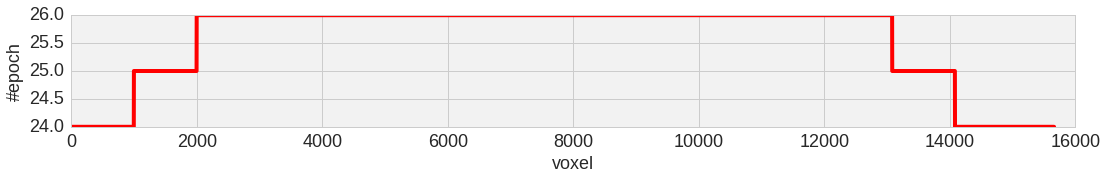

In [38]:
plt.figure(figsize=(18,2))
plt.plot(epoch_count, color='r', lw=4)
plt.xlabel('voxel')
plt.ylabel('#epoch')

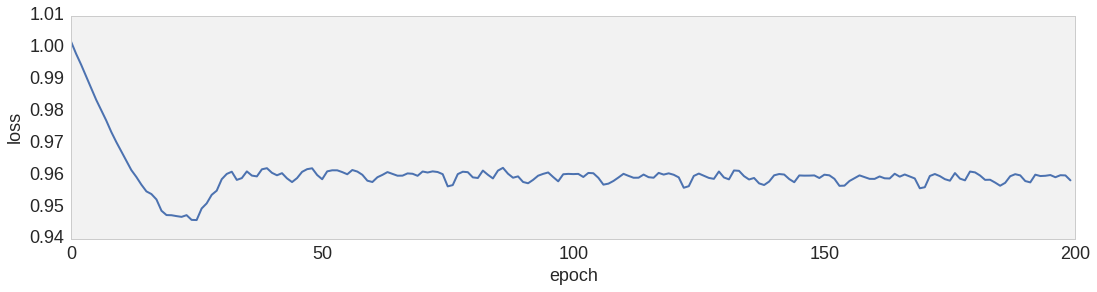

In [39]:
fig0=plt.figure(figsize=(18,4))
plt.plot(np.mean(np.array(val_hist), axis=1), lw=2)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0.0, 1.0)
plt.grid()

In [287]:
filename = output_dir + "training_holdout_loss_%s%s" % (timestamp, saveext)
fig0.patch.set_alpha(0.)
fig0.savefig(filename, **savearg)
plt.close() 

## Go back to the parameter value at the global minimum

In [41]:
_=[_p.set_value(p) for _p,p in zip(_map_params, best_global_map_params)]
#fwrf_params = [np.copy(w) for w in best_global_fwrf_params]

In [42]:
batch_size = 100
trn_vpc_pred = np.zeros(shape=(len(val_stim_data), nvv), dtype=fpX) # same length as val by design
val_vpc_pred = np.zeros(shape=(len(val_stim_data), nvv), dtype=fpX)
for rv,lv in fwrf.iterate_range(0, nvv, nv_block):
    ### reload the params for these voxels
    for k in range(len(fwrf_params)):
        param = np.zeros_like(fwrf_params[k][:nv_block])
        param[:lv] = fwrf_params[k][rv]
        _fwrf_params[k].set_value(param)
    ###
    trn_vpc_block = np.zeros(shape=(len(val_stim_data), nv_block), dtype=fpX)
    val_vpc_block = np.zeros(shape=(len(val_stim_data), nv_block), dtype=fpX)
    for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
        trn_vpc_block[rb] = pred_fn(trn_stim_data[rb])
    trn_vpc_pred[:,rv] = trn_vpc_block[:,:lv]
    for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
        val_vpc_block[rb] = pred_fn(val_stim_data[rb])
    val_vpc_pred[:,rv] = val_vpc_block[:,:lv]    
        
trn_cc = np.zeros(shape=(nvv,), dtype=fpX)    
for v in tqdm(range(nvv)):    
    trn_cc[v] = np.corrcoef(trn_vpc_data[:len(trn_vpc_pred),v], trn_vpc_pred[:,v])[0,1]  
val_cc = np.zeros(shape=(nvv,), dtype=fpX)    
for v in tqdm(range(nvv)):    
    val_cc[v] = np.corrcoef(val_vpc_data[:,v], val_vpc_pred[:,v])[0,1] 

100%|██████████| 15660/15660 [00:01<00:00, 9473.91it/s]


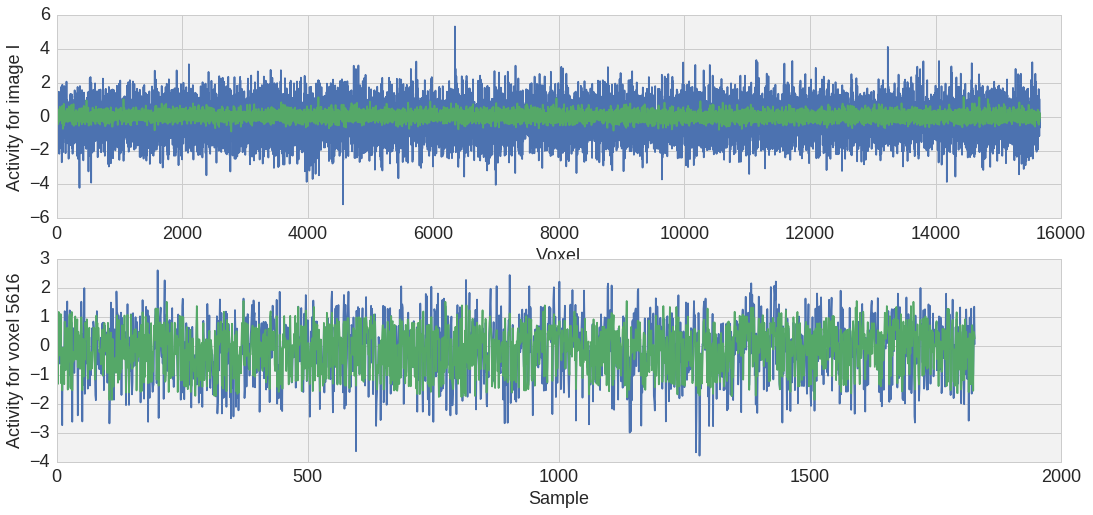

In [43]:
vidxes = np.argsort(val_cc)
plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.plot(val_vpc_data[0,:])
plt.plot(val_vpc_pred[0,:])
plt.xlabel('Voxel')
plt.ylabel('Activity for image I')
plt.subplot(2,1,2)
plt.plot(val_vpc_data[:,vidxes[-1]])
plt.plot(val_vpc_pred[:,vidxes[-1]])
plt.xlabel('Sample')
plt.ylabel('Activity for voxel %d'%vidxes[-1])

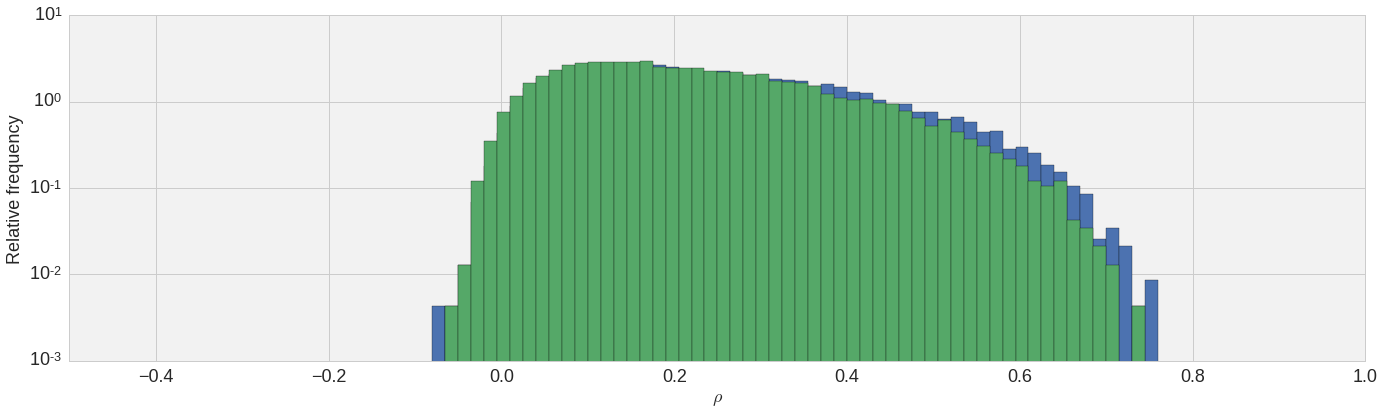

In [44]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(np.nan_to_num(trn_cc), bins=100, normed=True, range=(-.5, 1.))
_=plt.hist(np.nan_to_num(val_cc), bins=100, normed=True, range=(-.5, 1.))
plt.yscale('log')
plt.xlim([-.5, 1.0])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')

## Map back some data into nifty format

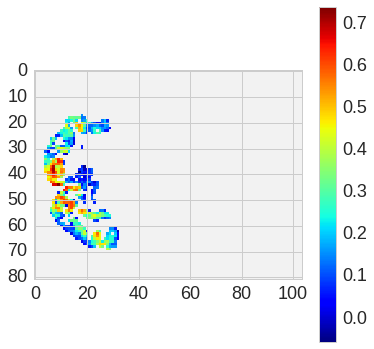

In [582]:
filename = output_dir + "val_cc_%s" % (timestamp)
volume_val_cc  = view_data(volume_r2.shape, vpc_idx, val_cc, save_to=filename)

slice_idx = 40
fig = plt.figure(figsize=(6,6))
plt.imshow(volume_val_cc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

## Compare to reference validation accuracy

In [621]:
import src.plots as pp
reload(pp)

<module 'src.plots' from 'src/plots.py'>

S[ref_cc>0.10] = 9939
S[val_cc>0.10] = 12443


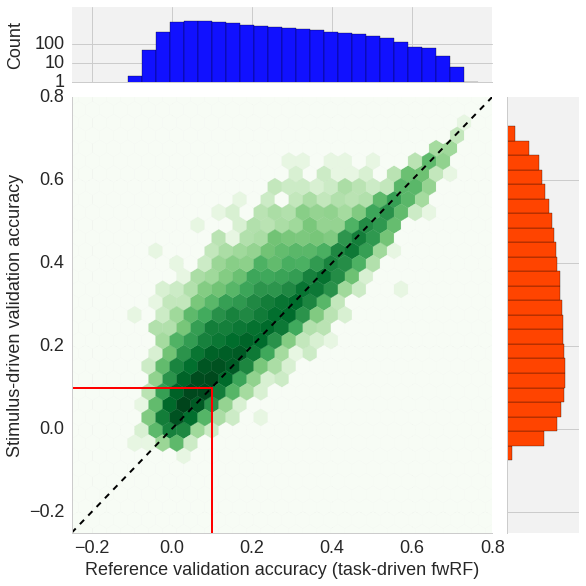

In [45]:
cc_th = 0.1
print "S[ref_cc>%.2f] = %d" % (cc_th, np.sum(ref_val_cc>cc_th))
print "S[val_cc>%.2f] = %d" % (cc_th, np.sum(val_cc>cc_th))
from src.plots import plot_pretty_compare, plot_fwrf_paper_compare
g=plot_pretty_compare(ref_val_cc, val_cc, cc_th, [-.25, .8], [-.25,.8], cmap='Greens')
g.ax_joint.set_xlabel('Reference validation accuracy (task-driven fwRF)')
g.ax_joint.set_ylabel('Stimulus-driven validation accuracy')

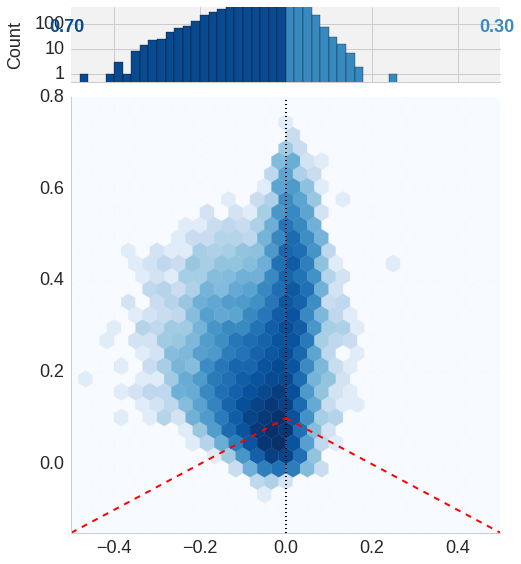

In [46]:
g=plot_fwrf_paper_compare(ref_val_cc, val_cc, cc_th, [-.5, .5], [-.15,.8])

In [584]:
filename = output_dir + "ref_vs_val_cc_%s%s" % (timestamp, saveext)
print filename
plt.gcf().patch.set_alpha(0.)
g.savefig(filename, **savearg)
plt.close()  

/home/styvesg/Documents/PostDoc/GitRepo/nsd/output/S01/ref_vs_val_cc_Aug-11-2019_1609.png


## Approximate self-accuracy

In [47]:
val_corr = np.zeros(shape=(nvv), dtype=fpX)   
for rv,lv in fwrf.iterate_range(0, nvv, nv_block):
    ### reload the params for these voxels
    for k in range(len(fwrf_params)):
        param = np.zeros_like(fwrf_params[k][:nv_block])
        param[:lv] = fwrf_params[k][rv]
        _fwrf_params[k].set_value(param)
    ###
    val_vpc_block = np.zeros(shape=(len(val_vpc_data), nv_block), dtype=fpX)
    val_vpc_block[:,:lv] = val_vpc_data[:,rv]
    for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
        val_corr[rv] += corr_fn(val_stim_data[rb], val_vpc_block[rb])[:lv]
val_corr /= (len(val_stim_data)//batch_size if len(val_stim_data)%batch_size==0 else len(val_stim_data)//batch_size + 1) 

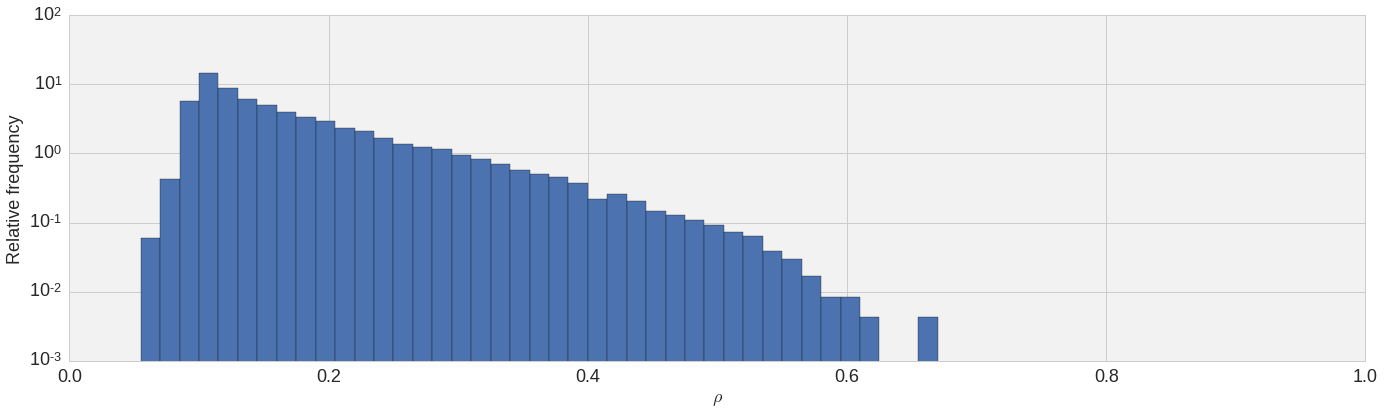

In [48]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_corr, bins=100, normed=True, range=(-.5, 1.))
plt.yscale('log')
plt.xlim([0, 1.0])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')

---
# Evolution of model comparision through training

In [456]:
for k,cc in enumerate(cc_hist):
    g=plot_pretty_compare(ref_val_cc, cc, cc_th, [-.25, .8], [-.25,.8], cmap='Greens')
    if k<best_epoch:
        plt.text(-0.21, 0.72, '%03d'%(k+1), fontsize=28, bbox=dict(facecolor='green', alpha=0.5))
    else:
        plt.text(-0.21, 0.72, '%03d'%(k+1), fontsize=28, bbox=dict(facecolor='red', alpha=0.5))
    g.ax_joint.set_xlabel('Reference validation accuracy (task-driven fwRF)')
    g.ax_joint.set_ylabel('Stimulus-driven validation accuracy')
    
    filename = video_dir + "ref_vs_val_cc_%s_%04d%s" % (timestamp, k+1, saveext)
    print filename
    plt.gcf().patch.set_alpha(0.)
    g.savefig(filename, **savearg)
    plt.close()  

/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0001.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0002.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0003.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0004.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0005.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0006.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0007.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0008.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0009.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0010.png
/home/styvesg/Documents/PostDoc/GitRepo/nsd/video/ref_vs_val_cc_Aug-06-2019_1605_0011.png
/home/styv

---

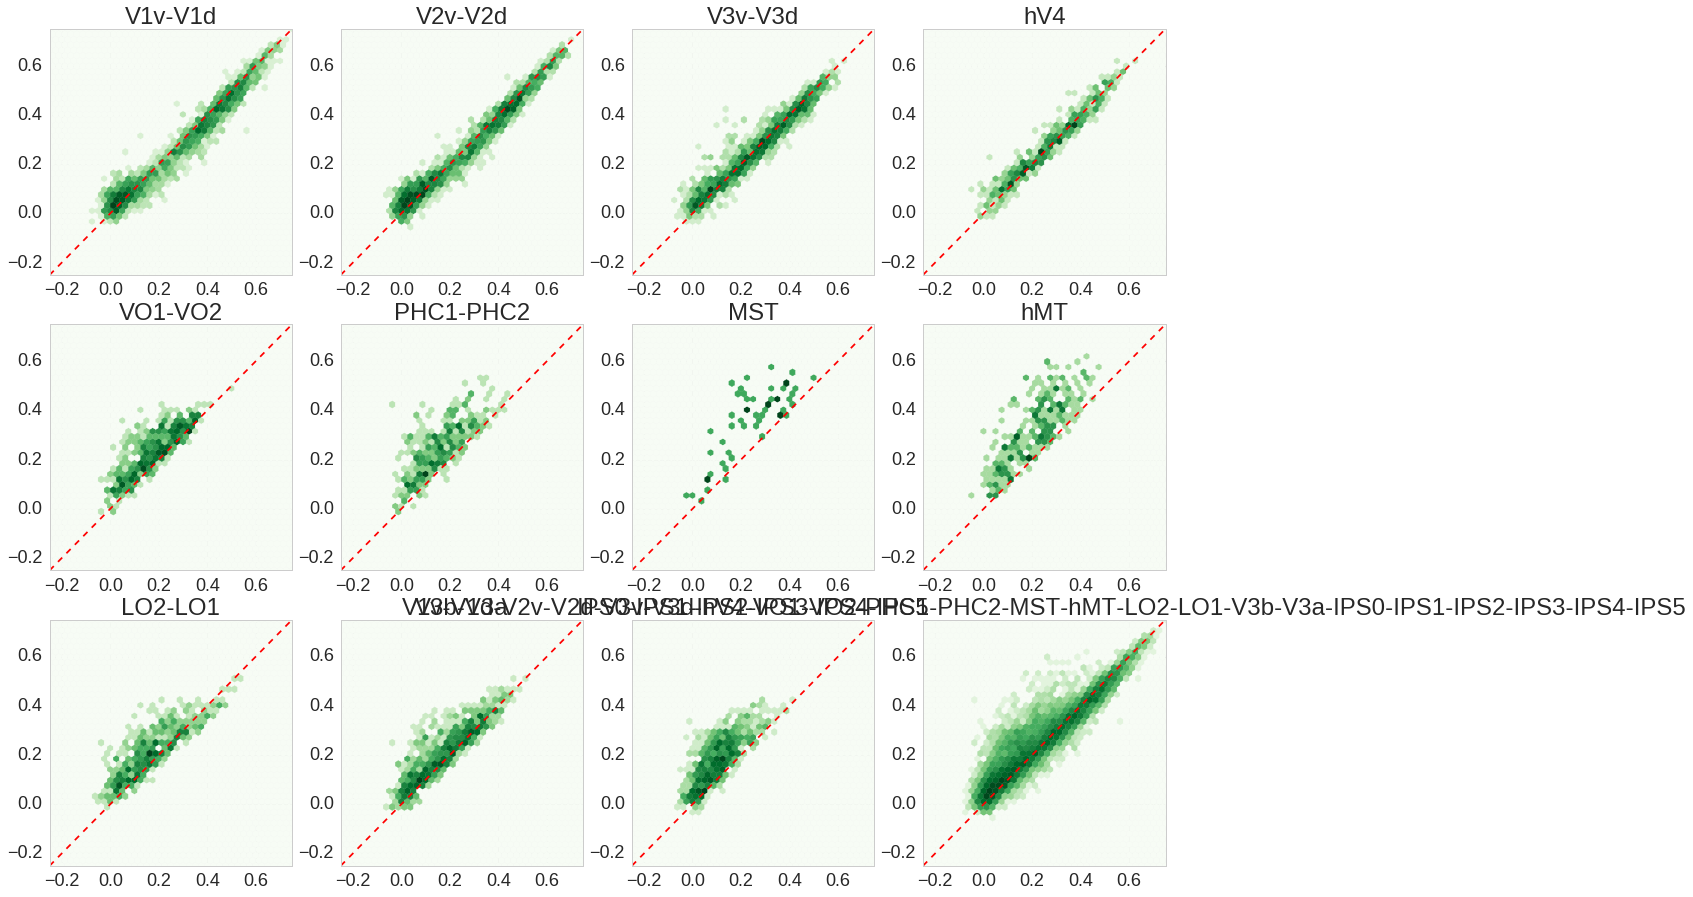

In [49]:
plot_per_line = 4
n_col = len(roi_group)//plot_per_line
if len(roi_group)%plot_per_line!=0:
    n_col+=1
fig5=plt.figure(figsize=(5*plot_per_line,5*n_col))
for k,(group_mask, group_name) in enumerate(iterate_roi(roi_group, vpc_roi, roi_map)):
    plt.subplot(n_col,plot_per_line,k+1)
    plt.title(group_name)
    plt.hexbin(ref_val_cc[group_mask], val_cc[group_mask], bins='log', gridsize=40, extent=[-.25,.75,-.25,.75], cmap='Greens')
    plt.plot([-.25,.75], [-.25, .75], '--r')

In [588]:
filename = output_dir + "val_cc_comparision_per_roi_%s%s" % (timestamp, saveext)
fig5.patch.set_alpha(0.)
fig5.savefig(filename, **savearg)
plt.close() 

# Model parameter analysis
## Network layer tuning measures

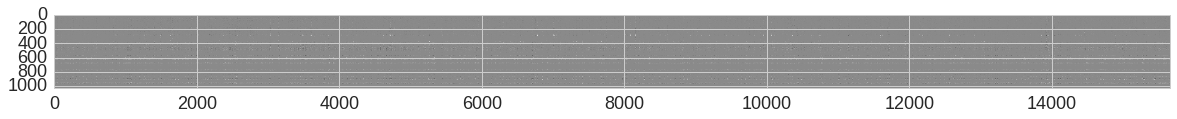

In [50]:
plt.figure(figsize=(20,5))
plt.imshow(fwrf_params[feature_weight_idx].T)

In [51]:
fmaps_count = np.sum(fm[1] for fm in fmaps_shapes)
running_count = 0
layer_rlist = []
for fm in fmaps_shapes:
    layer_rlist += [np.arange(running_count,running_count+fm[1]),]
    running_count += fm[1]
    
partition_val_pred = np.ndarray(shape=(len(layer_rlist), len(val_stim_data), nvv), dtype=fpX)
partition_val_cc   = np.ndarray(shape=(len(layer_rlist), nvv), dtype=fpX)
partition_val_cov  = np.ndarray(shape=(len(layer_rlist), nvv), dtype=fpX)
feature_tuning_params = np.copy(fwrf_params[feature_weight_idx])
for l,rl in tqdm(enumerate(layer_rlist)):
    for rv,lv in fwrf.iterate_range(0, nvv, nv_block):
        ### reload the params for these voxels
        for k in range(len(fwrf_params)):
            param = np.copy(fwrf_params[k][:nv_block])
            param[:lv] = fwrf_params[k][rv]
            _fwrf_params[k].set_value(param)
        ###
        partition_params = np.zeros(_fwrf_params[feature_weight_idx].get_value().shape, dtype=fpX) 
        partition_params[:lv, rl] = feature_tuning_params[rv][:, rl]
        _fwrf_params[feature_weight_idx].set_value(partition_params)
        ###
        val_block = np.zeros(shape=(len(val_stim_data), nv_block), dtype=fpX)
        for rb,_ in fwrf.iterate_range(0, len(val_stim_data), batch_size):
            val_block[rb] = pred_fn(val_stim_data[rb])
        partition_val_pred[l][:,rv] = val_block[:,:lv] # you can specify 2 ranges in the same bracket.
    ###
    for v in range(nvv):
        partition_val_cc[l,v] = np.corrcoef(partition_val_pred[l,:,v], val_vpc_data[:,v])[0,1]
        partition_val_cov[l,v] = np.cov(partition_val_pred[l,:,v], val_vpc_data[:,v])[0,1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if __name__ == '__main__':
4it [01:03, 15.79s/it]


In [52]:
partition_val_var = np.var(partition_val_pred, axis=1)
gamma = partition_val_var / np.sum(partition_val_var, axis=0, keepdims=True)

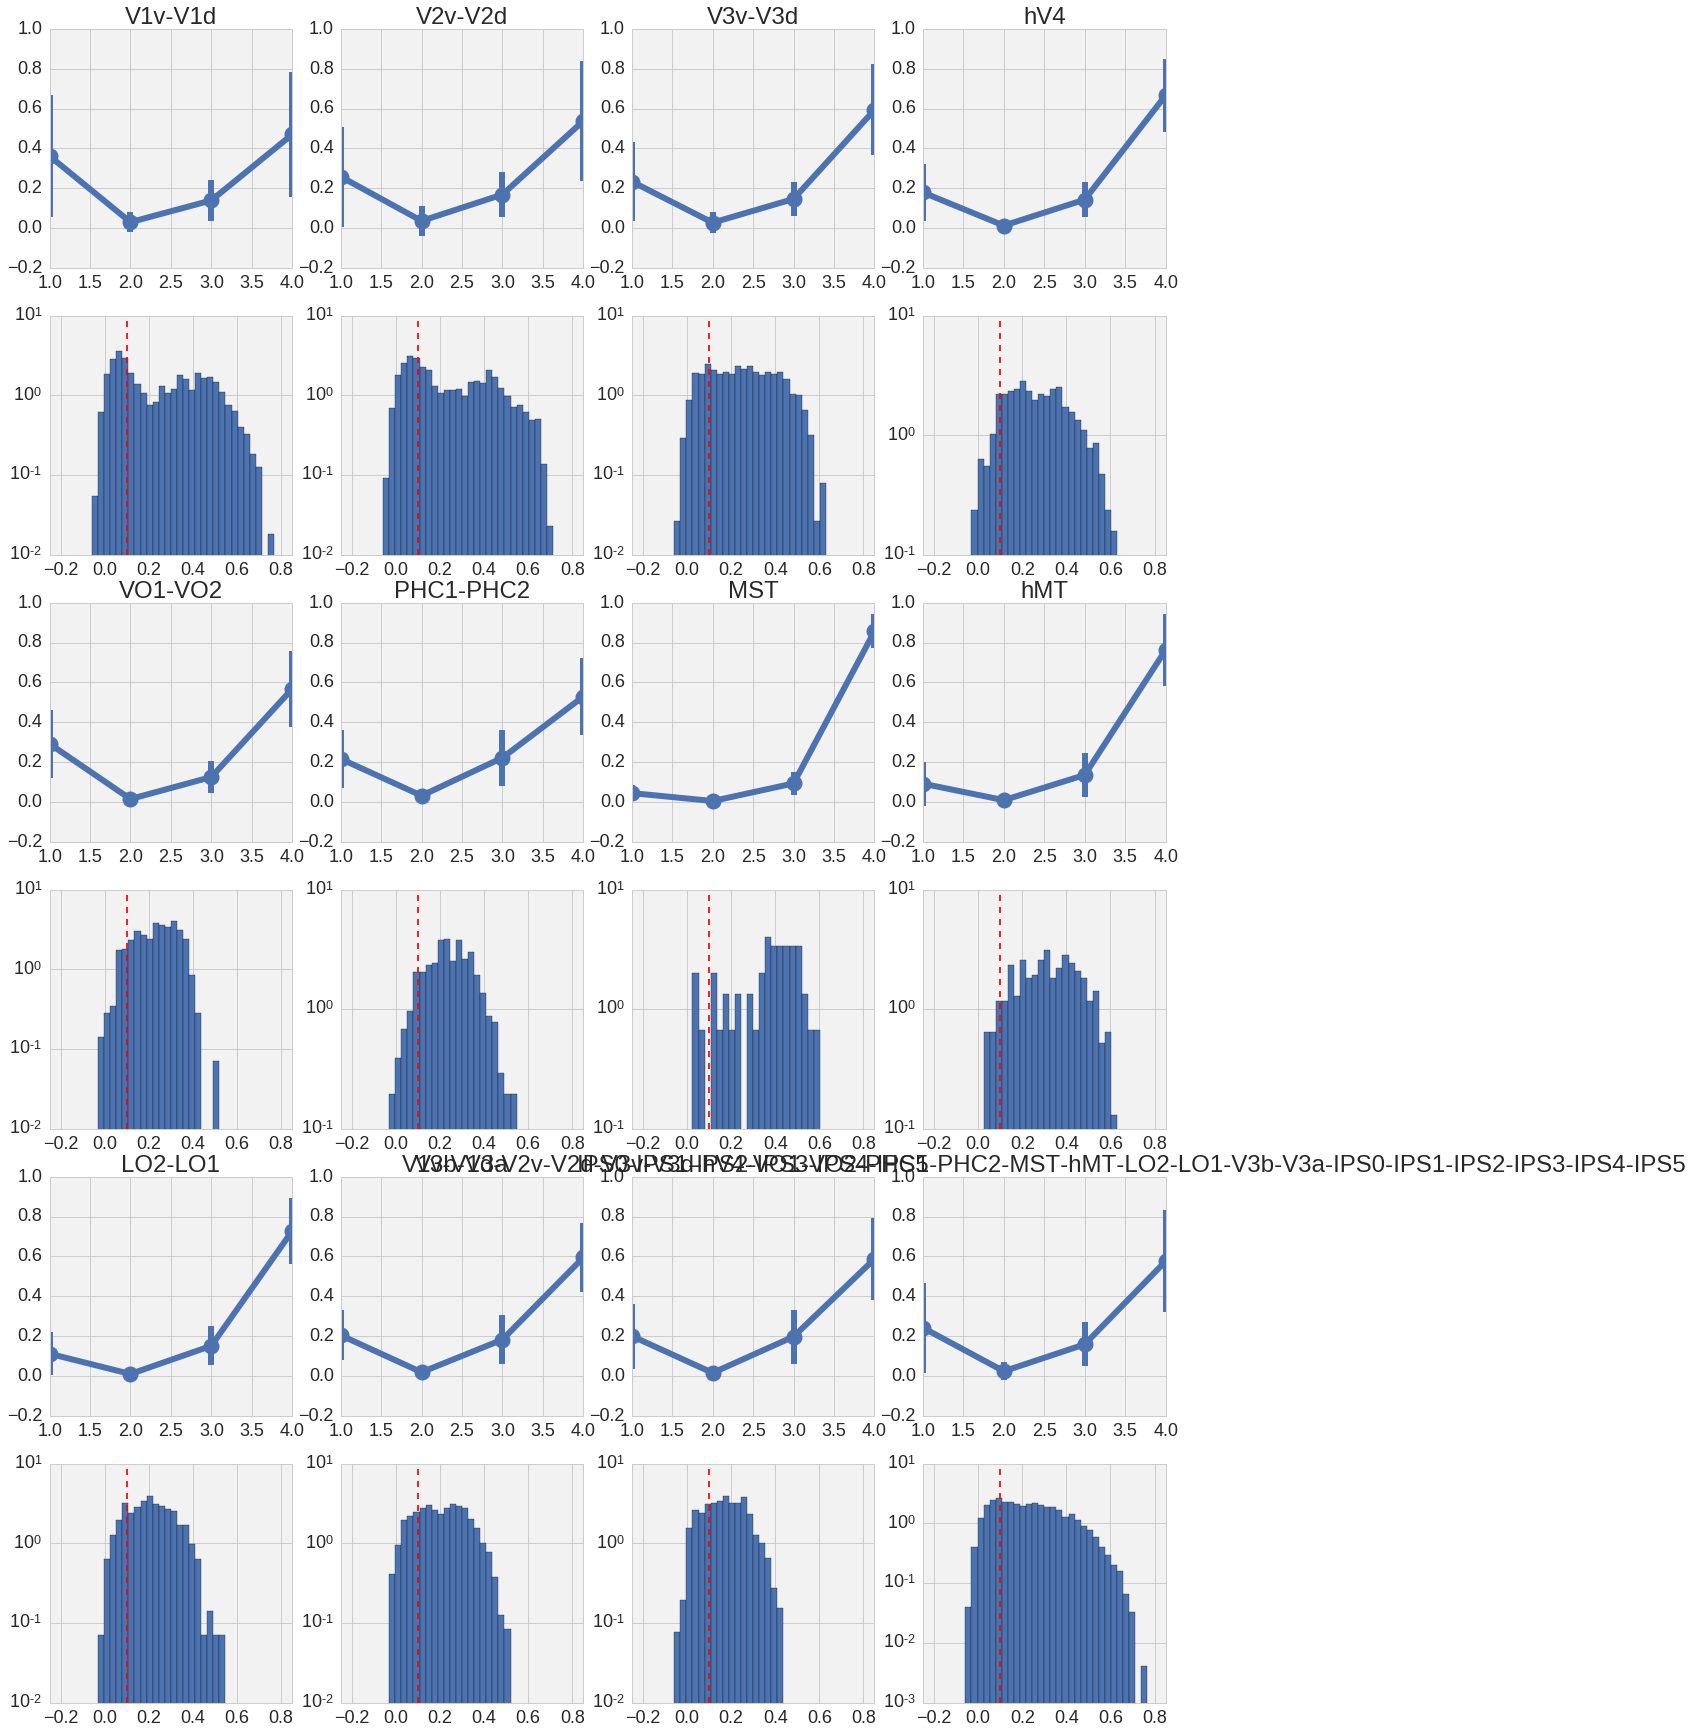

In [53]:
cc_th = .1
plot_per_line = 4
n_col = len(roi_group)//plot_per_line
if len(roi_group)%plot_per_line!=0:
    n_col+=1   
fig4a=plt.figure(figsize=(5*plot_per_line,10*n_col))
for k,(group_mask, group_name) in enumerate(iterate_roi(roi_group, vpc_roi, roi_map)):
    n = 2*plot_per_line*(k//plot_per_line) + k%plot_per_line
    plt.subplot(2*n_col,plot_per_line,n+1)
    plt.title(group_name)
    cc_mask = val_cc>cc_th
    plt.errorbar(x=np.arange(1,len(partition_val_cc)+1),
        y   =[np.mean(gamma[l,np.logical_and(group_mask, cc_mask)], axis=0) for l in range(len(partition_val_cc))],
        yerr=[np.std(gamma[l,np.logical_and(group_mask, cc_mask)], axis=0) for l in range(len(partition_val_cc))],
        marker='o', ms=16, lw=6)
    plt.ylim([-.2, 1.])
    ##
    plt.subplot(2*n_col,plot_per_line,plot_per_line+n+1)
    _=plt.hist(val_cc[group_mask], bins=40, normed=True, range=(-.25, .85))
    plt.yscale('log')
    plt.axvline(x=[cc_th], ymin=0, ymax=1e3, color='r', linestyle='dashed')
    #plt.ylim([10**-1, 10**1])
    plt.xlim([-.25, .85])

In [593]:
filename = output_dir + "feature_weight_partial_var_%s%s" % (timestamp, saveext)
fig4a.patch.set_alpha(0.)
fig4a.savefig(filename, **savearg)
plt.close() 

In [54]:
gamma = partition_val_cov/np.sum(partition_val_cov, axis=0, keepdims=True)

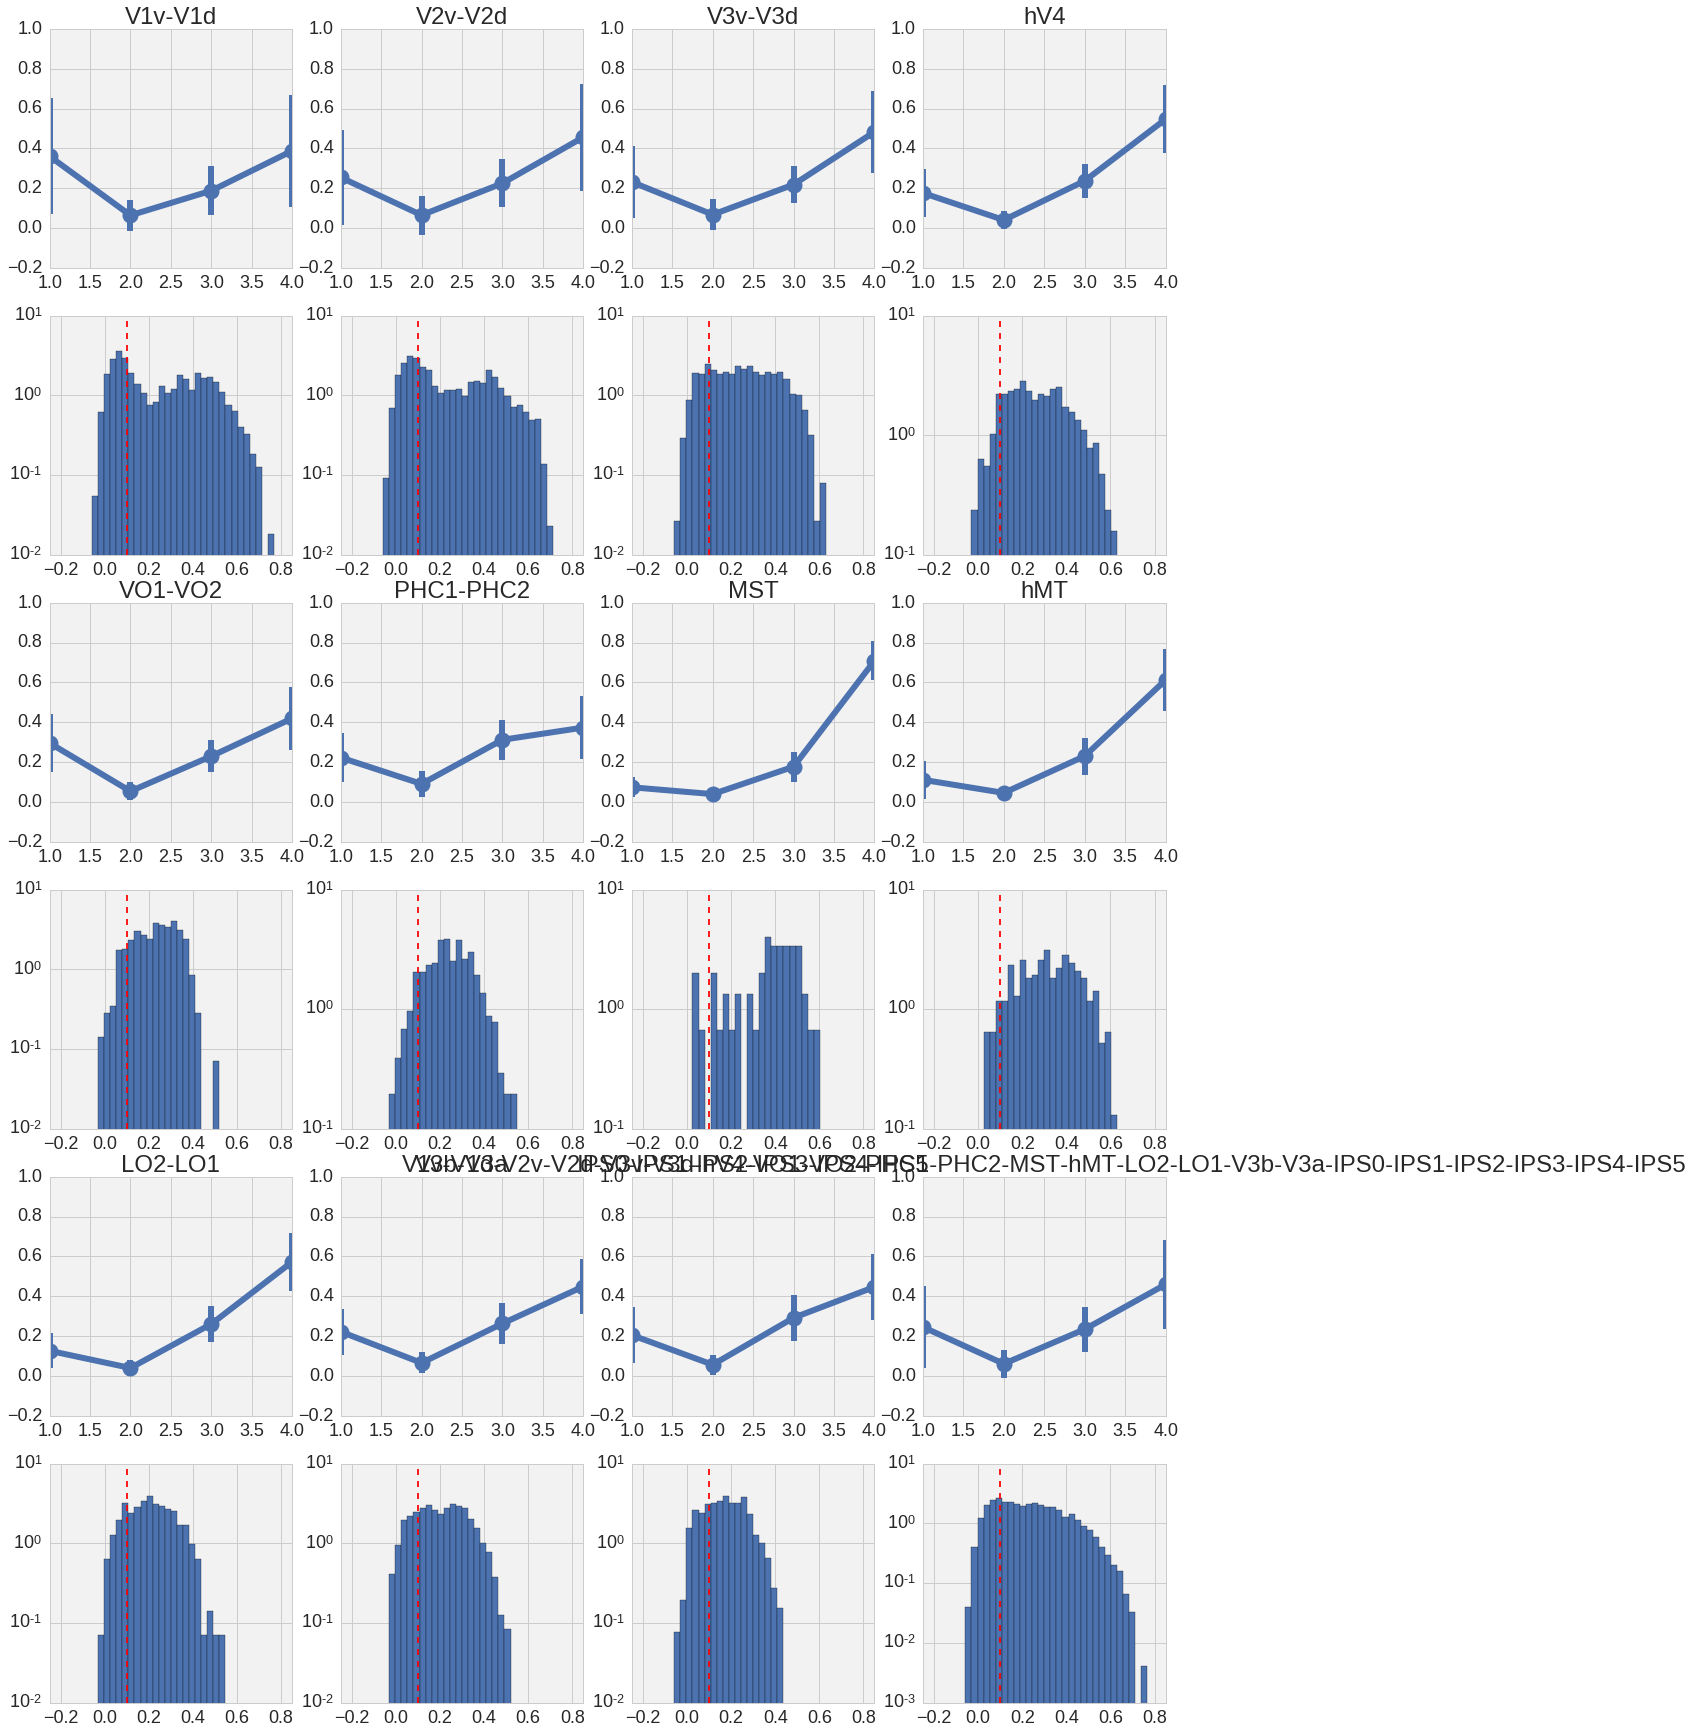

In [55]:
cc_th = .1
plot_per_line = 4
n_col = len(roi_group)//plot_per_line
if len(roi_group)%plot_per_line!=0:
    n_col+=1   
fig4b=plt.figure(figsize=(5*plot_per_line,10*n_col))
for k,(group_mask, group_name) in enumerate(iterate_roi(roi_group, vpc_roi, roi_map)):
    n = 2*plot_per_line*(k//plot_per_line) + k%plot_per_line
    plt.subplot(2*n_col,plot_per_line,n+1)
    plt.title(group_name)
    cc_mask = val_cc>cc_th
    plt.errorbar(x=np.arange(1,len(partition_val_cc)+1),
        y   =[np.mean(gamma[l,np.logical_and(group_mask, cc_mask)], axis=0) for l in range(len(partition_val_cc))],
        yerr=[np.std(gamma[l,np.logical_and(group_mask, cc_mask)], axis=0) for l in range(len(partition_val_cc))],
        marker='o', ms=16, lw=6)
    plt.ylim([-.2, 1.])
    ##
    plt.subplot(2*n_col,plot_per_line,plot_per_line+n+1)
    _=plt.hist(val_cc[group_mask], bins=40, normed=True, range=(-.25, .85))
    plt.yscale('log')
    plt.axvline(x=[cc_th], ymin=0, ymax=1e3, color='r', linestyle='dashed')
    #plt.ylim([10**-1, 10**1])
    plt.xlim([-.25, .85])

In [596]:
filename = output_dir + "feature_weight_partial_cov_%s%s" % (timestamp, saveext)
fig4b.patch.set_alpha(0.)
fig4b.savefig(filename, **savearg)
plt.close() 

## Pooling field profiles

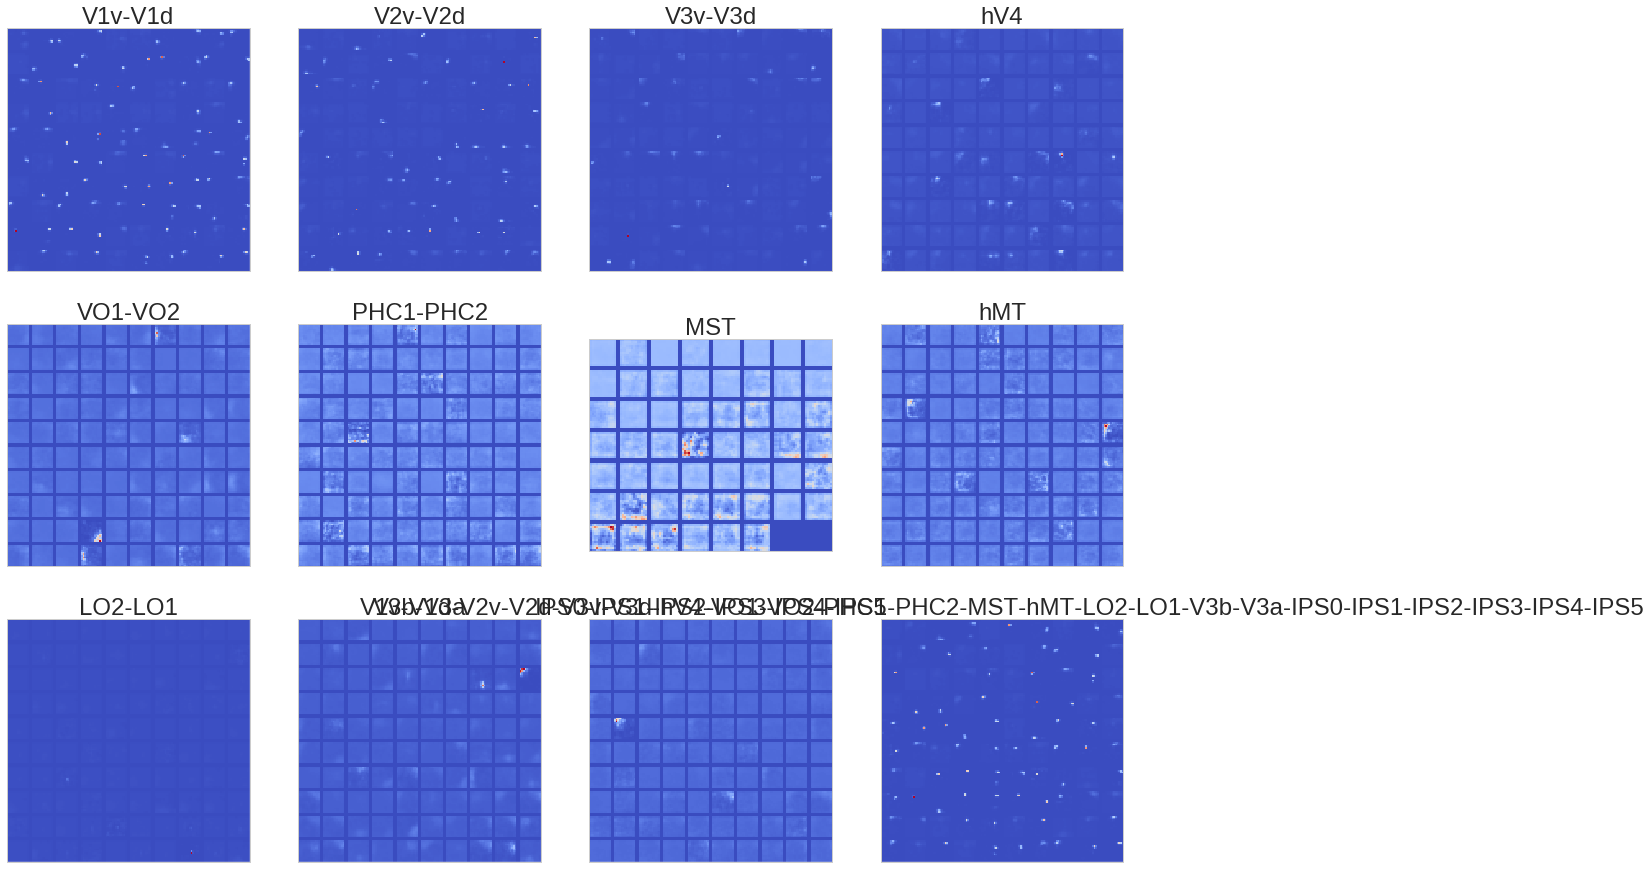

In [56]:
from matplotlib import cm
cc_th = .1
plot_per_line = 4
n_col = len(roi_group)//plot_per_line
if len(roi_group)%plot_per_line!=0:
    n_col+=1   
fig6=plt.figure(figsize=(5*plot_per_line,5*n_col))
for k,(group_mask, group_name) in enumerate(iterate_roi(roi_group, vpc_roi, roi_map)):
    plt.subplot(n_col,plot_per_line,k+1)
    plt.title(group_name)
    roi_idx = np.arange(len(val_cc))[group_mask]
    vidxes = roi_idx[np.argsort(val_cc[group_mask])]
    
    plt.imshow(pnu.mosaic_vis(pooling_fn(fwrf_params[0][vidxes[-100:]]), pad=2), interpolation='None', cmap=cm.coolwarm) # vidxes[-100:]
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)      

In [598]:
filename = output_dir + "rf_per_roi_%s%s" % (timestamp, saveext)
fig6.patch.set_alpha(0.)
fig6.savefig(filename, **savearg)
plt.close() 

## Individually normalized best profiles

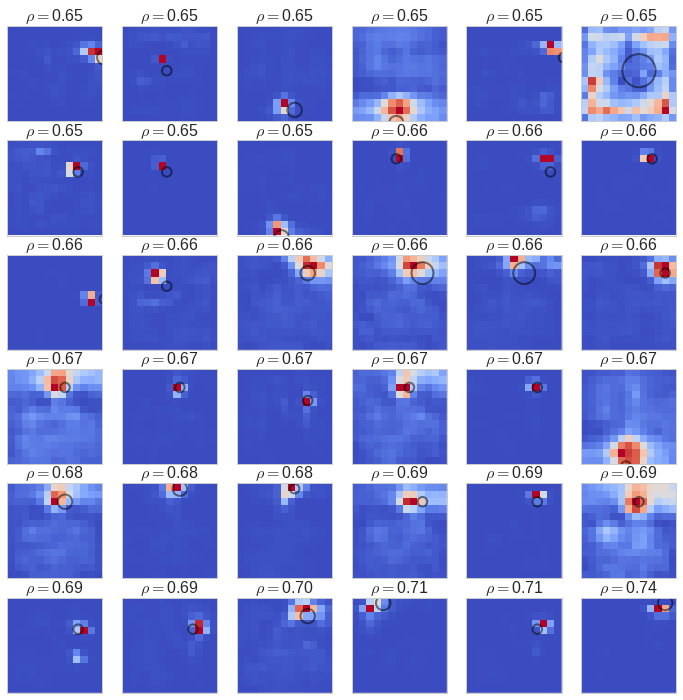

In [57]:
vidxes = np.argsort(val_cc)
vox = vidxes[-36:] # np.arange(49) #
n_x = int(np.floor(np.sqrt(len(vox))))
n_y = int(np.ceil(len(vox)/n_x))+1
n_pix = fwrf_params[0].shape[2]
ref_rf = ref_rf_params
fig2a=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(fwrf_params[0][v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]
    c = plt.Circle(((0.5+ref_rf[v,0])*n_pix, (0.5-ref_rf[v,1])*n_pix), ref_rf[v,2]*n_pix, color='k', fill=False, alpha=0.5, lw=2.)
    plt.gca().add_artist(c)        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'%val_cc[v], fontsize=16)

---

In [455]:
filename = output_dir + "RF_ref_vs_field_a_%s%s" % (timestamp, saveext)
fig2a.patch.set_alpha(0.)
fig2a.savefig(filename, **savearg)
plt.close()  

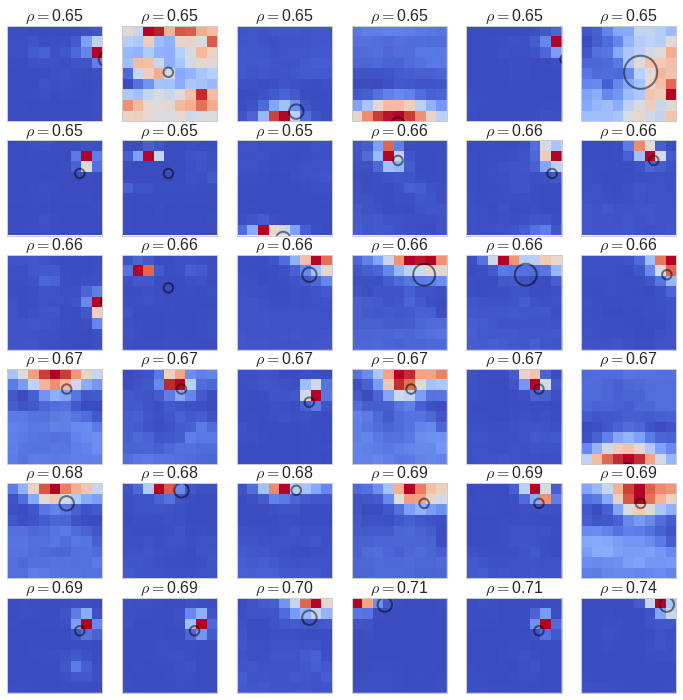

In [59]:
n_pix = fwrf_params[1].shape[2]
fig2b=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(fwrf_params[1][v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]
    c = plt.Circle(((0.5+ref_rf[v,0])*n_pix, (0.5-ref_rf[v,1])*n_pix), ref_rf[v,2]*n_pix, color='k', fill=False, alpha=0.5, lw=2.)
    plt.gca().add_artist(c)        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'%val_cc[v], fontsize=16)

In [213]:
filename = output_dir + "RF_ref_vs_field_b_%s%s" % (timestamp, saveext)
fig2b.patch.set_alpha(0.)
fig2b.savefig(filename, **savearg)
plt.close()  

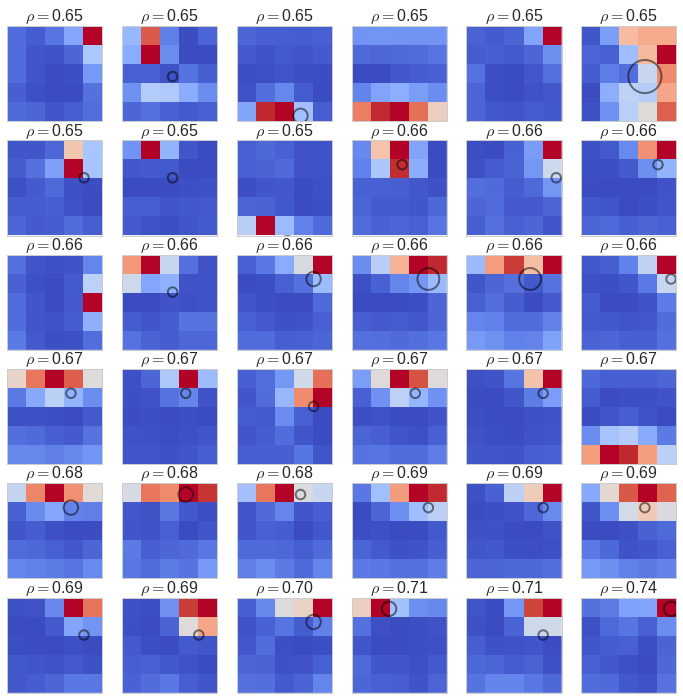

In [60]:
n_pix = fwrf_params[2].shape[2]
fig2c=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(fwrf_params[2][v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]
    c = plt.Circle(((0.5+ref_rf[v,0])*n_pix, (0.5-ref_rf[v,1])*n_pix), ref_rf[v,2]*n_pix, color='k', fill=False, alpha=0.5, lw=2.)
    plt.gca().add_artist(c)        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'%val_cc[v], fontsize=16)

In [215]:
filename = output_dir + "RF_ref_vs_field_c_%s%s" % (timestamp, saveext)
fig2c.patch.set_alpha(0.)
fig2c.savefig(filename, **savearg)
plt.close()  

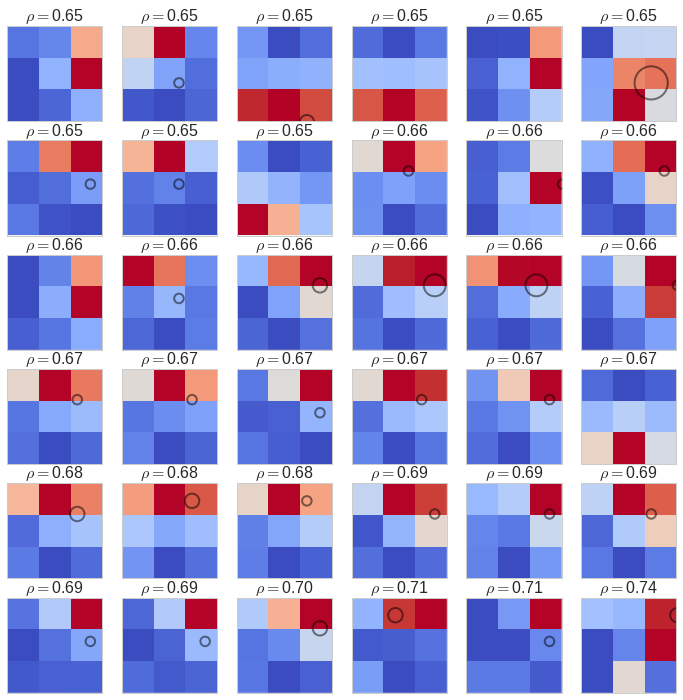

In [61]:
n_pix = fwrf_params[3].shape[2]
fig2d=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(fwrf_params[3][v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]
    c = plt.Circle(((0.5+ref_rf[v,0])*n_pix, (0.5-ref_rf[v,1])*n_pix), ref_rf[v,2]*n_pix, color='k', fill=False, alpha=0.5, lw=2.)
    plt.gca().add_artist(c)        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'%val_cc[v], fontsize=16)

In [218]:
filename = output_dir + "RF_ref_vs_field_d_%s%s" % (timestamp, saveext)
fig2d.patch.set_alpha(0.)
fig2d.savefig(filename, **savearg)
plt.close()  

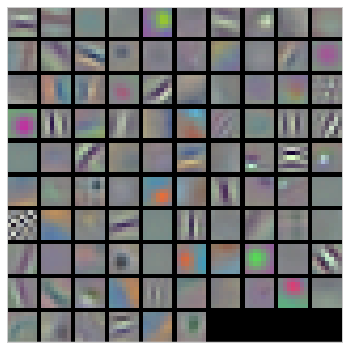

In [307]:
_filter_params = L.get_all_params(lrn2)
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(_filter_params[0].get_value().transpose(0, 2, 3, 1), pad=1), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

---

---

In [ ]:

def _layerwise_fwrf(_fmaps, fmaps_shapes, rf_rez=(1,1), nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _phi, _rfs = [],[]
    for l,(_f,s) in enumerate(zip(_fmaps, fmaps_shapes)):
        if s != (1,1):
            _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+rf_rez).astype(dtype), name='xyRF_%d'%l)
            _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(rf_rez)))), (nv,)+rf_rez)
            if rf_rez != s[2:4]:
                print 'rescale'
                u = create_sampling_array(rf_rez, s[2:4])
                _u = theano.shared(u.reshape(s[2:4]+rf_rez).astype(dtype))
                _v = T.tensordot(_v, _u, [[1,2], [2,3]])
            #fmaps : [batch, features, y, x]   # v : [nv, y, x]
            _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
            _rfs += [_rf,]
        else:
            _phi += [_f.flatten(ndim=2),]          
        #_phi : [nv, batch, features]
    ###
    _Phi = T.concatenate(_phi, axis=2)
    if nonlinearity is not None:
        _Phi = nonlinearity(_Phi)
    _w = theano.shared(np.full(fill_value=0, shape=(nv, ft_count), dtype=dtype), name='fRF')
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    #theano.shared(np.random.normal(0, .02, size=(nv, ft_count)).astype(dtype), name='fRF')
    _vr = T.batched_dot(_Phi, _w).T + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, _rfs+[_w,_beta]

def _rank_fwrf(_fmaps, fmaps_shapes, rf_rez=(1,1), rank=1, nv=1, nonlinearity=None, dtype=np.float32):
    ft_count=np.sum([s[1] for s in fmaps_shapes])
    rf_max = np.max([s[2] for s in fmaps_shapes])
    print ft_count, rf_max, rf_max
    _U = []
    for _f,s in zip(_fmaps, fmaps_shapes):  
        if rf_rez != s[2:4]:
            print 'rescale'
            u = create_sampling_array(rf_rez, s[2:4])
            _U += [theano.shared(u.reshape(s[2:4]+rf_rez).astype(dtype)),]
        else:
            _U += [None,]
    ###  
    _params,_vrs = [],[]
    for r in range(rank):
        _phi = []
        _rf = theano.shared(np.full(fill_value=1, shape=(nv,)+rf_rez).astype(dtype), name='g_%d'%r)
        _w = theano.shared(np.full(fill_value=1, shape=(nv, ft_count)).astype(dtype=dtype), name='w_%d'%r)
        _alpha = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='a_%d'%r)
        _v = T.reshape(T.nnet.nnet.softmax(T.reshape(_rf, (nv,np.prod(rf_rez)))), (nv,)+rf_rez)
        for _f, _u in zip(_fmaps, _U):  
            if _u is not None:
                _v = T.tensordot(_v, _u, [[1,2], [2,3]])  
            _phi += [T.tensordot(_v, _f, [[1,2], [2,3]]),]
            #_phi : [nv, batch, features]
        _Phi = T.concatenate(_phi, axis=2)
        if nonlinearity is not None:
            _Phi = nonlinearity(_Phi)
        _params += [_rf, _w, _alpha,]
        _vrs += [_alpha.dimshuffle('x',0) * T.batched_dot(_Phi, T.nnet.nnet.softmax(_w)).T,] 
    _beta = theano.shared(np.full(fill_value=0, shape=(nv,), dtype=dtype), name='bias')
    _vr = sum(_vrs) + _beta.dimshuffle('x',0)
    #_v : [batch, nv]
    return _vr, _params + [_beta]

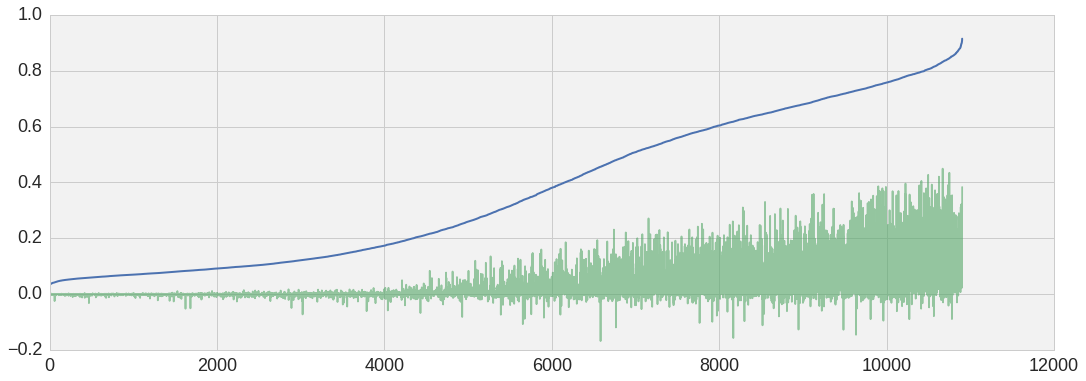

In [220]:
r2_pred = fpX(1) - np.sum(np.square(val_vpc_data - val_vpc_pred), axis=0) / \
                   np.sum(np.square(val_vpc_data - np.mean(val_vpc_data, axis=0, keepdims=True)), axis=0) 
sortidx = np.argsort(r2_data)
fig=plt.figure(figsize=(18,6))
plt.plot(r2_data[sortidx] / 100, lw=2)
plt.plot(r2_pred[sortidx], alpha=.6)

## Re-initialize

In [60]:
param_file_name = output_dir + 'trained_model_Aug-01-2019_1357.pkl'
param_file = open(param_file_name, 'rb')
param_dict = pickle.load(param_file)
param_file.close()
print param_dict.keys()

['val_loss_history', 'voxel_roi', 'best_global_map_params', 'voxel_order', 'voxel_index', 'best_global_fwrf_params', 'filter_params']


In [96]:
L.set_all_param_values(lrn2, param_dict['filter_params'])
[_p.set_value(p) for _p,p in zip(_map_params, param_dict['best_global_map_params'])]
fwrf_params = [np.copy(w) for w in param_dict['best_global_fwrf_params']]

In [97]:
map_params = [_p.get_value() for _p in _map_params]

---